In [1]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('cleaned_gas_data.csv')

# Convert all numeric columns to float type, handling any non-numeric values
numeric_columns = df.columns.drop('Meter_location')
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter for meter locations starting with F, G, or H
filtered_df = df[df['Meter_location'].str.match('^[FGH]')]

# Function to extract building code
def extract_building_code(location):
    return location.split(',')[0].split()[0]

# Add a new column with the building code
filtered_df['Building_Code'] = filtered_df['Meter_location'].apply(extract_building_code)

# Group by building code and calculate the mean for all numeric columns
result_df = filtered_df.groupby('Building_Code')[numeric_columns].mean().reset_index()

# Reorder columns to have Building_Code first
columns = ['Building_Code'] + list(numeric_columns)
result_df = result_df[columns]

# Export to CSV
result_df.to_csv('modelling_gas_data.csv', index=False)

print("modelling_gas_data.csv has been created successfully.")



modelling_gas_data.csv has been created successfully.


C:\Users\sugan\AppData\Local\Temp\ipykernel_8716\526457268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Building_Code'] = filtered_df['Meter_location'].apply(extract_building_code)


In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('cleaned_gas_data.csv')

# Convert all numeric columns to float type, handling any non-numeric values
numeric_columns = df.columns.drop('Meter_location')
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter for meter locations starting with F, G, or H
filtered_df = df[df['Meter_location'].str.match('^[FGH]')]

# Function to extract building code and name
def extract_building_info(location):
    parts = location.split(',')
    code = parts[0].split()[0]
    # Get the building name (everything after the code until the first comma)
    name = ' '.join(parts[0].split()[1:])
    return pd.Series([code, name], index=['Building_Code', 'Building_Name'])

# Add new columns with the building code and name
building_info = filtered_df['Meter_location'].apply(extract_building_info)
filtered_df = pd.concat([filtered_df, building_info], axis=1)

# Define aggregation function
def custom_agg(group):
    if group['Building_Code'].iloc[0].startswith('F940'):
        return group[numeric_columns].sum()
    return group[numeric_columns].mean()

# Group by building code and name, then apply custom aggregation
result_df = (filtered_df.groupby(['Building_Code', 'Building_Name'])
             .apply(custom_agg)
             .reset_index())

# Reorder columns to have Building_Code and Building_Name first
columns = ['Building_Code', 'Building_Name'] + list(numeric_columns)
result_df = result_df[columns]

# Export to CSV
result_df.to_csv('modelling_gas_data.csv', index=False)

print("modelling_gas_data.csv has been created successfully.")


modelling_gas_data.csv has been created successfully.


C:\Users\sugan\AppData\Local\Temp\ipykernel_8716\4287751774.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(custom_agg)


In [36]:
import pandas as pd
import numpy as np

# Read the data
df = pd.read_csv('modelling_gas_data.csv')

# Step 1: Create month labels for seasonal pattern recognition
month_labels = [i.split('_')[0] for i in df.columns[1:]]  # Skip Building_Code column

# Step 2: Create a function for seasonal imputation
def seasonal_impute(row):
    # Get the month-wise values for 2022, 2023, and 2024
    years_data = {
        '2022': row[1:13],    # Jan-Dec 2022
        '2023': row[13:25],   # Jan-Dec 2023
        '2024': row[25:]      # Jan-Dec 2024
    }
    
    # For each month position (0-11)
    for month in range(12):
        # If value is 0 or null for any year
        for year in years_data:
            current_value = years_data[year].iloc[month]
            if current_value == 0 or pd.isna(current_value):
                # Get values for same month from other years
                month_values = [years_data[y].iloc[month] for y in years_data 
                              if years_data[y].iloc[month] != 0 and not pd.isna(years_data[y].iloc[month])]
                
                # If we have values from other years, use their mean
                if month_values:
                    imputed_value = np.mean(month_values)
                    years_data[year].iloc[month] = imputed_value
    
    # Combine the imputed data back
    return pd.concat([pd.Series([row['Building_Code']]), 
                     years_data['2022'], 
                     years_data['2023'], 
                     years_data['2024']])

# Apply the imputation
imputed_df = df.apply(seasonal_impute, axis=1)

# Export the imputed dataset
imputed_df.to_csv('imputed_modelling_gas_data.csv', index=False)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U22'), dtype('<U22')) -> None

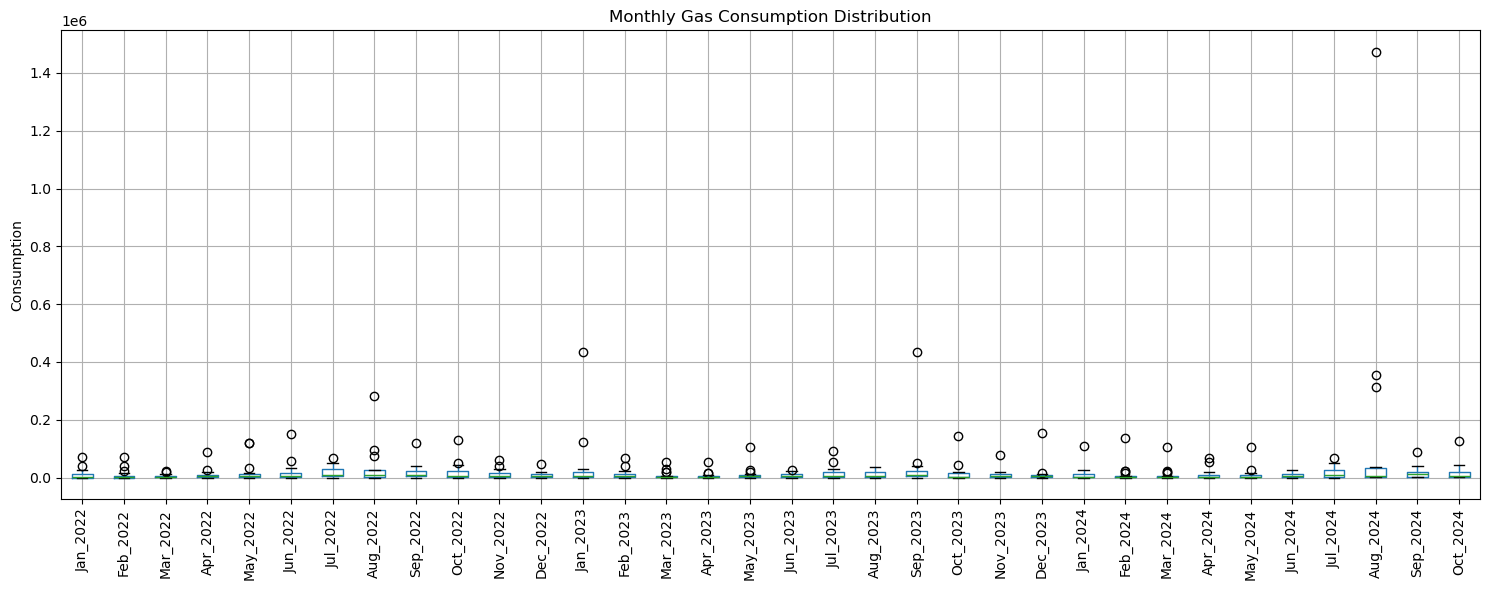

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Read the data
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Calculate Z-scores for each numeric column
def detect_anomalies(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = pd.DataFrame()
    
    for col in numeric_cols:
        z_scores[col] = np.abs(stats.zscore(df[col]))
    
    # Consider values with z-score > 3 as anomalies
    anomalies = (z_scores > 3).any(axis=1)
    return anomalies

# Visualization code
def plot_anomalies(df, building_code):
    plt.figure(figsize=(15, 6))
    data = df[df['Building_Code'] == building_code].iloc[:, 1:].T
    plt.plot(data.index, data.values, 'b-', label='Consumption')
    
    # Calculate anomalies using IQR method
    Q1 = data.values.flatten().quantile(0.25)
    Q3 = data.values.flatten().quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Plot anomalies
    anomalies = data[(data.values.flatten() > upper_bound) | (data.values.flatten() < lower_bound)]
    plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
    
    plt.title(f'Gas Consumption Anomalies for Building {building_code}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot monthly distributions with boxplots to show outliers
plt.figure(figsize=(15, 6))
df.iloc[:, 1:].boxplot()
plt.xticks(rotation=90)
plt.title('Monthly Gas Consumption Distribution')
plt.ylabel('Consumption')
plt.tight_layout()
plt.show()


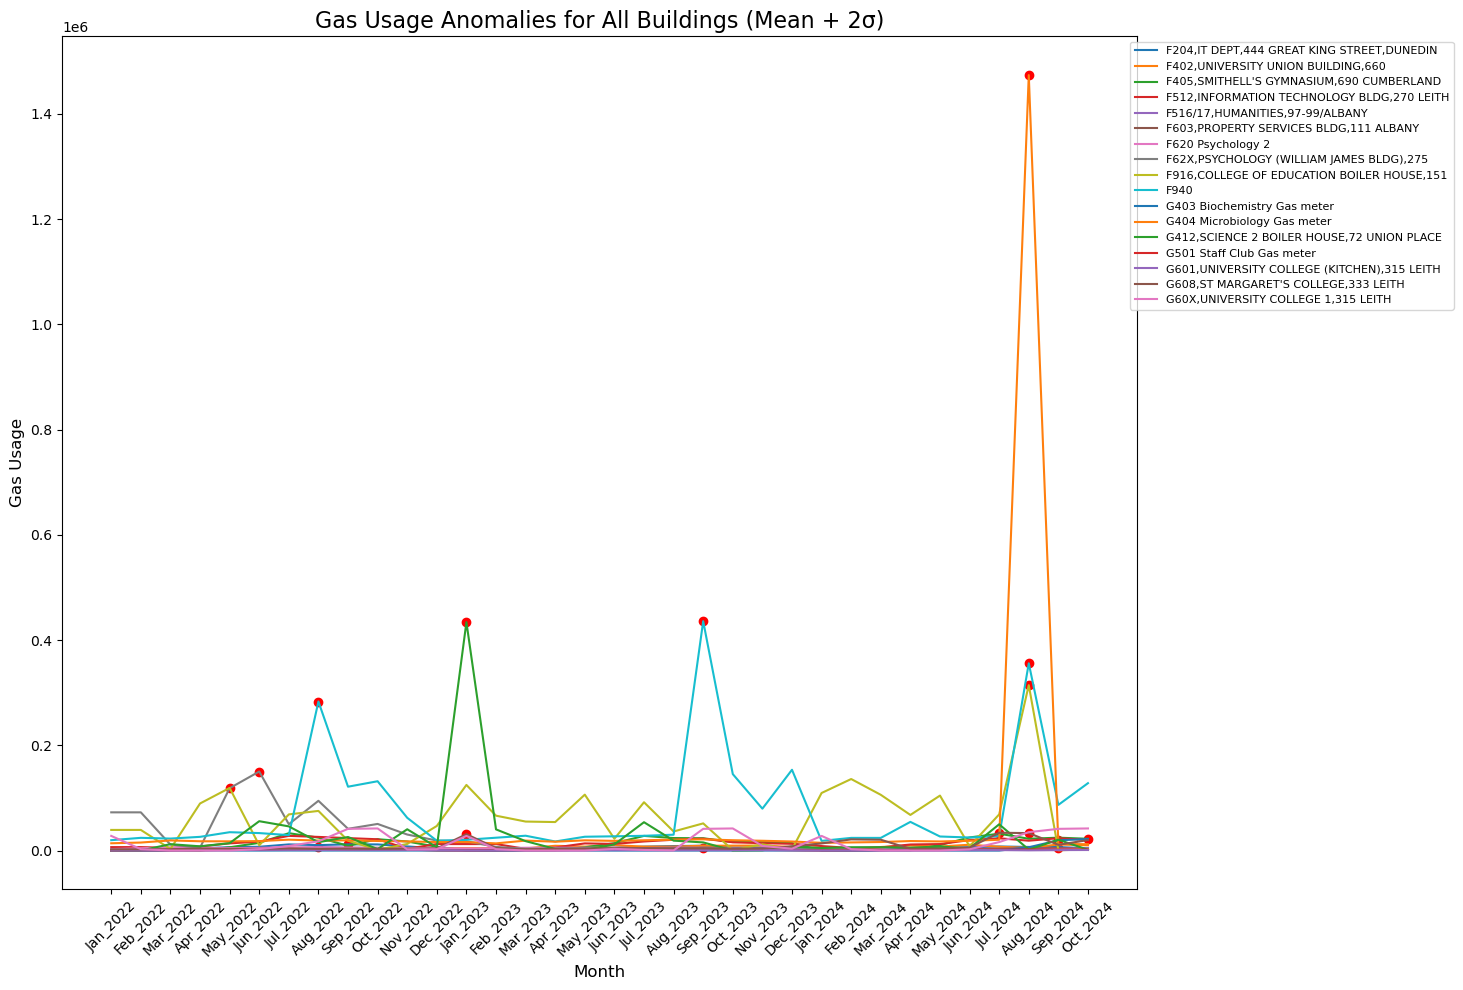

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'imputed_modelling_gas_data.csv'
data = pd.read_csv(file_path)

# Transpose the data for easier handling of time-series (excluding the Meter_Location column)
data.set_index('Meter_Location', inplace=True)
data_t = data.T

# Calculate mean and standard deviation for each building
mean_values = data_t.mean()
std_values = data_t.std()

# Identify anomalies (greater than Mean + 2 * Std Dev)
anomalies = {}
for building in data_t.columns:
    anomalies[building] = data_t[building][data_t[building] > (mean_values[building] + 2 * std_values[building])]

# Plotting
plt.figure(figsize=(15, 10))

for building in data_t.columns:
    # Plot the gas usage for each building
    plt.plot(data_t.index, data_t[building], label=building)

    # Highlight anomalies with red dots
    plt.scatter(anomalies[building].index, anomalies[building].values, color='red', label='_nolegend_')

# Formatting the plot
plt.title('Gas Usage Anomalies for All Buildings (Mean + 2σ)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Gas Usage', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


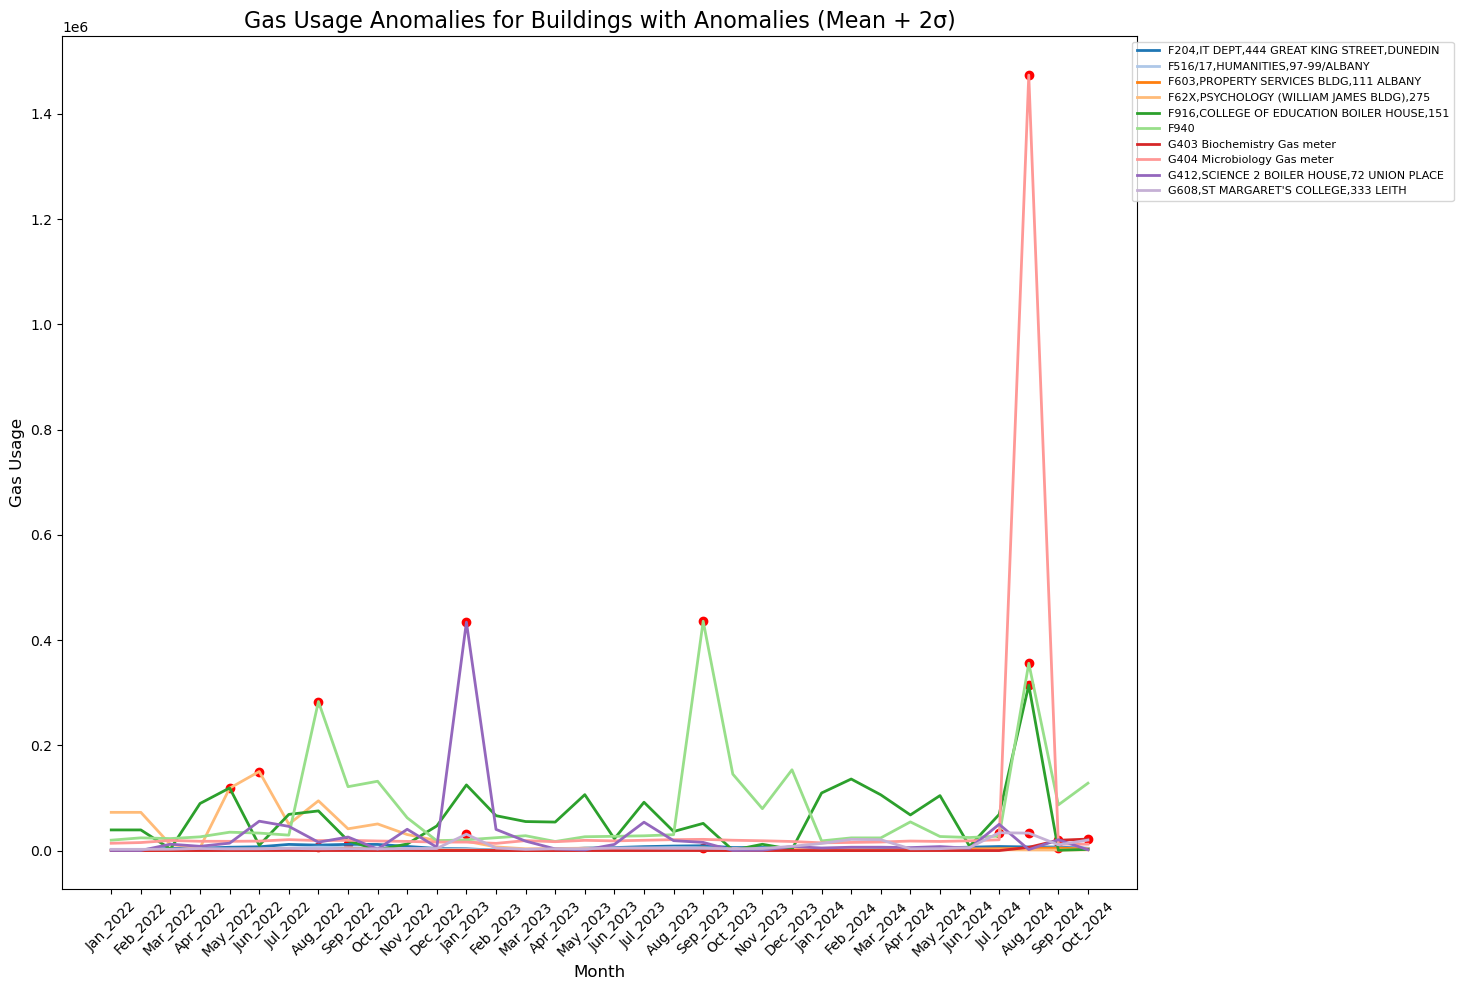

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'imputed_modelling_gas_data.csv'
data = pd.read_csv(file_path)

# Transpose the data for easier handling of time-series (excluding the Meter_Location column)
data.set_index('Meter_Location', inplace=True)
data_t = data.T

# Calculate mean and standard deviation for each building
mean_values = data_t.mean()
std_values = data_t.std()

# Identify anomalies (greater than Mean + 2 * Std Dev)
anomalies = {}
buildings_with_anomalies = []  # List to track buildings with anomalies
for building in data_t.columns:
    anomalies[building] = data_t[building][data_t[building] > (mean_values[building] + 2 * std_values[building])]
    if not anomalies[building].empty:  # Check if there are any anomalies
        buildings_with_anomalies.append(building)

# Plotting only buildings with anomalies and using bold colors for trends
plt.figure(figsize=(15, 10))

colors = plt.cm.tab20.colors  # Use a colormap for bold colors
for idx, building in enumerate(buildings_with_anomalies):
    # Plot the gas usage for each building with a bold color
    plt.plot(data_t.index, data_t[building], label=building, color=colors[idx % len(colors)], linewidth=2)

    # Highlight anomalies with red dots
    plt.scatter(anomalies[building].index, anomalies[building].values, color='red', label='_nolegend_')

# Formatting the plot
plt.title('Gas Usage Anomalies for Buildings with Anomalies (Mean + 2σ)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Gas Usage', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


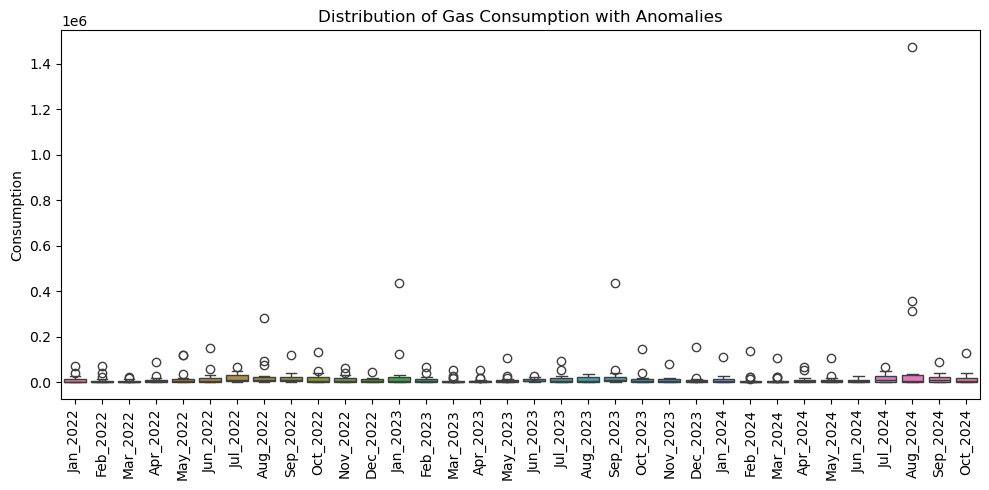


Major Anomalies Detected:

Building F62X:
Jun_2022: 150219 (Z-score: 3.44)

Building F916:
Aug_2024: 314414 (Z-score: 4.20)

Building F940:
Sep_2023: 435902 (Z-score: 3.66)

Building G403 Biochemistry Gas meter:
Sep_2024: 19617 (Z-score: 3.68)
Oct_2024: 21852 (Z-score: 4.13)

Building G404 Microbiology Gas meter:
Aug_2024: 1473714 (Z-score: 5.74)

Building G412:
Jan_2023: 434060 (Z-score: 5.59)


TypeError: unsupported format string passed to Series.__format__

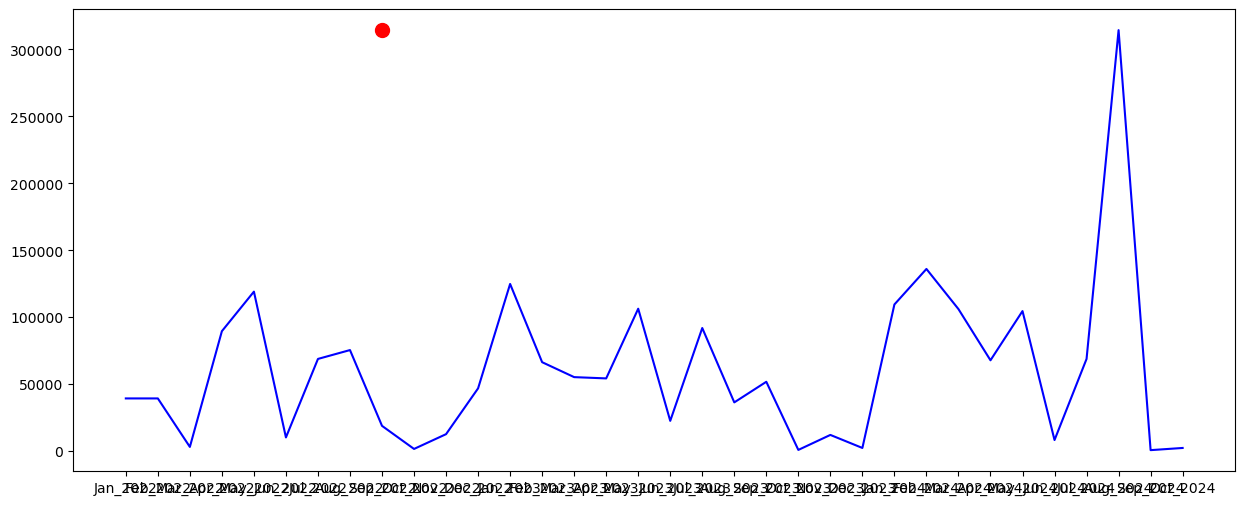

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Read the data
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Function to detect anomalies using Z-score method
def detect_anomalies_with_labels(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    anomalies_df = pd.DataFrame(index=df.index)
    
    for col in numeric_cols:
        z_scores = np.abs(stats.zscore(df[col]))
        anomalies_df[col] = z_scores > 3
    
    return anomalies_df

# Create visualization function
def plot_building_consumption(df, building_code):
    plt.figure(figsize=(15, 6))
    
    # Get data for specific building
    building_data = df[df['Meter_Location'].str.contains(building_code)].iloc[:, 1:].T
    
    # Plot consumption
    plt.plot(building_data.index, building_data.values, 'b-', label='Consumption')
    
    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(building_data.values.flatten()))
    anomalies = building_data[z_scores > 3]
    
    # Plot and label anomalies
    for idx, value in anomalies.items():
        plt.scatter(idx, value, color='red', s=100)
        plt.annotate(f'{building_code}\n{value:.0f}', 
                    (idx, value),
                    xytext=(10, 10),
                    textcoords='offset points',
                    bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title(f'Gas Consumption Anomalies for Building {building_code}')
    plt.xticks(rotation=45)
    plt.ylabel('Consumption')
    plt.legend(['Normal', 'Anomaly'])
    plt.tight_layout()
    plt.show()

# Plot overall distribution with anomalies
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.iloc[:, 1:])
plt.xticks(rotation=90)
plt.title('Distribution of Gas Consumption with Anomalies')
plt.ylabel('Consumption')
plt.tight_layout()
plt.show()

# Print summary of major anomalies
print("\nMajor Anomalies Detected:")
for index, row in df.iterrows():
    building_code = row['Meter_Location'].split(',')[0]
    data = row.iloc[1:].astype(float)
    z_scores = np.abs(stats.zscore(data))
    anomalies = data[z_scores > 3]
    
    if len(anomalies) > 0:
        print(f"\nBuilding {building_code}:")
        for month, value in anomalies.items():
            print(f"{month}: {value:.0f} (Z-score: {z_scores[month]:.2f})")

# Example usage for specific buildings with known anomalies
buildings_to_plot = ['F916', 'G404', 'F940', 'G412']
for building in buildings_to_plot:
    plot_building_consumption(df, building)



In [156]:
import pandas as pd
import numpy as np

# Read the data
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Function to calculate mean statistics for each building
def calculate_building_stats(df):
    # Create empty lists to store results
    building_stats = []
    
    # Loop through each row
    for index, row in df.iterrows():
        # Get building code and name
        location_info = row['Meter_Location'].split(',')[0]
        
        # Calculate statistics for consumption values (excluding Meter_Location column)
        consumption_values = row.iloc[1:].astype(float)
        
        stats = {
            'Building_Code': location_info,
            'Mean_Consumption': consumption_values.mean(),
            'Max_Consumption': consumption_values.max(),
            'Min_Consumption': consumption_values.min(),
            'Std_Dev': consumption_values.std()
        }
        
        building_stats.append(stats)
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(building_stats)
    
    # Round values for better readability
    stats_df = stats_df.round(2)
    
    return stats_df

# Calculate and display statistics
building_stats = calculate_building_stats(df)

# Sort by mean consumption for better visualization
building_stats_sorted = building_stats.sort_values('Mean_Consumption', ascending=False)

# Display results
print("\nBuilding Statistics Summary:")
print("=" * 30)
print(building_stats_sorted)

# Additional summary statistics
print("\nOverall Summary:")
print("=" * 30)
print(f"Building with highest mean consumption: {building_stats_sorted.iloc[0]['Building_Code']}")
print(f"Building with lowest mean consumption: {building_stats_sorted.iloc[-1]['Building_Code']}")



Building Statistics Summary:
                  Building_Code  Mean_Consumption  Max_Consumption  Min_Consumption   Std_Dev
9                          F940          76340.87        435901.71         17271.60  99586.29
8                          F916          60759.58        314414.00           613.00  61338.04
11  G404 Microbiology Gas meter          60382.65       1473713.81         12143.30 249740.17
12                         G412          27714.37        434059.75           148.92  73721.51
7                          F62X          23361.86        150218.72           906.00  37479.09
3                          F512          14248.67         27969.03          3283.57   7002.58
16                         G60X          13140.76         42049.00             0.00  16426.30
2                          F405          12307.08         33051.58             0.00  10943.72
15                         G608           8389.67         33903.00          2364.47   9271.37
1                          F40

In [158]:
import pandas as pd
import numpy as np

# Read the data
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Function to calculate statistics for each building
def calculate_building_stats(df):
    # Create empty lists to store results
    building_stats = []
    
    # Loop through each row
    for index, row in df.iterrows():
        # Get building code and name
        location_info = row['Meter_Location'].split(',')[0]
        
        # Calculate statistics for consumption values (excluding Meter_Location column)
        consumption_values = row.iloc[1:].astype(float)
        
        stats = {
            'Building_Code': location_info,
            'Mean_Consumption': consumption_values.mean(),
            'Max_Consumption': consumption_values.max(),
            'Min_Consumption': consumption_values.min(),
            'Std_Dev': consumption_values.std(),
            '25th_Percentile': np.percentile(consumption_values, 25),
            '50th_Percentile': np.percentile(consumption_values, 50),
            '75th_Percentile': np.percentile(consumption_values, 75)
        }
        
        building_stats.append(stats)
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(building_stats)
    
    # Round values for better readability
    stats_df = stats_df.round(2)
    
    return stats_df

# Calculate and display statistics
building_stats = calculate_building_stats(df)

# Sort by mean consumption for better visualization
building_stats_sorted = building_stats.sort_values('Mean_Consumption', ascending=False)

# Display results
print("\nBuilding Statistics Summary:")
print("=" * 30)
print(building_stats_sorted)

# Additional summary statistics
print("\nOverall Summary:")
print("=" * 30)
print(f"Building with highest mean consumption: {building_stats_sorted.iloc[0]['Building_Code']}")
print(f"Building with lowest mean consumption: {building_stats_sorted.iloc[-1]['Building_Code']}")



Building Statistics Summary:
                  Building_Code  Mean_Consumption  Max_Consumption  Min_Consumption   Std_Dev  25th_Percentile  50th_Percentile  75th_Percentile
9                          F940          76340.87        435901.71         17271.60  99586.29         24275.77         28144.54         85076.47
8                          F916          60759.58        314414.00           613.00  61338.04         12122.90         52947.63         91260.60
11  G404 Microbiology Gas meter          60382.65       1473713.81         12143.30 249740.17         16184.79         18056.75         19420.70
12                         G412          27714.37        434059.75           148.92  73721.51          3483.76          7880.23         20212.48
7                          F62X          23361.86        150218.72           906.00  37479.09          1929.25          4154.50         27639.75
3                          F512          14248.67         27969.03          3283.57   7002.58       

In [44]:
import pandas as pd
import numpy as np

# Read the data
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Function to calculate mean statistics for each building
def calculate_building_stats(df):
    building_stats = []
    
    for index, row in df.iterrows():
        location_info = row['Meter_Location'].split(',')[0]
        consumption_values = row.iloc[1:].astype(float)
        
        stats = {
            'Building_Code': location_info,
            'Building_Name': ','.join(row['Meter_Location'].split(',')[1:]).strip(),
            'Mean_Consumption': consumption_values.mean(),
            'Max_Consumption': consumption_values.max(),
            'Min_Consumption': consumption_values.min(),
            'Std_Dev': consumption_values.std(),
            'Median_Consumption': consumption_values.median()
        }
        
        building_stats.append(stats)
    
    stats_df = pd.DataFrame(building_stats)
    stats_df = stats_df.round(2)
    return stats_df

# Calculate statistics
building_stats = calculate_building_stats(df)

# Sort by mean consumption
building_stats_sorted = building_stats.sort_values('Mean_Consumption', ascending=False)

# Export to Excel
building_stats_sorted.to_excel('building_gas_statistics.xlsx', index=False, sheet_name='Building Statistics')

print("Statistics have been exported to 'building_gas_statistics.xlsx'")


Statistics have been exported to 'building_gas_statistics.xlsx'


ValueError: num must be an integer with 1 <= num <= 16, not 17

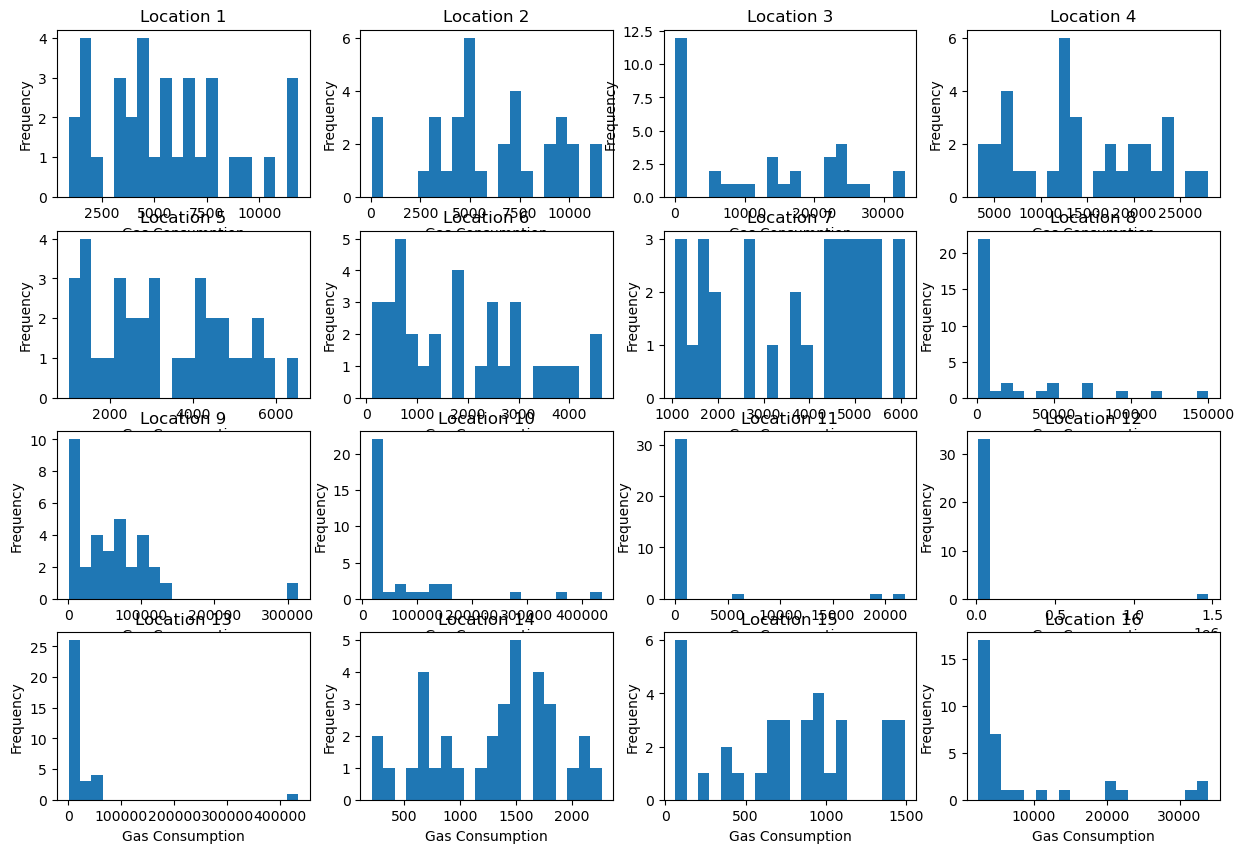

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Create subplots for each location
plt.figure(figsize=(15, 10))
for i, location in enumerate(df['Meter_Location']):
    plt.subplot(4, 4, i+1)
    values = df.iloc[i, 1:].values
    plt.hist(values, bins=20)
    plt.title(f'Location {i+1}')
    plt.xlabel('Gas Consumption')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


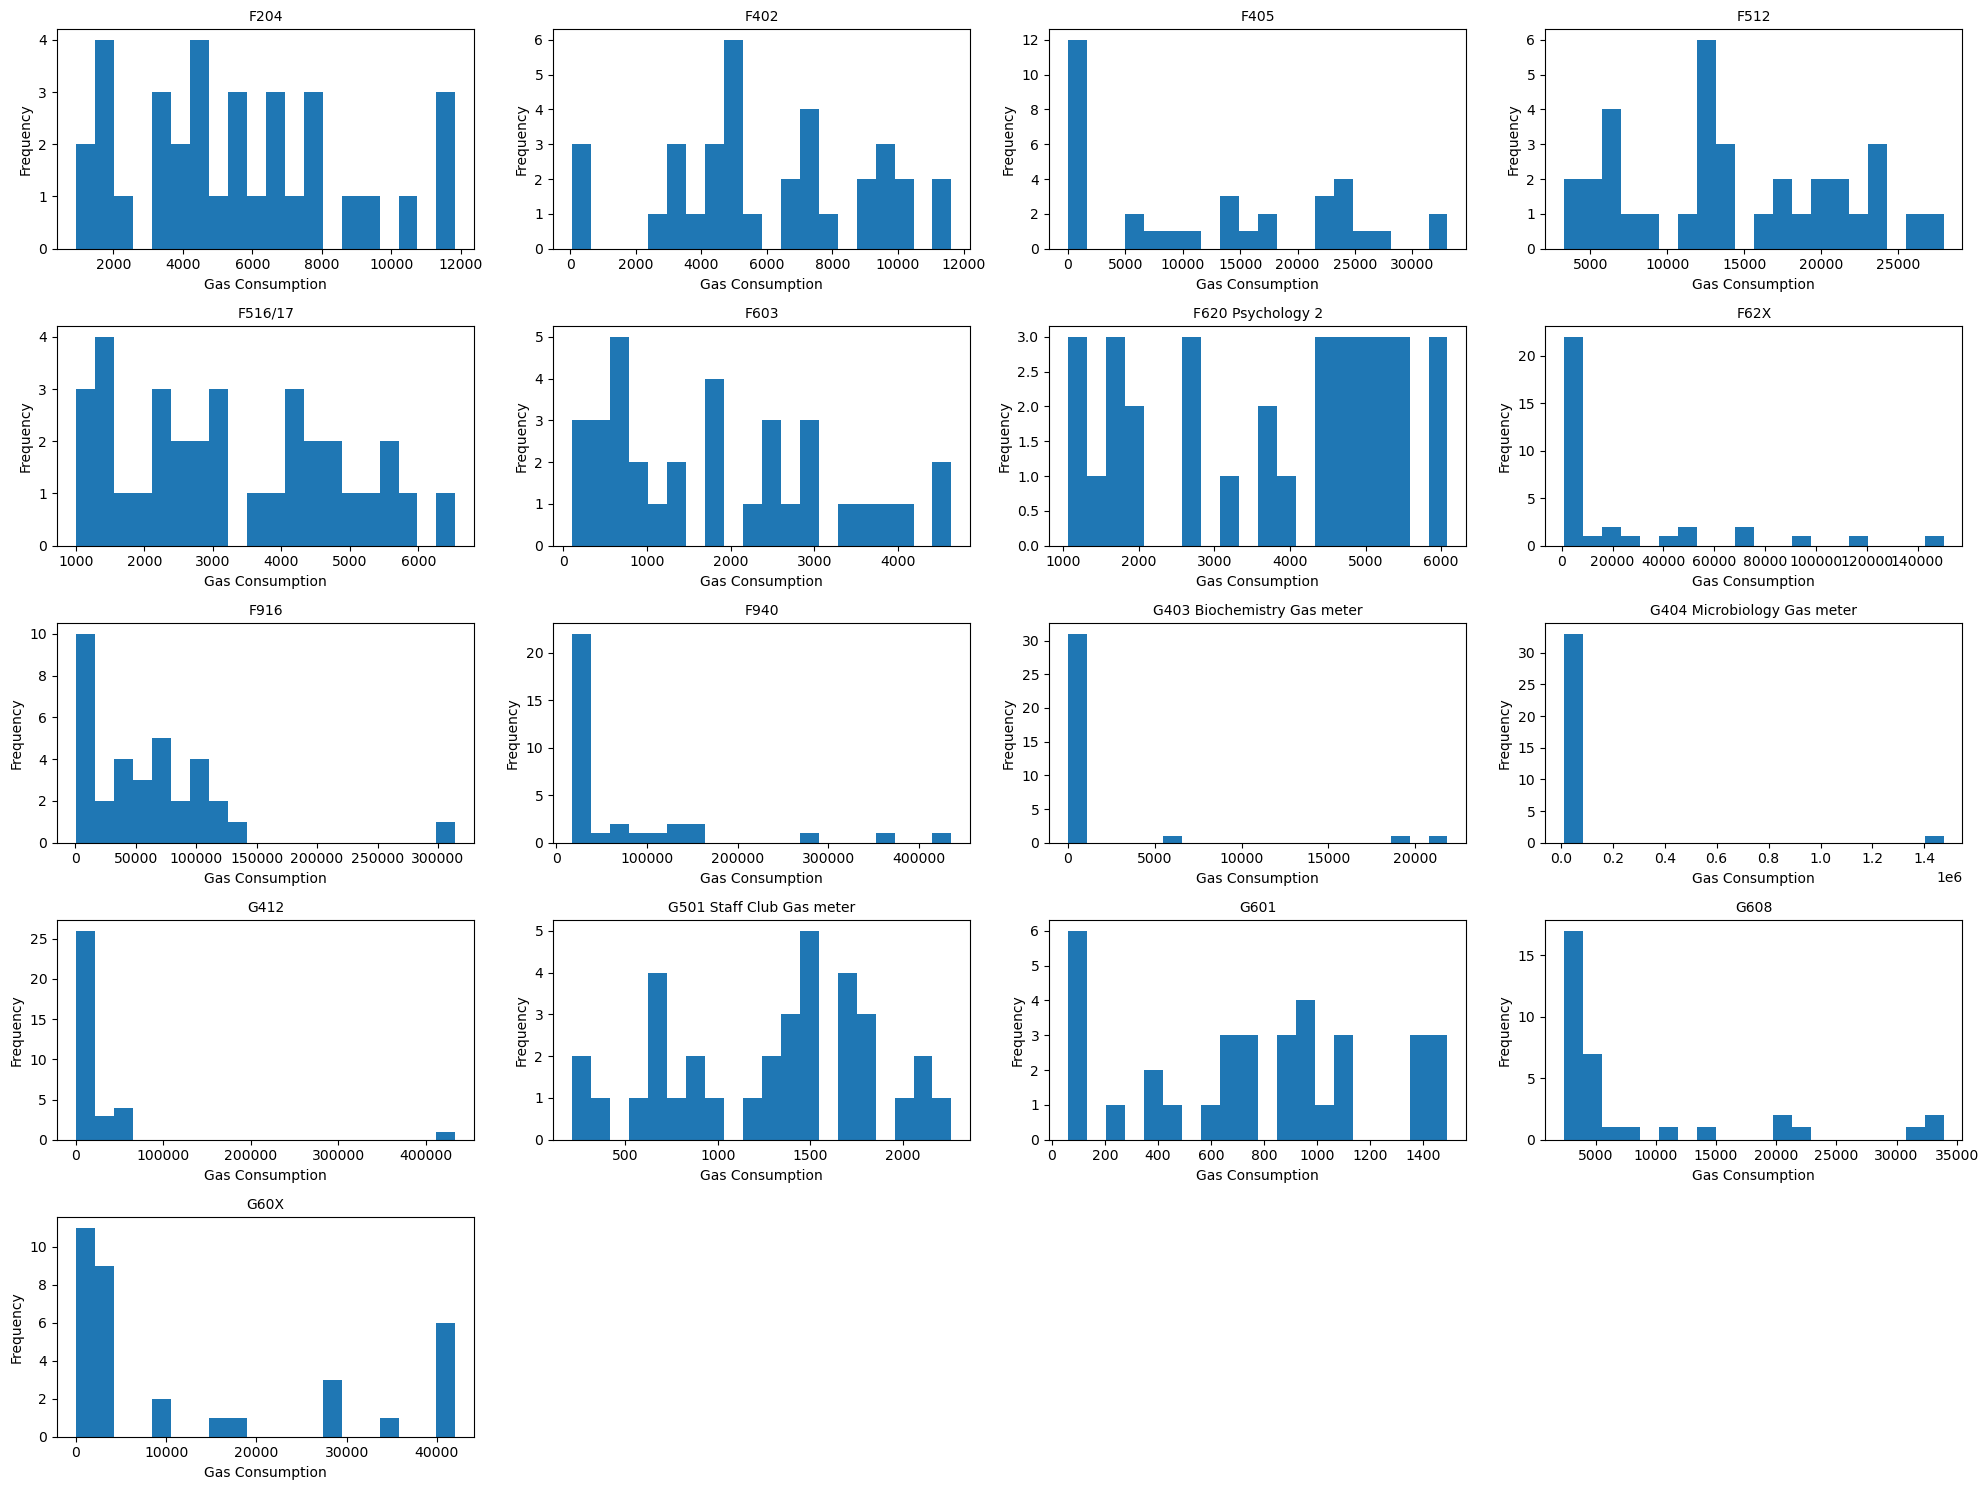

In [50]:
plt.figure(figsize=(20, 15))
for i, location in enumerate(df['Meter_Location']):
    plt.subplot(5, 4, i+1)
    values = df.iloc[i, 1:].values
    plt.hist(values, bins=20)
    # Extract building code from the location string
    building_code = location.split(',')[0]  # This will get F204, F402, etc.
    plt.title(f'{building_code}', fontsize=10)
    plt.xlabel('Gas Consumption')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



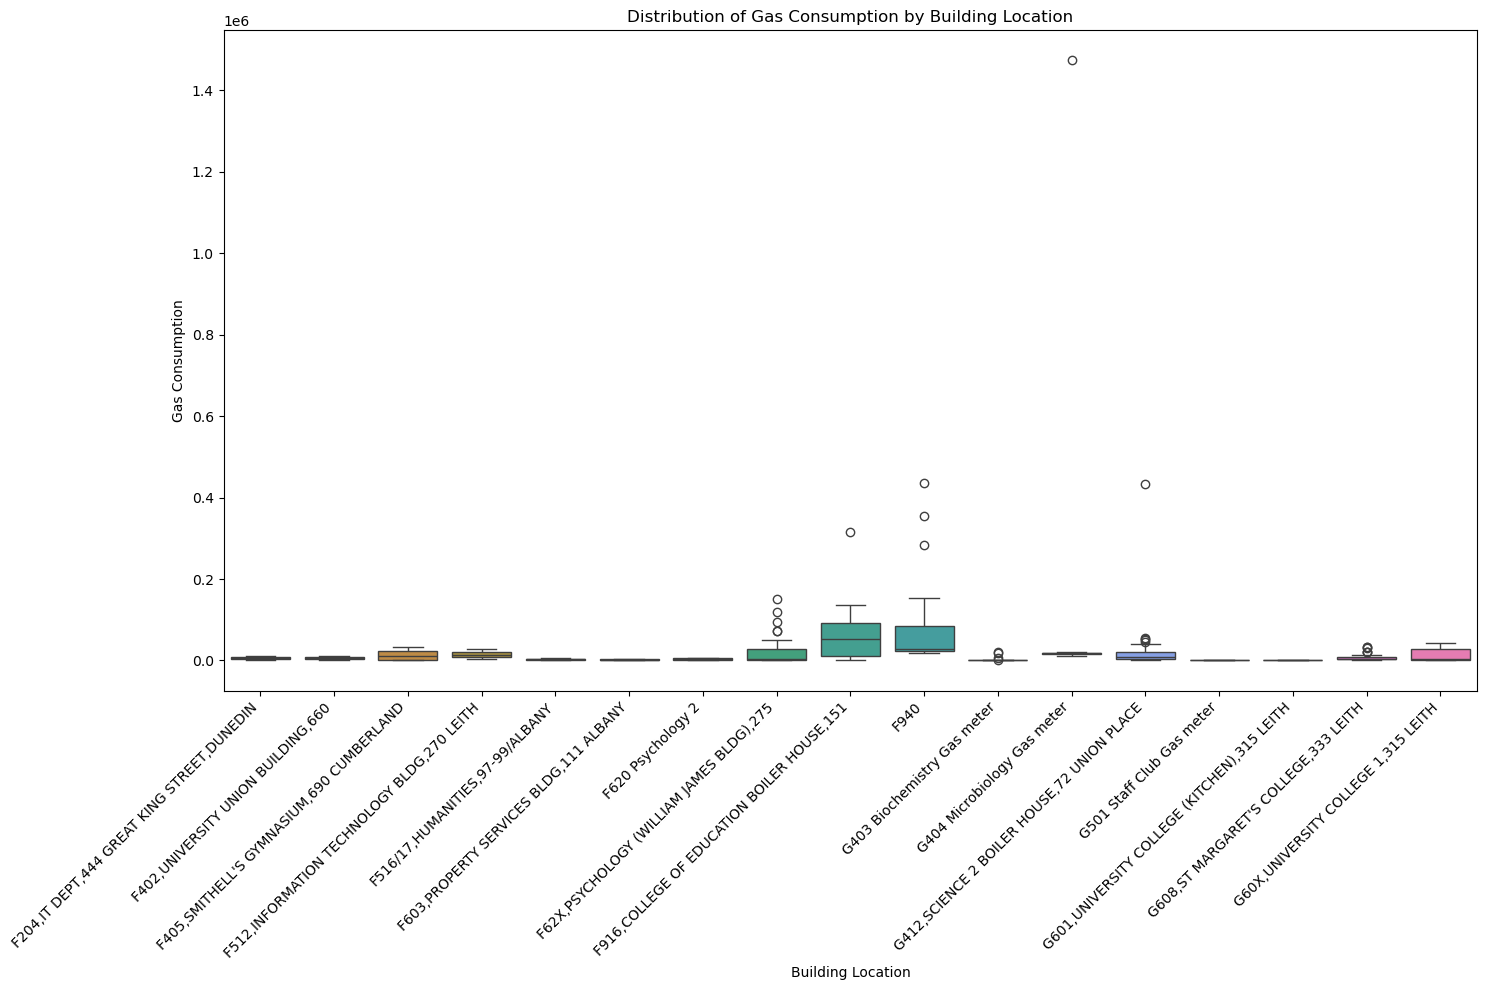

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with larger size for better visibility
plt.figure(figsize=(15, 10))

# Transpose the dataframe to get consumption values for each location
df_transposed = df.set_index('Meter_Location').T

# Create box plot
sns.boxplot(data=df_transposed)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Building Location')
plt.ylabel('Gas Consumption')
plt.title('Distribution of Gas Consumption by Building Location')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


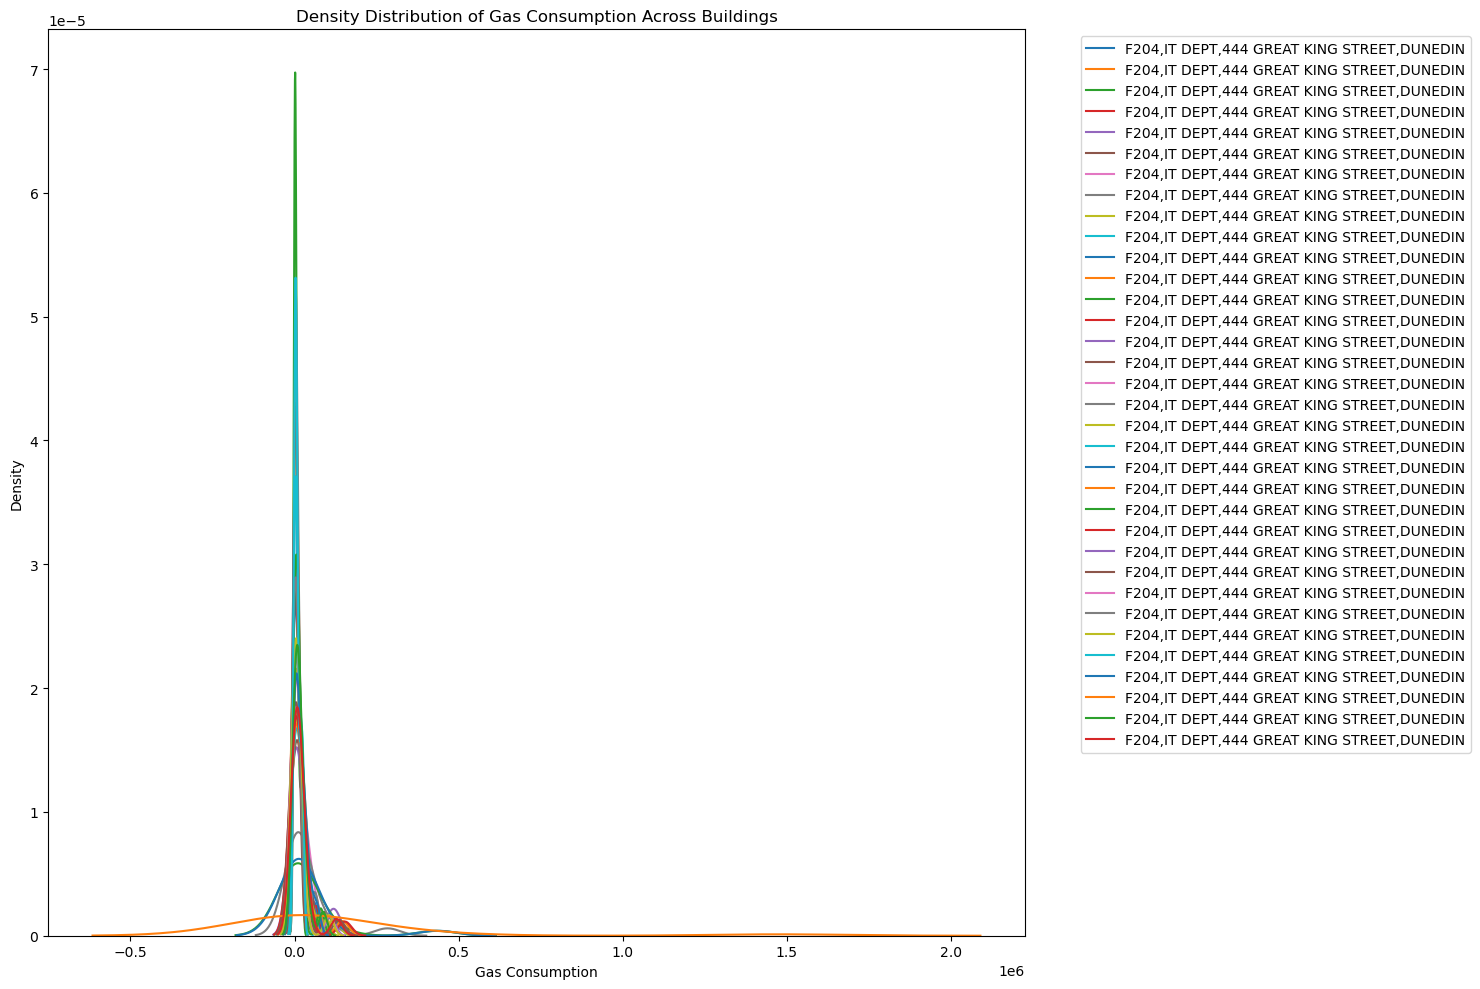

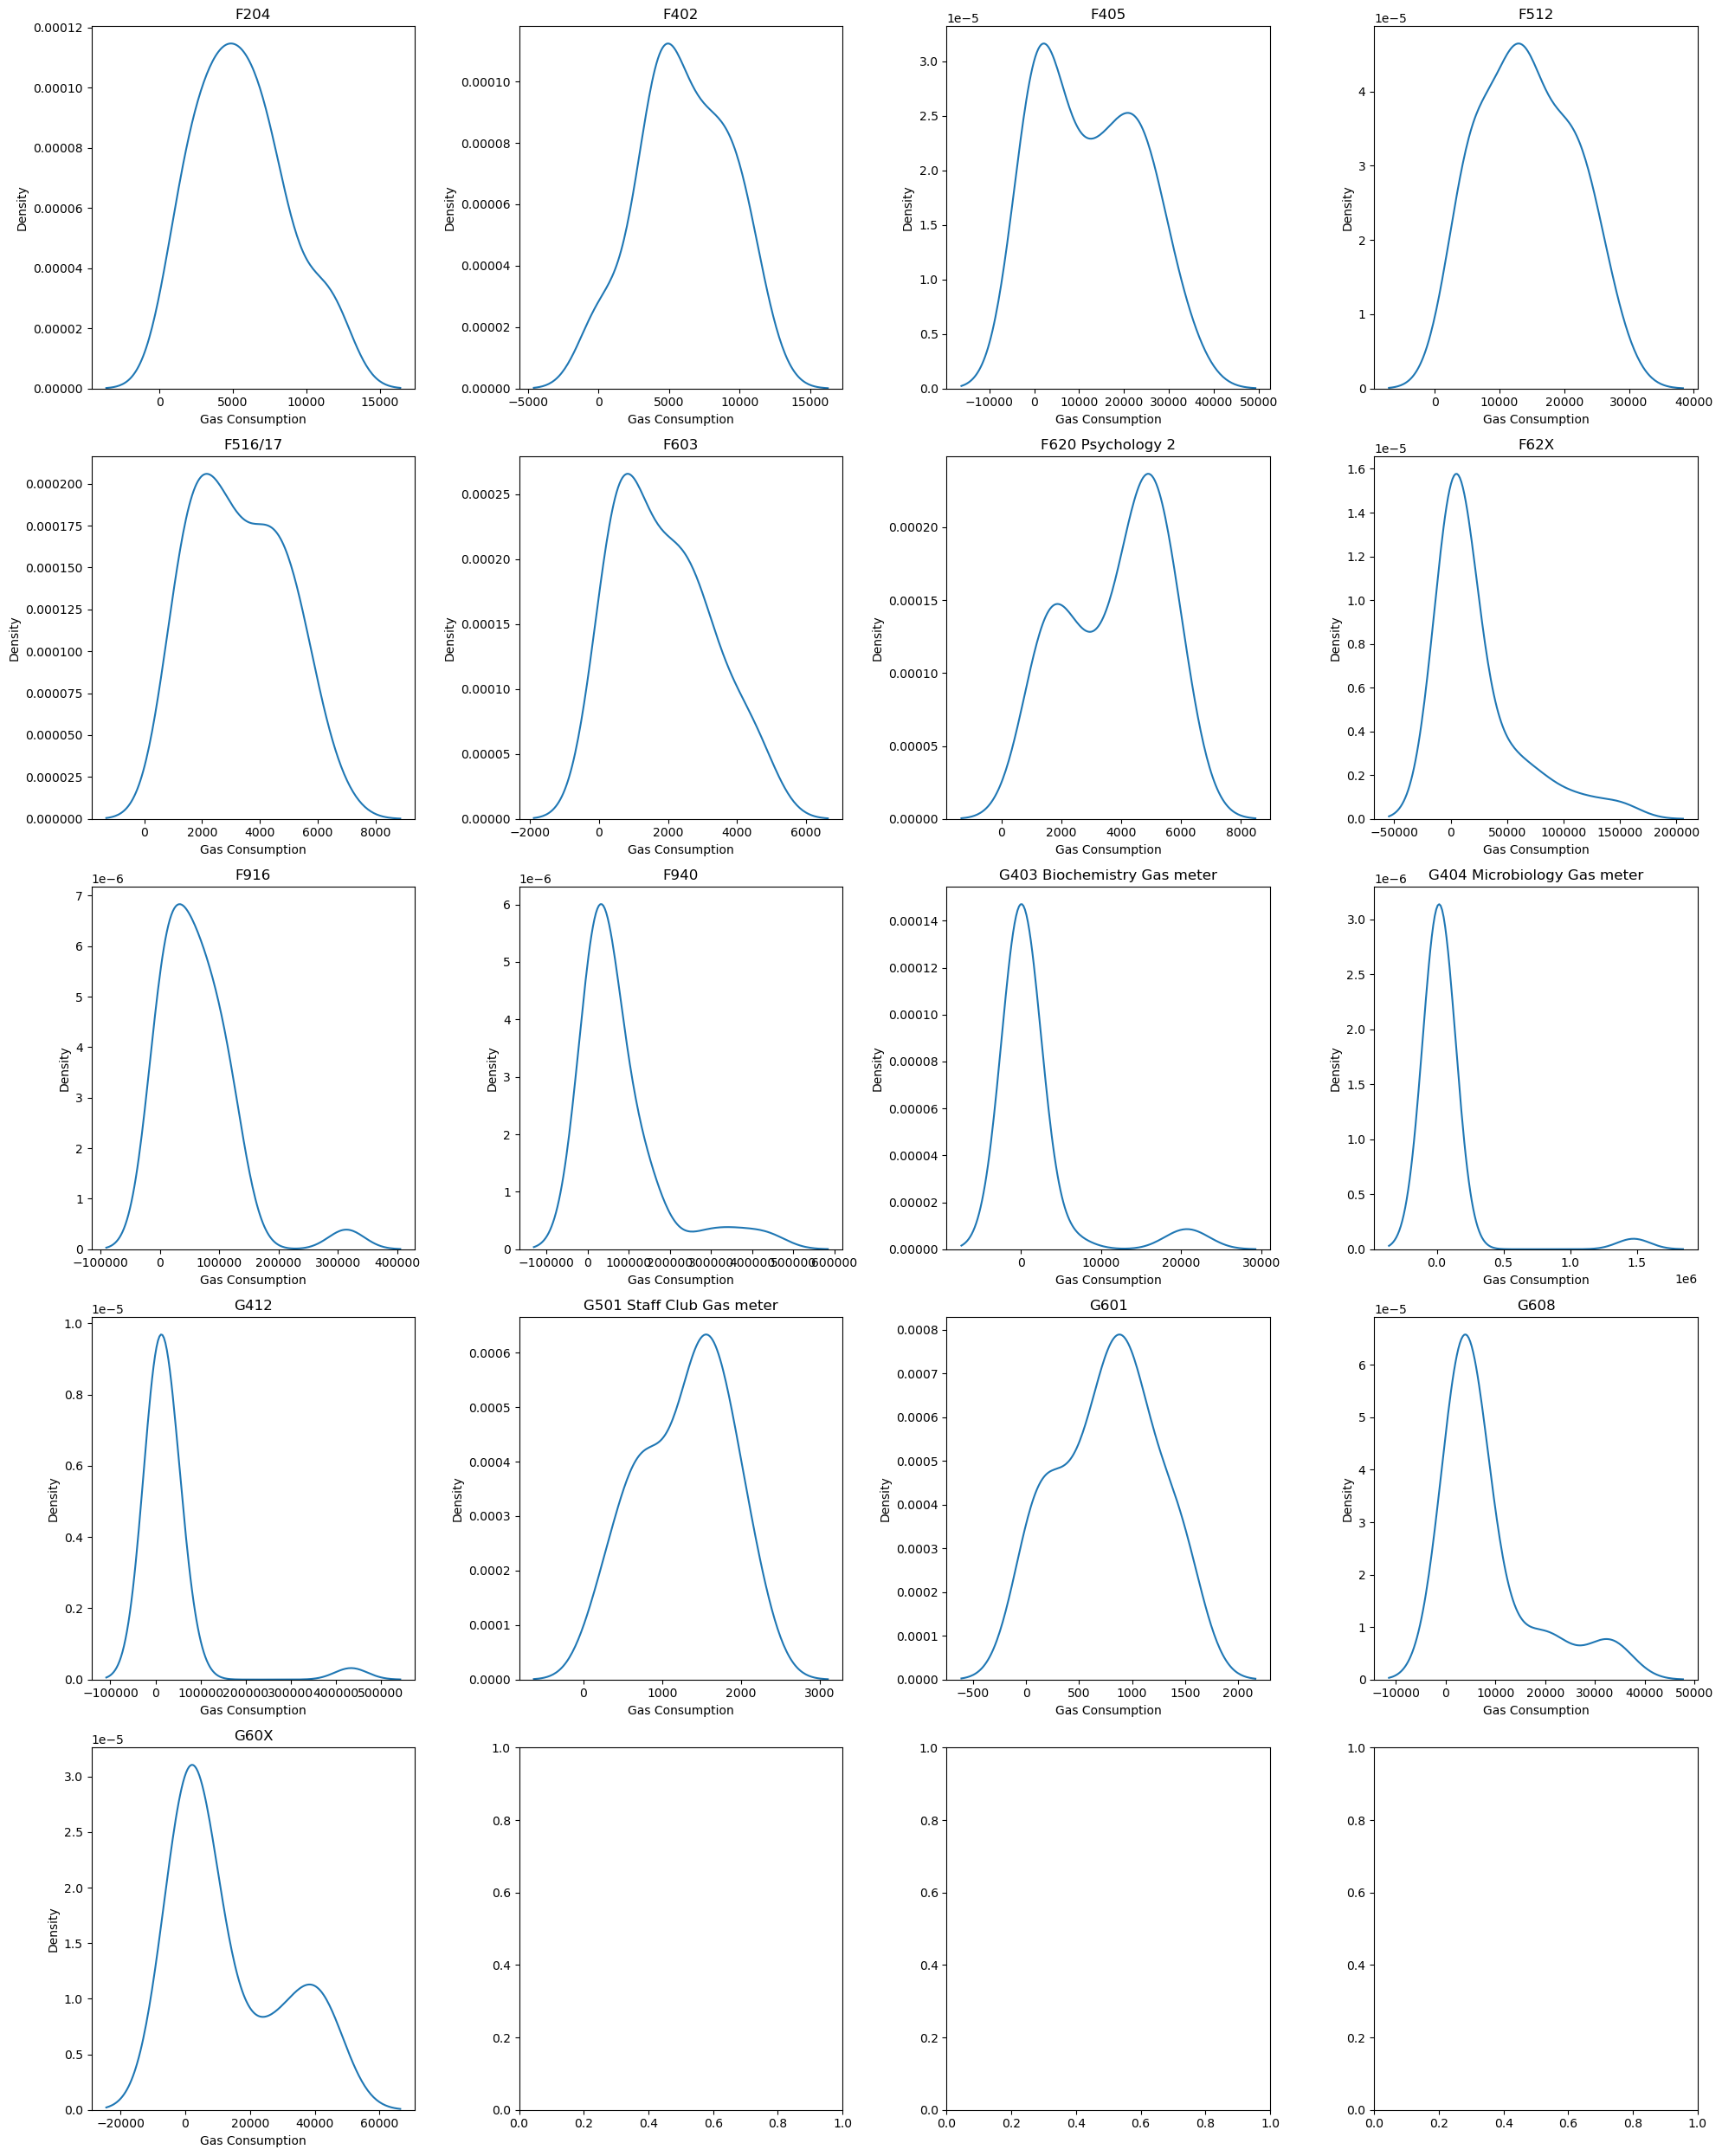

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a larger figure
plt.figure(figsize=(15, 10))

# Create density plots for each location
for column in df.columns[1:]:  # Skip the Meter_Location column
    sns.kdeplot(data=df[column], label=df['Meter_Location'].iloc[0])

# Customize the plot
plt.title('Density Distribution of Gas Consumption Across Buildings')
plt.xlabel('Gas Consumption')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Alternative: Create subplots for clearer visualization
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.ravel()

for idx, location in enumerate(df['Meter_Location']):
    values = df.iloc[idx, 1:].values
    sns.kdeplot(data=values, ax=axes[idx])
    axes[idx].set_title(f'{location.split(",")[0]}')
    axes[idx].set_xlabel('Gas Consumption')
    axes[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()


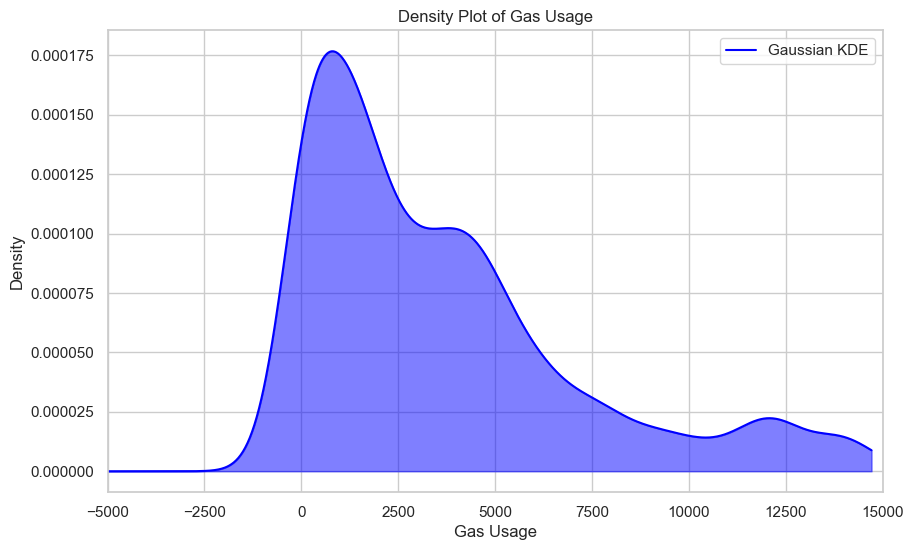

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load the dataset
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Reshape the dataset to long format
df_long = df.melt(id_vars='Meter_Location', var_name='Month', value_name='Gas_Usage')

# Filter the data to focus on a specific range (e.g., gas usage below 15,000 for better scaling)
filtered_data = df_long[df_long['Gas_Usage'] <= 15000]

# Create a smoother density plot using Gaussian KDE
kde = gaussian_kde(filtered_data['Gas_Usage'], bw_method=0.2)  # Adjust bandwidth for smoothness
x_vals = np.linspace(-5000, filtered_data['Gas_Usage'].max(), 1000)  # Include negative values in x-axis

# Plot the density
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde(x_vals), label='Gaussian KDE', color='blue')
plt.fill_between(x_vals, kde(x_vals), alpha=0.5, color='blue')
plt.title('Density Plot of Gas Usage')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.xlim(-5000, 15000)  # Set x-axis limit to include negative values
plt.grid(True)
plt.legend()
plt.show()




In [58]:
import pandas as pd
import numpy as np

# Calculate skewness and kurtosis for each building
results = []
for idx, row in df.iterrows():
    building_code = row['Meter_Location'].split(',')[0]
    consumption_values = row.iloc[1:].values
    
    skewness = pd.Series(consumption_values).skew()
    kurtosis = pd.Series(consumption_values).kurtosis()
    
    results.append({
        'Building': building_code,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    })

results_df = pd.DataFrame(results)


In [60]:
results_df

Building  Skewness   Kurtosis
0                          F204  0.494852  -0.445223
1                          F402 -0.154052  -0.594931
2                          F405  0.281201  -1.327456
3                          F512  0.157016  -1.015392
4                       F516/17  0.253064  -1.053369
5                          F603  0.542073  -0.731439
6             F620 Psychology 2 -0.369575  -1.326289
7                          F62X  2.053723   3.778166
8                          F916  2.196512   7.810349
9                          F940  2.457532   5.906775
10  G403 Biochemistry Gas meter  3.708672  12.987259
11  G404 Microbiology Gas meter  5.830140  33.993509
12                         G412  5.374772  30.269137
13    G501 Staff Club Gas meter -0.275659  -0.895718
14                         G601 -0.118117  -0.972628
15                         G608  1.883649   2.394430
16                         G60X  0.910150  -0.911972

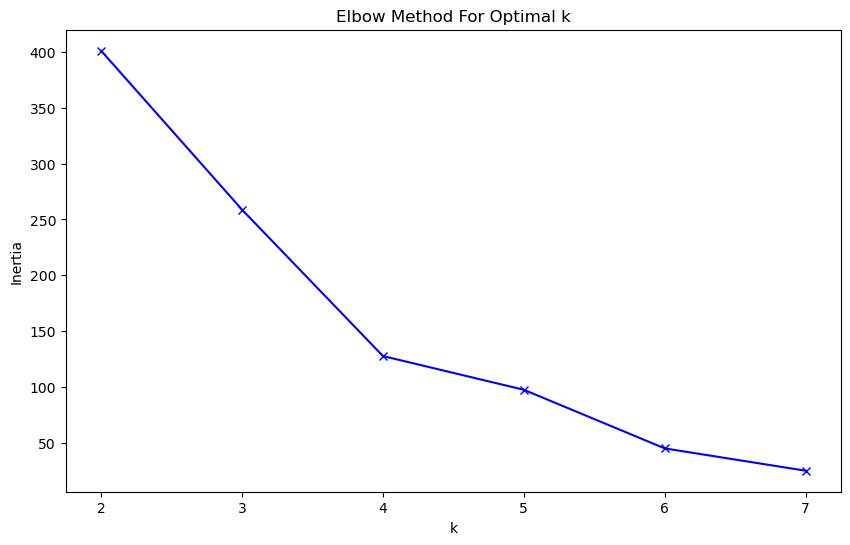

                       Building  Cluster
0                          F204        0
1                          F402        0
2                          F405        0
3                          F512        0
4                       F516/17        0
5                          F603        0
6             F620 Psychology 2        0
7                          F62X        2
8                          F916        2
9                          F940        1
10  G403 Biochemistry Gas meter        0
11  G404 Microbiology Gas meter        2
12                         G412        2
13    G501 Staff Club Gas meter        0
14                         G601        0
15                         G608        0
16                         G60X        0


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Prepare data for clustering
X = df.iloc[:, 1:].values  # Select all columns except Meter_Location
building_names = df['Meter_Location'].apply(lambda x: x.split(',')[0]).values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K = range(2, 8)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Apply final clustering with optimal k
optimal_k = 3  # Based on elbow method and silhouette scores
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to results
results = pd.DataFrame({
    'Building': building_names,
    'Cluster': clusters
})
print(results)



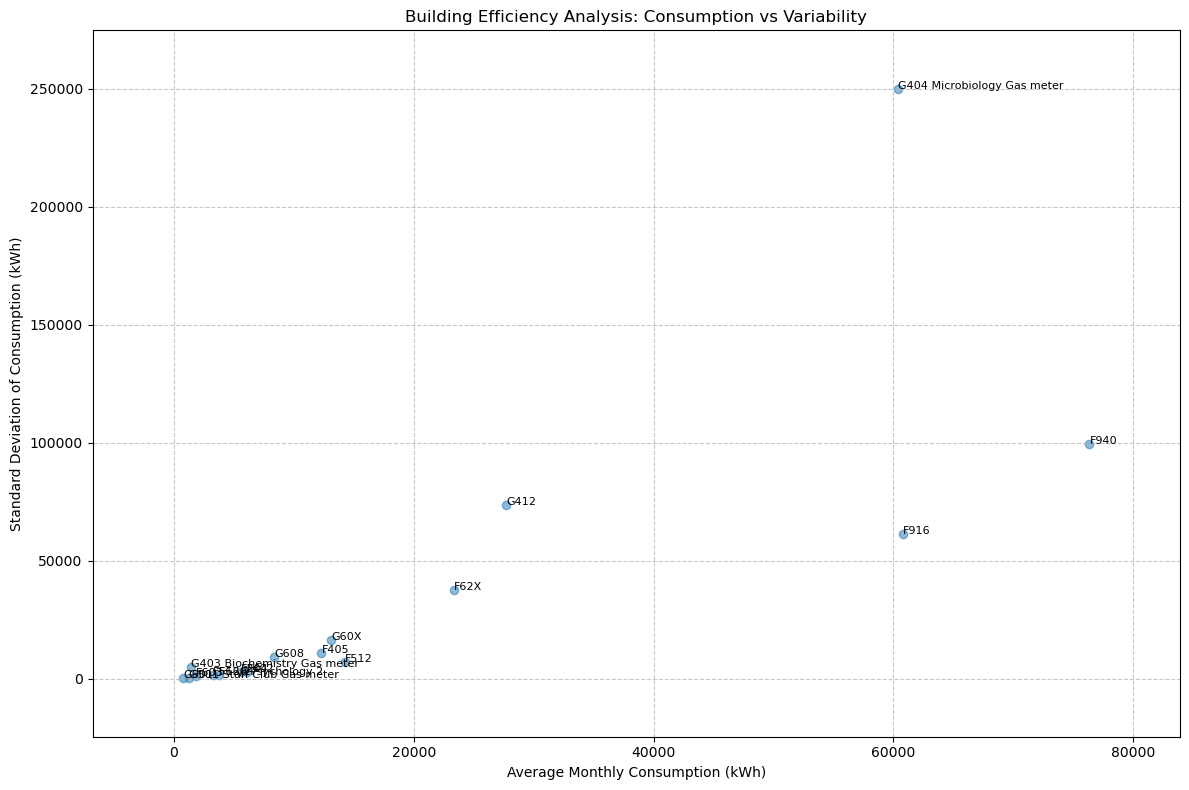

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate average and standard deviation for each building
avg_consumption = df.iloc[:, 1:].mean(axis=1)
std_consumption = df.iloc[:, 1:].std(axis=1)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(avg_consumption, std_consumption, alpha=0.5)

# Add building labels
for i, txt in enumerate(df['Meter_Location']):
    building_code = txt.split(',')[0]
    plt.annotate(building_code, (avg_consumption[i], std_consumption[i]), fontsize=8)

# Customize the plot
plt.title('Building Efficiency Analysis: Consumption vs Variability')
plt.xlabel('Average Monthly Consumption (kWh)')
plt.ylabel('Standard Deviation of Consumption (kWh)')
plt.grid(True, linestyle='--', alpha=0.7)

# Add some padding to the axes
plt.margins(0.1)

plt.tight_layout()
plt.show()


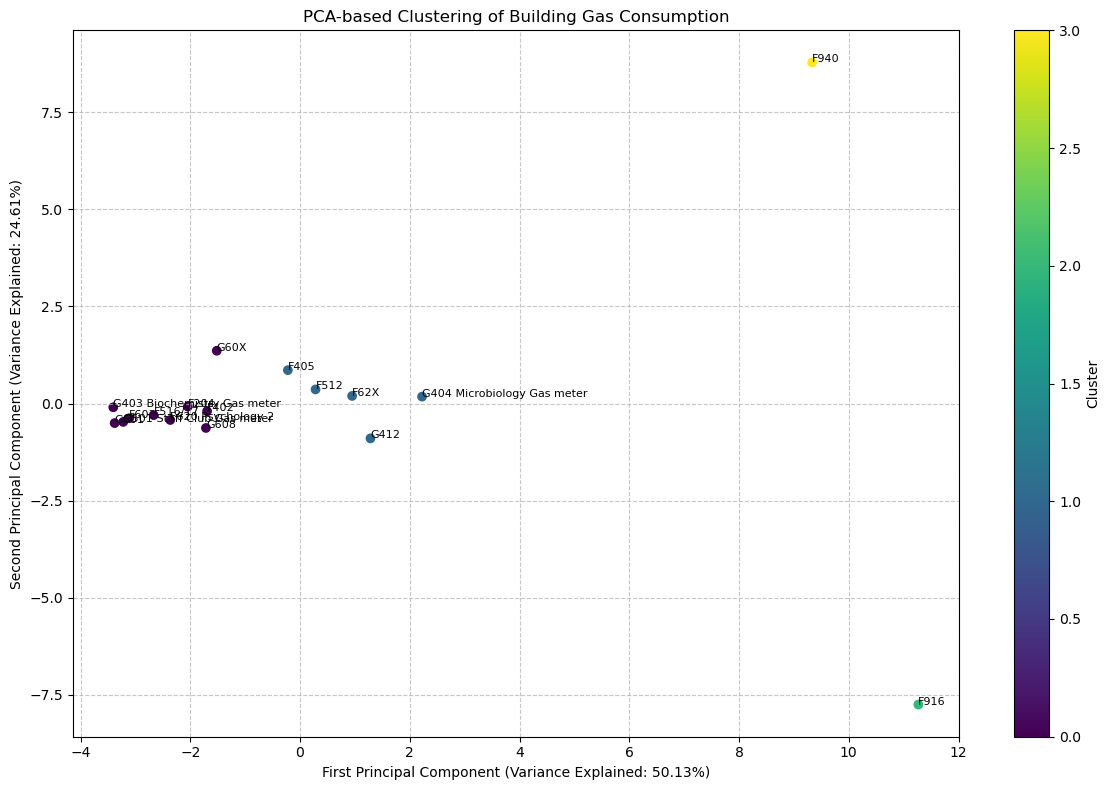

In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Prepare the data
X = df.iloc[:, 1:].values  # Select all columns except Meter_Location
building_names = df['Meter_Location'].apply(lambda x: x.split(',')[0]).values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Using 4 clusters based on elbow method
clusters = kmeans.fit_predict(X_pca)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')

# Add building labels
for i, txt in enumerate(building_names):
    plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

# Add plot details
plt.title('PCA-based Clustering of Building Gas Consumption')
plt.xlabel(f'First Principal Component (Variance Explained: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (Variance Explained: {pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Restructure gas consumption data from wide to long format
gas_df = df.melt(id_vars=['Meter_Location'], 
                 var_name='Date', 
                 value_name='Consumption')

# Extract year and month from the date column
gas_df['Year'] = gas_df['Date'].str.split('_').str[1].astype(int)
gas_df['Month'] = gas_df['Date'].str.split('_').str[0].map({
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
})

# Read weather data
weather_df = pd.read_csv('weather_monthly.csv')

# Merge with weather data
merged_df = pd.merge(gas_df, weather_df, on=['Year', 'Month'])

# Calculate correlations
correlation_matrix = merged_df[['Consumption', 'temp_mean', 'radiation_total', 
                              'humidity_mean', 'rain_total', 'avg_wind_speed',
                              'pressure_mean']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Gas Consumption and Weather Variables')
plt.tight_layout()
plt.show()



KeyError: 'Year'

In [ ]:
weather_df

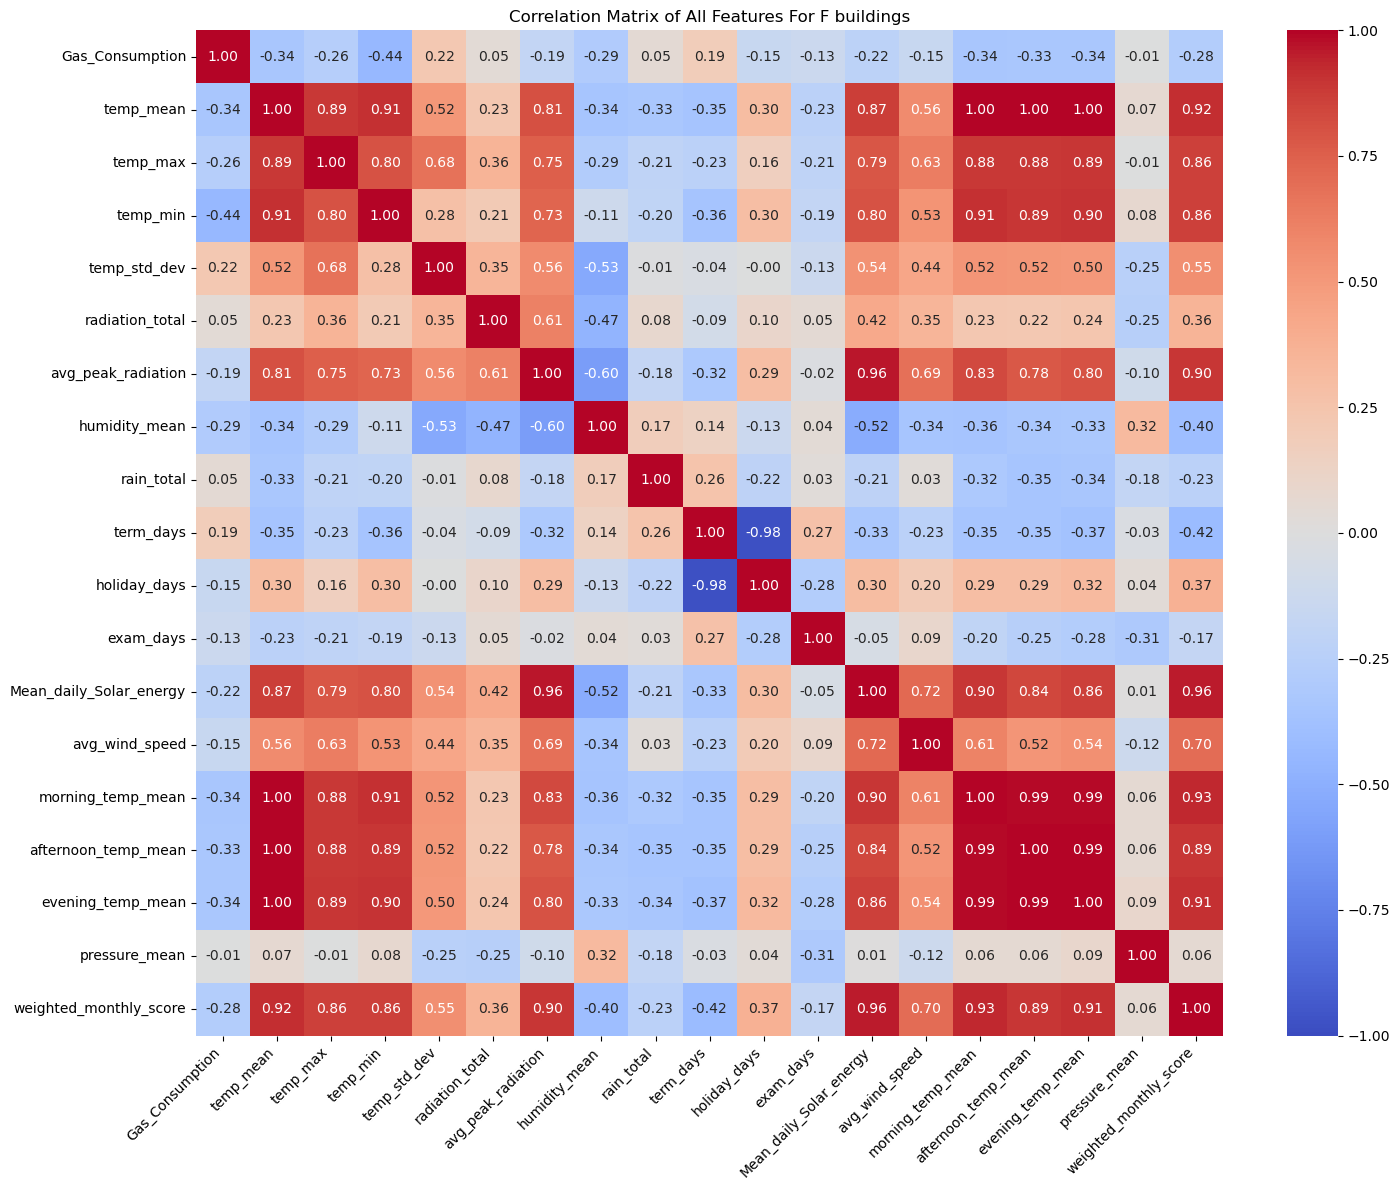

Strong Correlations with Gas_Consumption (|r| > 0.25):
temp_min                         -0.439
morning_temp_mean                -0.341
temp_mean                        -0.337
evening_temp_mean                -0.335
afternoon_temp_mean              -0.330
humidity_mean                    -0.293
weighted_monthly_score           -0.280
temp_max                         -0.258


'\nplt.figure(figsize=(15, 12))\nsns.heatmap(correlation_matrix_g, \n            annot=True, \n            cmap=\'coolwarm\', \n            vmin=-1, \n            vmax=1, \n            fmt=\'.2f\')\nplt.title(\'Correlation Matrix of All Features For G Buildings\')\nplt.xticks(rotation=45, ha=\'right\')\nplt.yticks(rotation=0)\nplt.tight_layout()\nplt.show()\n\n# Print the strongest correlations (absolute value > 0.7)\nprint("\nStrongest Correlations (|correlation| > 0.7): for G Building")\nstrong_corr_g = []\nfor i in range(len(correlation_matrix_g.columns)):\n    for j in range(i):\n        if abs(correlation_matrix_g.iloc[i,j]) > 0.7:\n            strong_corr_g.append({\n                \'Feature 1\': correlation_matrix_g.columns[i],\n                \'Feature 2\': correlation_matrix_g.columns[j],\n                \'Correlation\': correlation_matrix_g.iloc[i,j]\n            })\n\nstrong_corr_df_g = pd.DataFrame(strong_corr_g).sort_values(\'Correlation\', key=abs, ascending=False)\npr

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read both datasets
gas_df = pd.read_csv('imputed_modelling_gas_data.csv')
weather_df = pd.read_csv('weather_monthly.csv')

gas_df_f = gas_df[gas_df['Meter_Location'].str.startswith('F')]

# Filter meter locations that start with 'G'
gas_df_g = gas_df[gas_df['Meter_Location'].str.startswith('G')]
                                                          

# Melt the gas data to convert it to long format with dates
gas_melted = pd.melt(gas_df, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Gas_Consumption')

# Melt the gas data to convert it to long format with dates
gas_melted_f = pd.melt(gas_df_f, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Gas_Consumption')

# Melt the gas data to convert it to long format with dates
gas_melted_g = pd.melt(gas_df_g, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Gas_Consumption')

# Convert gas consumption to numeric
gas_melted['Gas_Consumption'] = pd.to_numeric(gas_melted['Gas_Consumption'], errors='coerce')

gas_melted_f['Gas_Consumption'] = pd.to_numeric(gas_melted_f['Gas_Consumption'], errors='coerce')

gas_melted_g['Gas_Consumption'] = pd.to_numeric(gas_melted_g['Gas_Consumption'], errors='coerce')

# Group by date to get total consumption
gas_by_date = gas_melted.groupby('Date')['Gas_Consumption'].sum().reset_index()

gas_by_date_f = gas_melted_f.groupby('Date')['Gas_Consumption'].sum().reset_index()
gas_by_date_g = gas_melted_g.groupby('Date')['Gas_Consumption'].sum().reset_index()

# Merge weather and gas consumption data
merged_df = pd.merge(gas_by_date, weather_df, on='Date', how='inner')

merged_df_f = pd.merge(gas_by_date_f, weather_df, on='Date', how='inner')

merged_df_g = pd.merge(gas_by_date_g, weather_df, on='Date', how='inner')


correlation_matrix = merged_df.drop('Date', axis=1).corr()

correlation_matrix_f = merged_df_f.drop('Date', axis=1).corr()
correlation_matrix_g = merged_df_g.drop('Date', axis=1).corr()

'''
# Create a larger correlation heatmap for all features
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f')
plt.title('Correlation Matrix of All Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the strongest correlations (absolute value > 0.7)
print("\nStrongest Correlations (|correlation| > 0.7):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.7:
            strong_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i,j]
            })

strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlation', key=abs, ascending=False)
print(strong_corr_df)
'''


plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_f, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f')
plt.title('Correlation Matrix of All Features For F buildings')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

gas_correlations_f = correlation_matrix_f['Gas_Consumption'].sort_values(key=abs, ascending=False)

# Filter for strong correlations (absolute value > 0.7)
strong_gas_correlations_f = gas_correlations_f[abs(gas_correlations_f) > 0.25]

print("Strong Correlations with Gas_Consumption (|r| > 0.25):")
print("=" * 50)
for feature, correlation in strong_gas_correlations_f.items():
    if feature != 'Gas_Consumption':  # Skip self-correlation
        print(f"{feature:<30} {correlation:>8.3f}")

'''
# Print the strongest correlations (absolute value > 0.7)
print("\nStrongest Correlations (|correlation| > 0.7) For F Buildings:")
strong_corr_f = []
for i in range(len(correlation_matrix_f.columns)):
    for j in range(i):
        if abs(correlation_matrix_f.iloc[i,j]) > 0.7:
            strong_corr_f.append({
                'Feature 1': correlation_matrix_f.columns[i],
                'Feature 2': correlation_matrix_f.columns[j],
                'Correlation': correlation_matrix_f.iloc[i,j]
            })

strong_corr_df_f = pd.DataFrame(strong_corr_f).sort_values('Correlation', key=abs, ascending=False)
print(strong_corr_df_f
'''

'''
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_g, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f')
plt.title('Correlation Matrix of All Features For G Buildings')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the strongest correlations (absolute value > 0.7)
print("\nStrongest Correlations (|correlation| > 0.7): for G Building")
strong_corr_g = []
for i in range(len(correlation_matrix_g.columns)):
    for j in range(i):
        if abs(correlation_matrix_g.iloc[i,j]) > 0.7:
            strong_corr_g.append({
                'Feature 1': correlation_matrix_g.columns[i],
                'Feature 2': correlation_matrix_g.columns[j],
                'Correlation': correlation_matrix_g.iloc[i,j]
            })

strong_corr_df_g = pd.DataFrame(strong_corr_g).sort_values('Correlation', key=abs, ascending=False)
print(strong_corr_df_g)
'''
# Export correlation matrix to CSV
#correlation_matrix.to_csv('all_features_correlations.csv')









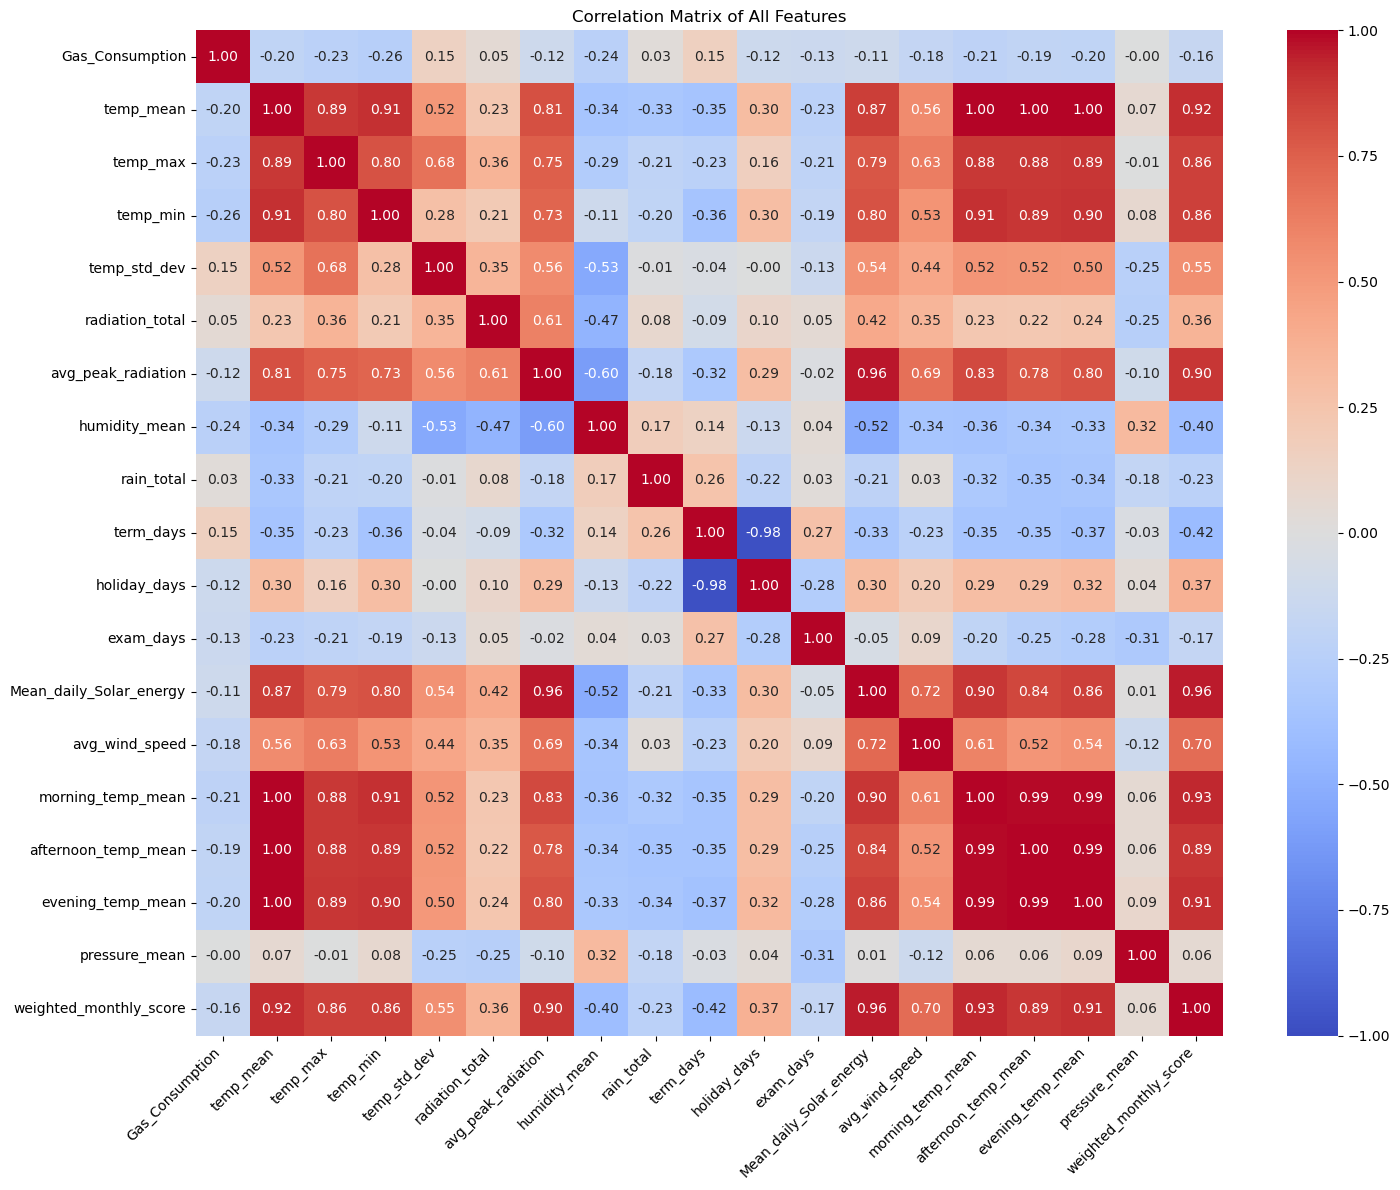


Strongest Correlations (|correlation| > 0.7):
                  Feature 1                Feature 2  Correlation
17      afternoon_temp_mean                temp_mean     0.996506
12        morning_temp_mean                temp_mean     0.995935
23        evening_temp_mean                temp_mean     0.995843
29        evening_temp_mean      afternoon_temp_mean     0.994157
28        evening_temp_mean        morning_temp_mean     0.986422
22      afternoon_temp_mean        morning_temp_mean     0.985780
6              holiday_days                term_days    -0.980798
10  Mean_daily_Solar_energy       avg_peak_radiation     0.961904
34   weighted_monthly_score  Mean_daily_Solar_energy     0.960060
35   weighted_monthly_score        morning_temp_mean     0.931732
30   weighted_monthly_score                temp_mean     0.918215
37   weighted_monthly_score        evening_temp_mean     0.913249
14        morning_temp_mean                 temp_min     0.911313
1                  temp_min  

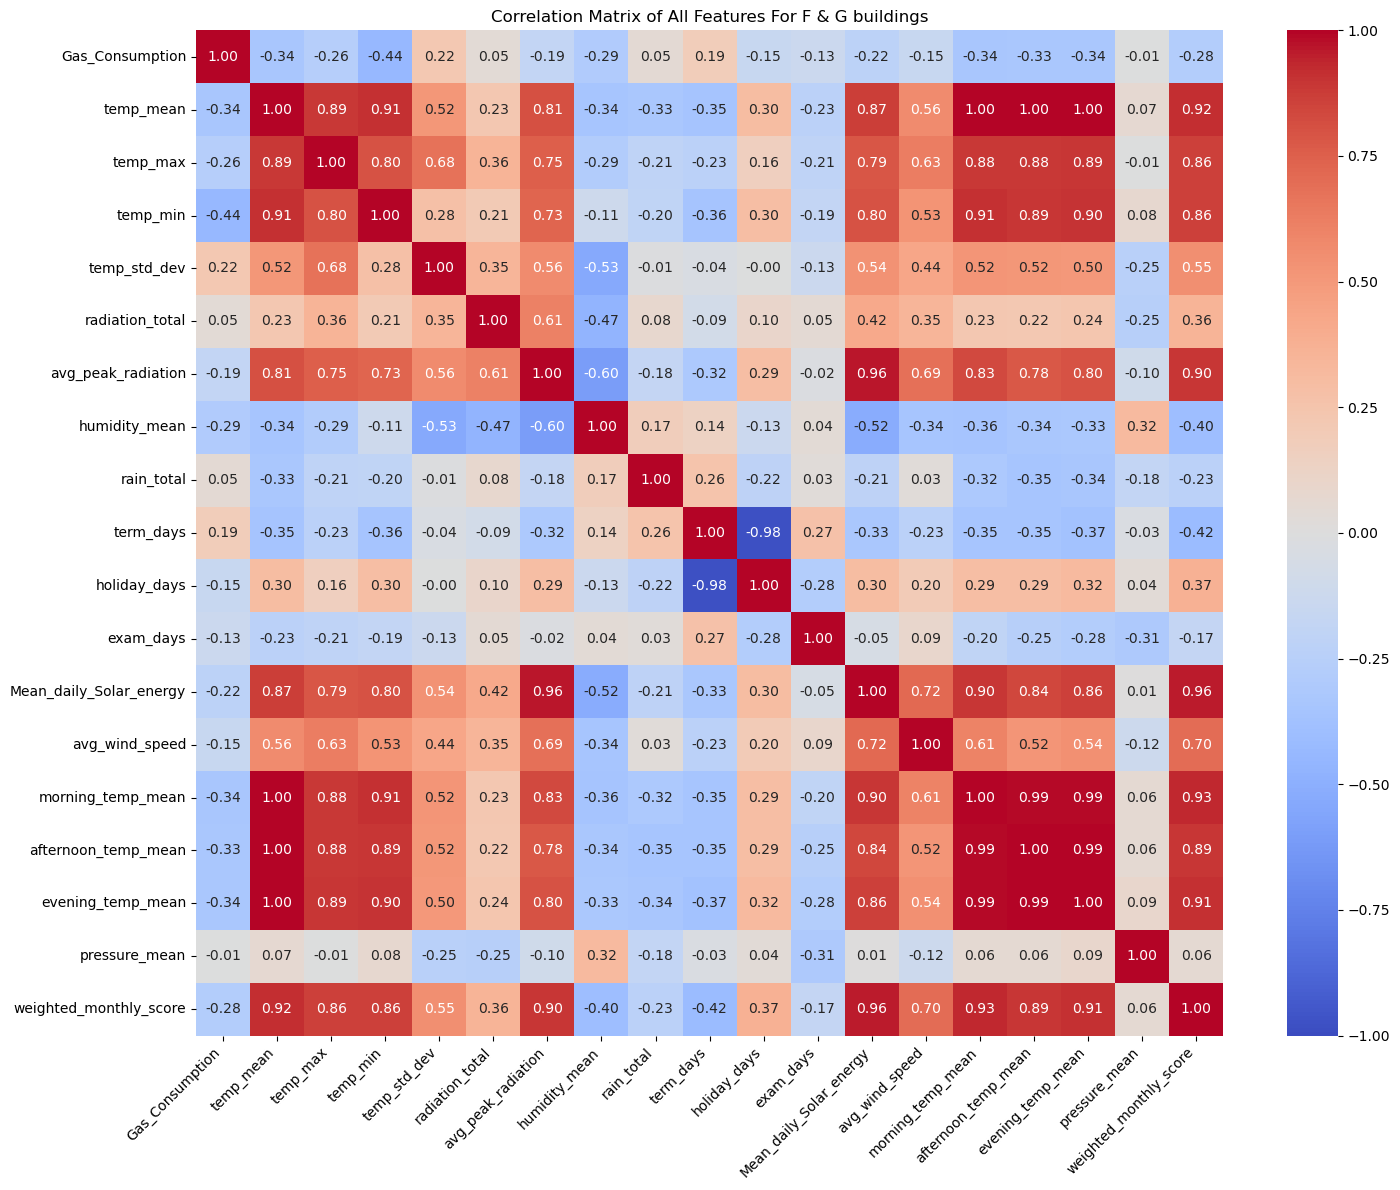

Strong Correlations with Gas_Consumption (|r| > 0.25):
temp_min                         -0.439
morning_temp_mean                -0.341
temp_mean                        -0.337
evening_temp_mean                -0.335
afternoon_temp_mean              -0.330
humidity_mean                    -0.293
weighted_monthly_score           -0.280
temp_max                         -0.258

Strongest Correlations (|correlation| > 0.7) For F Buildings:
                  Feature 1                Feature 2  Correlation
17      afternoon_temp_mean                temp_mean     0.996506
12        morning_temp_mean                temp_mean     0.995935
23        evening_temp_mean                temp_mean     0.995843
29        evening_temp_mean      afternoon_temp_mean     0.994157
28        evening_temp_mean        morning_temp_mean     0.986422
22      afternoon_temp_mean        morning_temp_mean     0.985780
6              holiday_days                term_days    -0.980798
10  Mean_daily_Solar_energy       

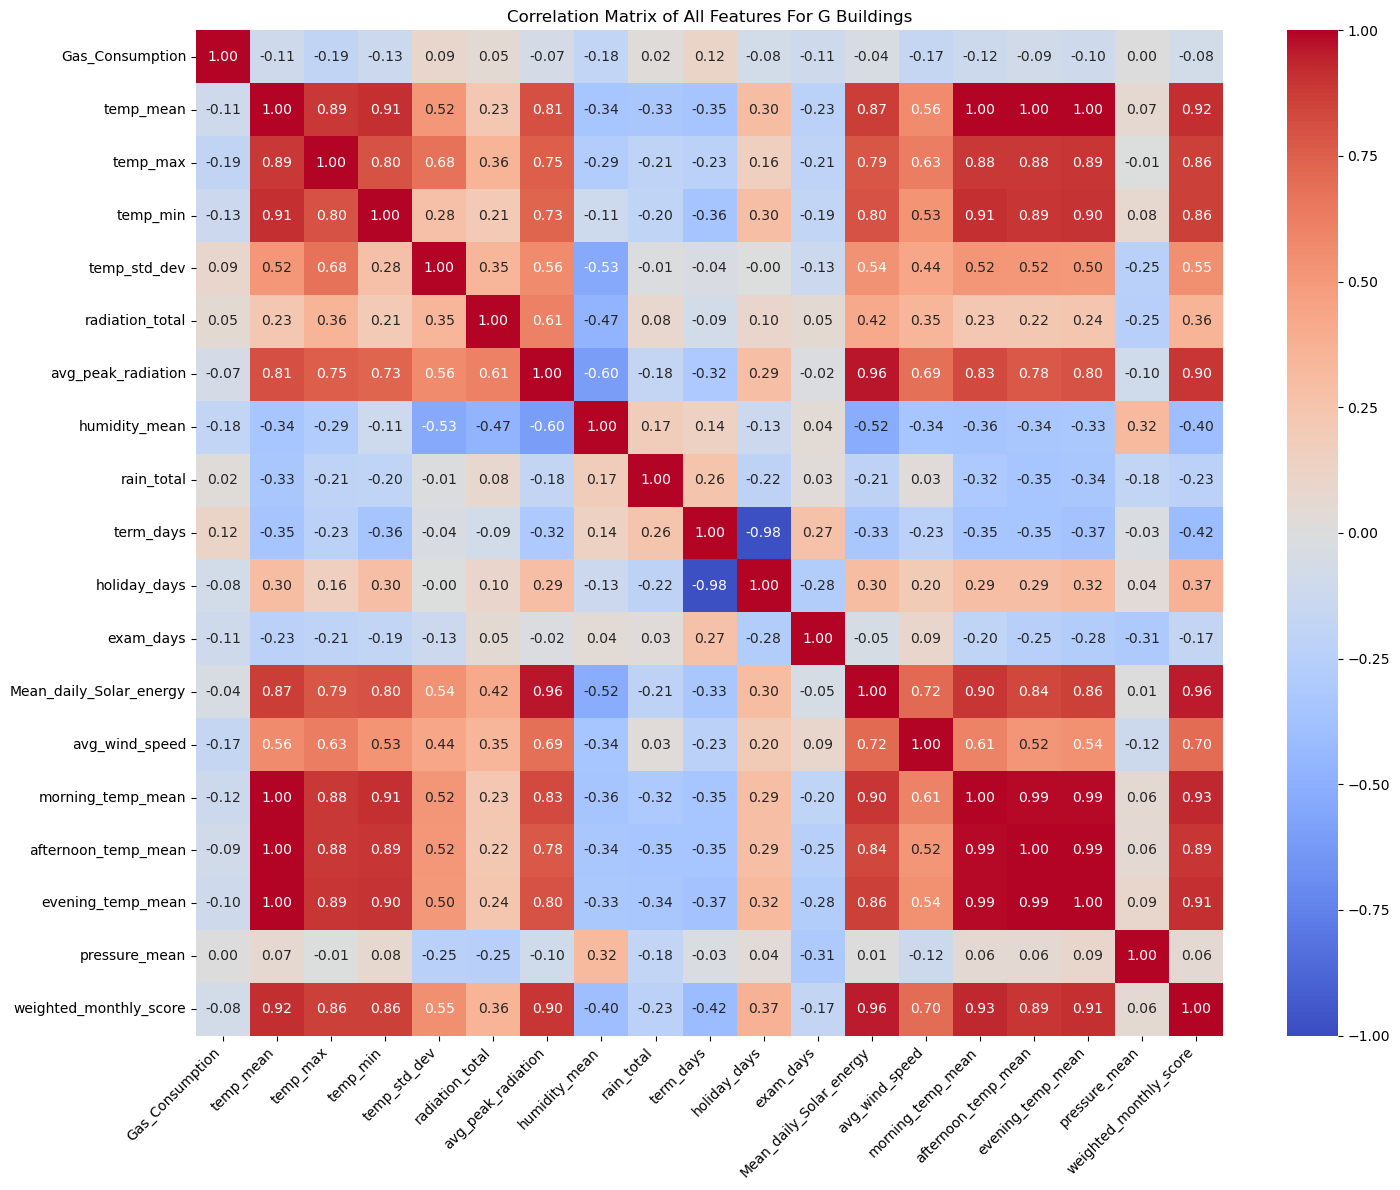


Strongest Correlations (|correlation| > 0.7): for G Building
                  Feature 1                Feature 2  Correlation
17      afternoon_temp_mean                temp_mean     0.996506
12        morning_temp_mean                temp_mean     0.995935
23        evening_temp_mean                temp_mean     0.995843
29        evening_temp_mean      afternoon_temp_mean     0.994157
28        evening_temp_mean        morning_temp_mean     0.986422
22      afternoon_temp_mean        morning_temp_mean     0.985780
6              holiday_days                term_days    -0.980798
10  Mean_daily_Solar_energy       avg_peak_radiation     0.961904
34   weighted_monthly_score  Mean_daily_Solar_energy     0.960060
35   weighted_monthly_score        morning_temp_mean     0.931732
30   weighted_monthly_score                temp_mean     0.918215
37   weighted_monthly_score        evening_temp_mean     0.913249
14        morning_temp_mean                 temp_min     0.911313
1             

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read both datasets
gas_df = pd.read_csv('imputed_modelling_gas_data.csv')
weather_df = pd.read_csv('weather_monthly.csv')

gas_df_f = gas_df[gas_df['Meter_Location'].str.startswith('F')]

# Filter meter locations that start with 'G'
gas_df_g = gas_df[gas_df['Meter_Location'].str.startswith('G')]
                                                          

# Melt the gas data to convert it to long format with dates
gas_melted = pd.melt(gas_df, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Gas_Consumption')

# Melt the gas data to convert it to long format with dates
gas_melted_f = pd.melt(gas_df_f, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Gas_Consumption')

# Melt the gas data to convert it to long format with dates
gas_melted_g = pd.melt(gas_df_g, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Gas_Consumption')

# Convert gas consumption to numeric
gas_melted['Gas_Consumption'] = pd.to_numeric(gas_melted['Gas_Consumption'], errors='coerce')

gas_melted_f['Gas_Consumption'] = pd.to_numeric(gas_melted_f['Gas_Consumption'], errors='coerce')

gas_melted_g['Gas_Consumption'] = pd.to_numeric(gas_melted_g['Gas_Consumption'], errors='coerce')

# Group by date to get total consumption
gas_by_date = gas_melted.groupby('Date')['Gas_Consumption'].sum().reset_index()

gas_by_date_f = gas_melted_f.groupby('Date')['Gas_Consumption'].sum().reset_index()
gas_by_date_g = gas_melted_g.groupby('Date')['Gas_Consumption'].sum().reset_index()

# Merge weather and gas consumption data
merged_df = pd.merge(gas_by_date, weather_df, on='Date', how='inner')

merged_df_f = pd.merge(gas_by_date_f, weather_df, on='Date', how='inner')

merged_df_g = pd.merge(gas_by_date_g, weather_df, on='Date', how='inner')


correlation_matrix = merged_df.drop('Date', axis=1).corr()

correlation_matrix_f = merged_df_f.drop('Date', axis=1).corr()
correlation_matrix_g = merged_df_g.drop('Date', axis=1).corr()


# Create a larger correlation heatmap for all features
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f')
plt.title('Correlation Matrix of All Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the strongest correlations (absolute value > 0.7)
print("\nStrongest Correlations (|correlation| > 0.7):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.7:
            strong_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i,j]
            })

strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlation', key=abs, ascending=False)
print(strong_corr_df)



plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_f, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f')
plt.title('Correlation Matrix of All Features For F & G buildings')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

gas_correlations_f = correlation_matrix_f['Gas_Consumption'].sort_values(key=abs, ascending=False)

# Filter for strong correlations (absolute value > 0.7)
strong_gas_correlations_f = gas_correlations_f[abs(gas_correlations_f) > 0.25]

print("Strong Correlations with Gas_Consumption (|r| > 0.25):")
print("=" * 50)
for feature, correlation in strong_gas_correlations_f.items():
    if feature != 'Gas_Consumption':  # Skip self-correlation
        print(f"{feature:<30} {correlation:>8.3f}")


# Print the strongest correlations (absolute value > 0.7)
print("\nStrongest Correlations (|correlation| > 0.7) For F Buildings:")
strong_corr_f = []
for i in range(len(correlation_matrix_f.columns)):
    for j in range(i):
        if abs(correlation_matrix_f.iloc[i,j]) > 0.7:
            strong_corr_f.append({
                'Feature 1': correlation_matrix_f.columns[i],
                'Feature 2': correlation_matrix_f.columns[j],
                'Correlation': correlation_matrix_f.iloc[i,j]
            })

strong_corr_df_f = pd.DataFrame(strong_corr_f).sort_values('Correlation', key=abs, ascending=False)
print(strong_corr_df_f)



plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_g, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f')
plt.title('Correlation Matrix of All Features For G Buildings')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the strongest correlations (absolute value > 0.7)
print("\nStrongest Correlations (|correlation| > 0.7): for G Building")
strong_corr_g = []
for i in range(len(correlation_matrix_g.columns)):
    for j in range(i):
        if abs(correlation_matrix_g.iloc[i,j]) > 0.7:
            strong_corr_g.append({
                'Feature 1': correlation_matrix_g.columns[i],
                'Feature 2': correlation_matrix_g.columns[j],
                'Correlation': correlation_matrix_g.iloc[i,j]
            })

strong_corr_df_g = pd.DataFrame(strong_corr_g).sort_values('Correlation', key=abs, ascending=False)
print(strong_corr_df_g)

# Export correlation matrix to CSV
#correlation_matrix.to_csv('all_features_correlations.csv')









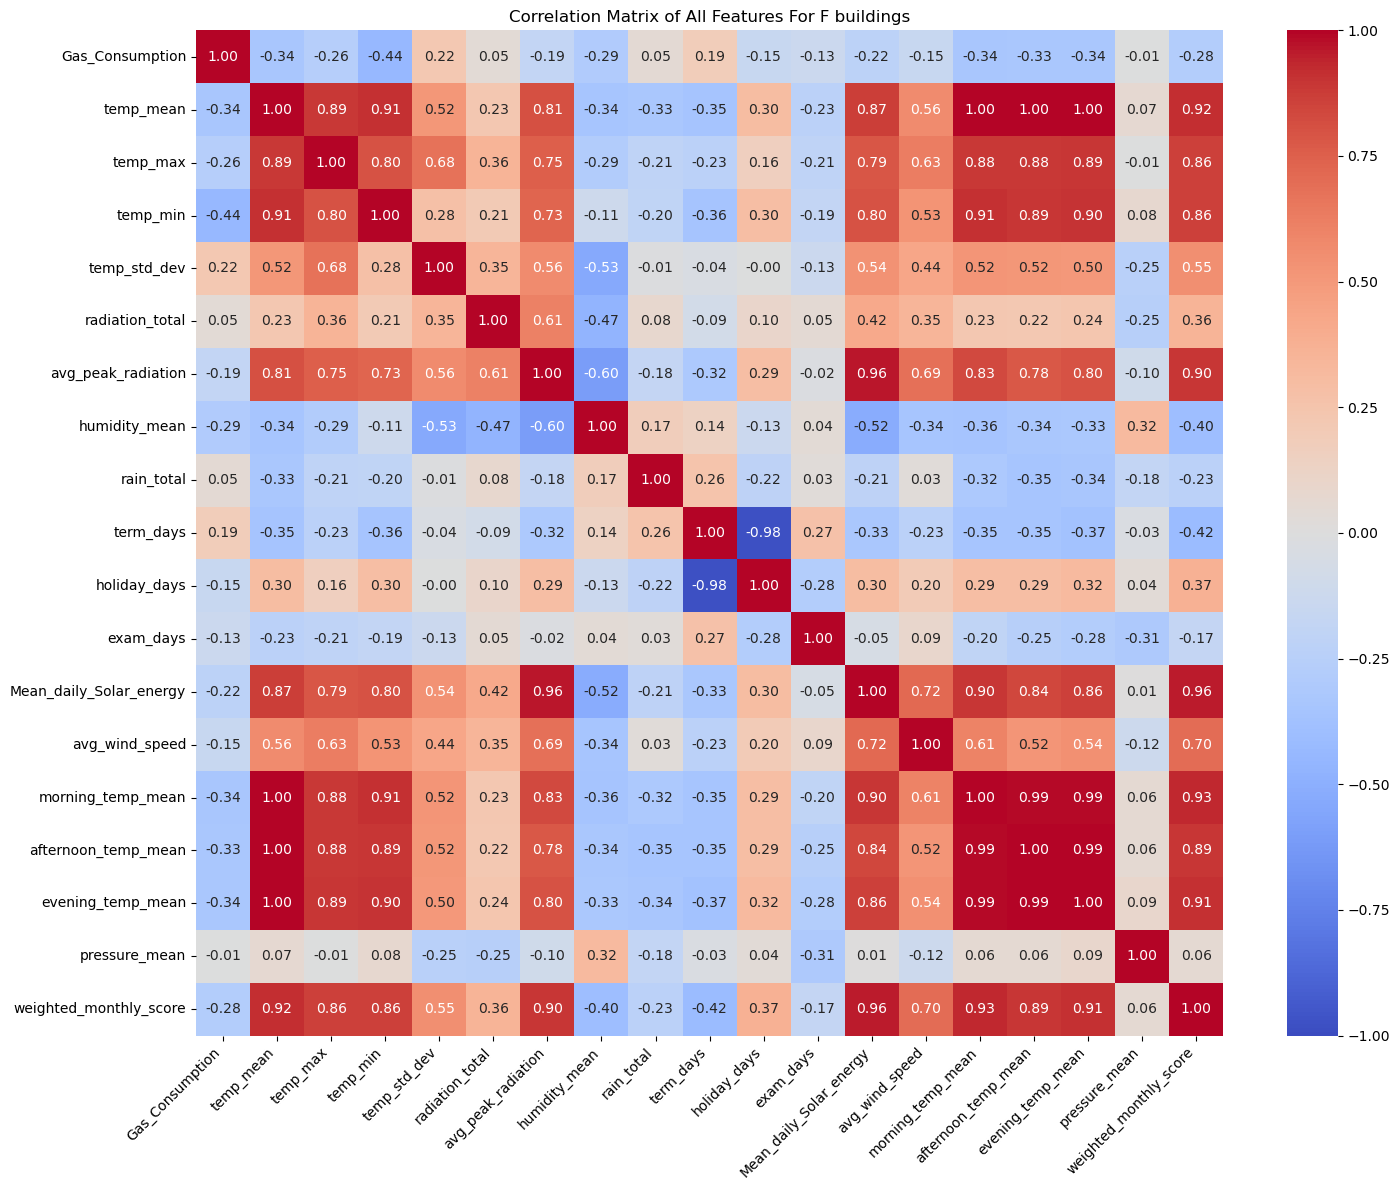

Strong Correlations with Gas_Consumption (|r| > 0.25):
temp_min                         -0.439
morning_temp_mean                -0.341
temp_mean                        -0.337
evening_temp_mean                -0.335
afternoon_temp_mean              -0.330
humidity_mean                    -0.293
weighted_monthly_score           -0.280
temp_max                         -0.258


In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read both datasets
gas_df = pd.read_csv('imputed_modelling_gas_data.csv')
weather_df = pd.read_csv('weather_monthly.csv')

gas_df_f = gas_df[gas_df['Meter_Location'].str.startswith('F')]

# Melt the gas data to convert it to long format with dates
gas_melted_f = pd.melt(gas_df_f, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Gas_Consumption')


gas_melted_f['Gas_Consumption'] = pd.to_numeric(gas_melted_f['Gas_Consumption'], errors='coerce')


gas_by_date_f = gas_melted_f.groupby('Date')['Gas_Consumption'].sum().reset_index()
merged_df_f = pd.merge(gas_by_date_f, weather_df, on='Date', how='inner')


correlation_matrix_f = merged_df_f.drop('Date', axis=1).corr()


plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_f, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f')
plt.title('Correlation Matrix of All Features For F buildings')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

gas_correlations_f = correlation_matrix_f['Gas_Consumption'].sort_values(key=abs, ascending=False)

# Filter for strong correlations (absolute value > 0.7)
strong_gas_correlations_f = gas_correlations_f[abs(gas_correlations_f) > 0.25]

print("Strong Correlations with Gas_Consumption (|r| > 0.25):")
print("=" * 30)
for feature, correlation in strong_gas_correlations_f.items():
    if feature != 'Gas_Consumption':  # Skip self-correlation
        print(f"{feature:<30} {correlation:>8.3f}")



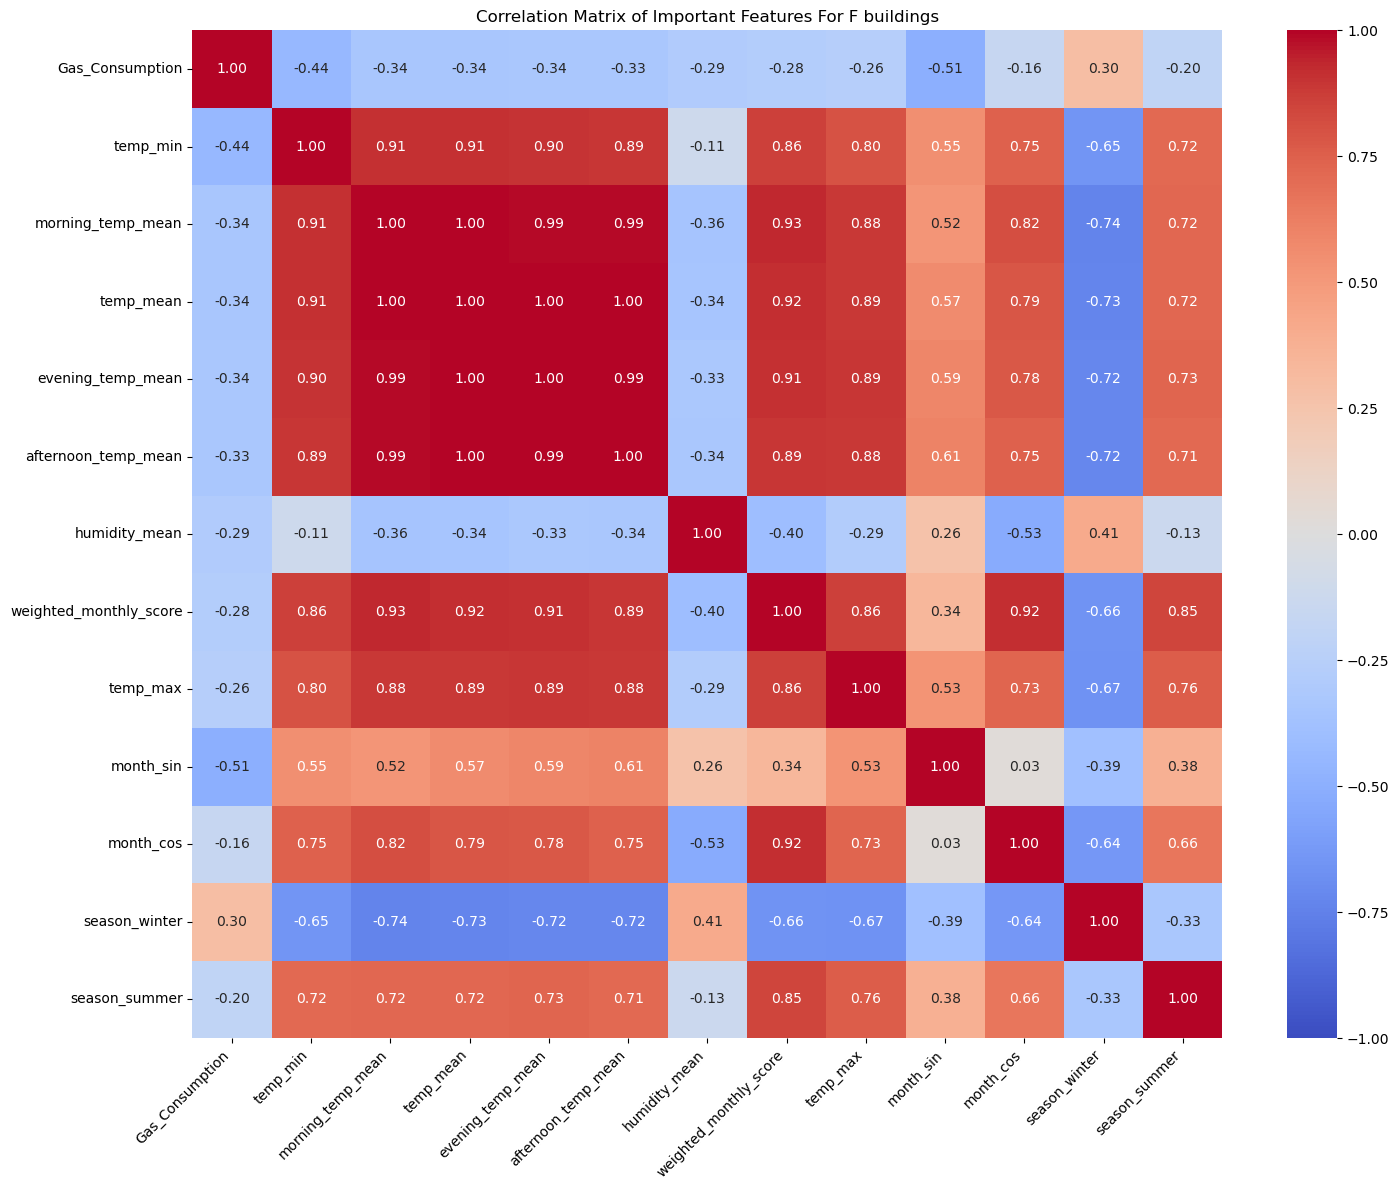


Correlations with Gas_Consumption:
month_sin                        -0.505
temp_min                         -0.439
morning_temp_mean                -0.341
temp_mean                        -0.337
evening_temp_mean                -0.335
afternoon_temp_mean              -0.330
season_winter                     0.296
humidity_mean                    -0.293
weighted_monthly_score           -0.280
temp_max                         -0.258
season_summer                    -0.202
month_cos                        -0.163


In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read both datasets
gas_df = pd.read_csv('imputed_modelling_gas_data.csv')
weather_df = pd.read_csv('weather_monthly.csv')

# Filter for F buildings
gas_df_f = gas_df[gas_df['Meter_Location'].str.startswith('F')]

# Melt the gas data
gas_melted_f = pd.melt(gas_df_f, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Gas_Consumption')

# Convert gas consumption to numeric
gas_melted_f['Gas_Consumption'] = pd.to_numeric(gas_melted_f['Gas_Consumption'], errors='coerce')

# Group by date
gas_by_date_f = gas_melted_f.groupby('Date')['Gas_Consumption'].sum().reset_index()

# Add month and seasonal components
gas_by_date_f['month'] = pd.to_datetime(gas_by_date_f['Date'].str.replace('_', '-') + '-01').dt.month
gas_by_date_f['month_sin'] = np.sin(2 * np.pi * gas_by_date_f['month']/12)
gas_by_date_f['month_cos'] = np.cos(2 * np.pi * gas_by_date_f['month']/12)

# Add seasonal dummies
gas_by_date_f['season'] = gas_by_date_f['month'] % 12 // 3
gas_by_date_f['season_winter'] = (gas_by_date_f['season'] == 2).astype(int)
gas_by_date_f['season_summer'] = (gas_by_date_f['season'] == 0).astype(int)

# Merge with weather data
merged_df_f = pd.merge(gas_by_date_f, weather_df, on='Date', how='inner')

# Select only important features
important_features = ['Gas_Consumption', 'temp_min', 'morning_temp_mean', 
                     'temp_mean', 'evening_temp_mean', 'afternoon_temp_mean',
                     'humidity_mean', 'weighted_monthly_score', 'temp_max',
                     'month_sin', 'month_cos', 'season_winter', 'season_summer']

merged_df_f_selected = merged_df_f[important_features]

# Calculate correlation matrix
correlation_matrix_f = merged_df_f_selected.corr()

# Plot correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_f, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f')
plt.title('Correlation Matrix of Important Features For F buildings')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print correlations with Gas_Consumption
gas_correlations_f = correlation_matrix_f['Gas_Consumption'].sort_values(key=abs, ascending=False)
print("\nCorrelations with Gas_Consumption:")
print("=" * 50)
for feature, correlation in gas_correlations_f.items():
    if feature != 'Gas_Consumption':
        print(f"{feature:<30} {correlation:>8.3f}")



Model Performance Metrics:
               Model          RMSE           MAE        R2
0  Linear Regression  61894.143047  59763.658021 -2.691290
1   Ridge Regression  61847.249955  59582.337117 -2.685698
2   Lasso Regression  61894.122591  59763.524285 -2.691287
3         ElasticNet  62122.056473  56562.247161 -2.718525
4      Random Forest  48034.838364  40763.668357 -1.223267
5  Gradient Boosting  56675.369154  47462.445888 -2.095050
6                SVR  42026.593168  34795.489416 -0.701874
7            XGBoost  56786.000711  41033.736875 -2.107145


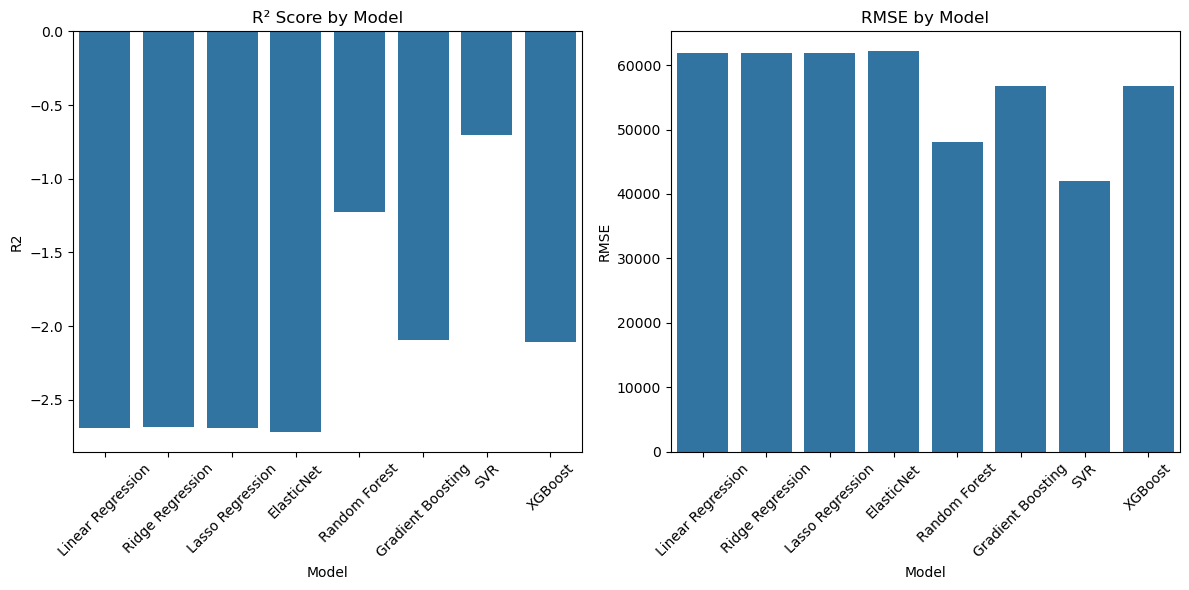

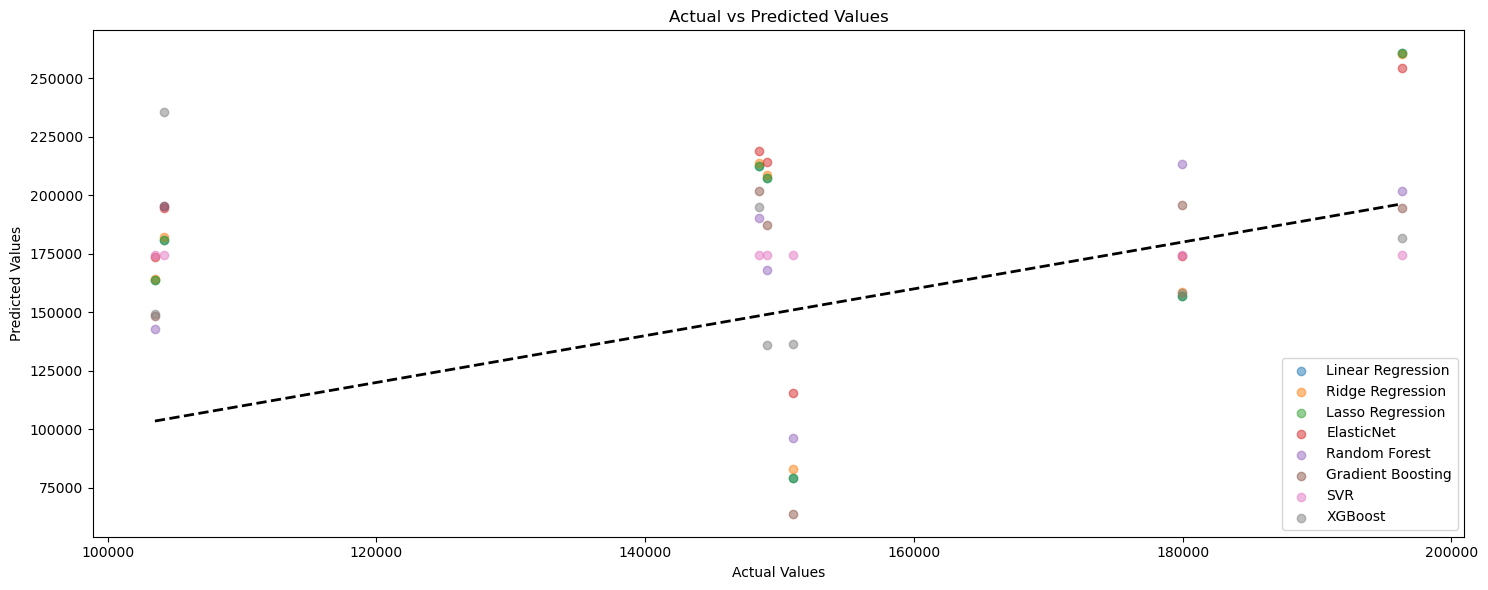

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data with selected features
def prepare_data(merged_df_f):
    X = merged_df_f[['temp_min', 'month_sin', 'humidity_mean']]
    y = merged_df_f['Gas_Consumption']
    return X, y

# Define models
models_linear = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5)
}

models_nonlinear = {
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor()
}

# Combine all models
all_models = {**models_linear, **models_nonlinear}

# Model evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Train and evaluate all models
def train_evaluate_models(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = []
    predictions = {}
    
    for name, model in all_models.items():
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        predictions[name] = y_pred
        
        # Evaluate model
        results.append(evaluate_model(y_test, y_pred, name))
    
    return pd.DataFrame(results), predictions, y_test

# Visualization functions
def plot_model_comparison(results):
    plt.figure(figsize=(12, 6))
    
    # Plot R2 scores
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='R2', data=results)
    plt.xticks(rotation=45)
    plt.title('R² Score by Model')
    
    # Plot RMSE
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='RMSE', data=results)
    plt.xticks(rotation=45)
    plt.title('RMSE by Model')
    
    plt.tight_layout()
    plt.show()

def plot_predictions(predictions, y_test):
    plt.figure(figsize=(15, 6))
    for name, y_pred in predictions.items():
        plt.scatter(y_test, y_pred, label=name, alpha=0.5)
    
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
X, y = prepare_data(merged_df_f)
results, predictions, y_test = train_evaluate_models(X, y)

# Display results
print("\nModel Performance Metrics:")
print(results)

# Plot comparisons
plot_model_comparison(results)
plot_predictions(predictions, y_test)


In [ ]:
gas_df_f

In [86]:
import pandas as pd
import numpy as np

# Calculate total and mean consumption for each building
def categorize_buildings(gas_df_f):
    # Melt the dataframe to get consumption values
    melted = pd.melt(gas_df_f, 
                     id_vars=['Meter_Location'], 
                     var_name='Date', 
                     value_name='Consumption')
    
    # Calculate statistics for each building
    building_stats = melted.groupby('Meter_Location')['Consumption'].agg(['mean', 'sum']).reset_index()
    
    # Create usage tiers based on mean consumption
    # Using quantiles to split into 3 tiers
    building_stats['usage_tier'] = pd.qcut(building_stats['mean'], 
                                         q=3, 
                                         labels=['low', 'medium', 'high'])
    
    # Create a mapping dictionary
    building_tier_map = dict(zip(building_stats['Meter_Location'], building_stats['usage_tier']))
    
    # Add tier column to original dataframe
    gas_df_f['usage_tier'] = gas_df_f['Meter_Location'].map(building_tier_map)
    
    # Create dummy variables for usage tiers
    usage_dummies = pd.get_dummies(gas_df_f['usage_tier'], prefix='usage')
    
    # Combine with original dataframe
    gas_df_f_with_tiers = pd.concat([gas_df_f, usage_dummies], axis=1)
    
    return gas_df_f_with_tiers, building_stats

# Apply the categorization
gas_df_f_categorized, building_statistics = categorize_buildings(gas_df_f)

# Print building categories
print("\nBuilding Usage Categories:")
print("=" * 50)
for meter_loc, tier in building_statistics[['Meter_Location', 'usage_tier']].values:
    print(f"{meter_loc.split(',')[0]}: {tier}")

# Now we can use these features for modeling
features_with_tiers = ['temp_min', 'month_sin', 'humidity_mean', 
                      'usage_low', 'usage_medium', 'usage_high']



Building Usage Categories:
F204: medium
F402: medium
F405: medium
F512: high
F516/17: low
F603: low
F620 Psychology 2: low
F62X: high
F916: high
F940: high


C:\Users\sugan\AppData\Local\Temp\ipykernel_8716\3644441610.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_df_f['usage_tier'] = gas_df_f['Meter_Location'].map(building_tier_map)



Model Performance Metrics:
               Model          RMSE           MAE        R2
0  Linear Regression  42551.432956  18619.244479  0.211294
1   Ridge Regression  42554.974301  18560.878962  0.211163
2   Lasso Regression  42551.583711  18618.195263  0.211288
3         ElasticNet  44309.926220  19621.729761  0.144758
4      Random Forest  49743.693484  24397.968904 -0.077861
5  Gradient Boosting  53610.027455  26173.541970 -0.251926
6                SVR  50476.713946  18168.843948 -0.109862
7            XGBoost  55710.061434  26439.858179 -0.351929


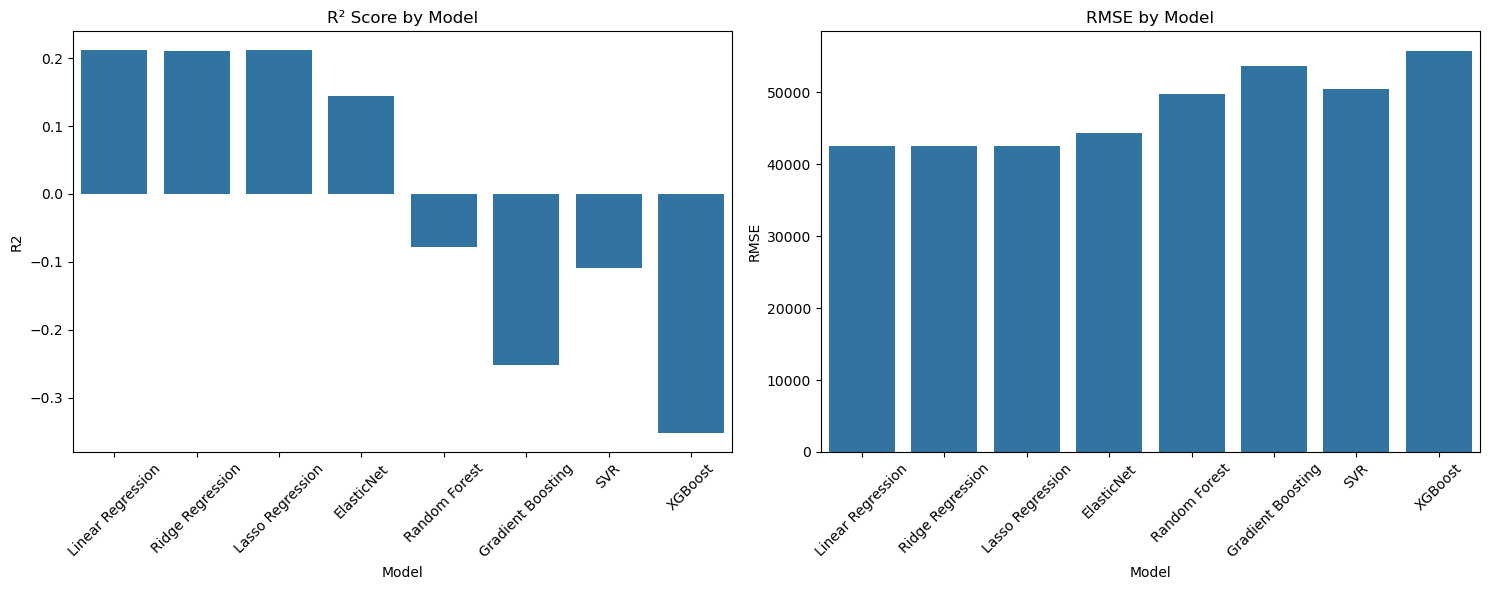

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
def prepare_data(gas_df_f):
    # Melt the dataframe to get month-wise data
    melted_df = pd.melt(gas_df_f, 
                        id_vars=['Meter_Location', 'usage_tier'], 
                        var_name='Date', 
                        value_name='Gas_Consumption')
    
    # Extract month from Date
    melted_df['month'] = pd.to_datetime(melted_df['Date'].str.split('_').str[0], format='%b').dt.month
    melted_df['month_sin'] = np.sin(2 * np.pi * melted_df['month']/12)
    
    # Convert usage_tier to categorical
    melted_df['usage_tier'] = pd.Categorical(melted_df['usage_tier'])
    
    # Create dummy variables for usage tiers
    tier_dummies = pd.get_dummies(melted_df['usage_tier'], prefix='tier')
    
    # Merge with weather data
    weather_df = pd.read_csv('weather_monthly.csv')
    final_df = pd.merge(melted_df, weather_df, on='Date', how='inner')
    
    # Select final features
    X = pd.concat([
        final_df[['temp_min', 'month_sin', 'humidity_mean']],
        tier_dummies
    ], axis=1)
    
    y = final_df['Gas_Consumption']
    
    return X, y

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor(random_state=42)
}

# Model evaluation function
def evaluate_models(X, y, models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features (excluding dummy variables)
    feature_cols = ['temp_min', 'month_sin', 'humidity_mean']
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[feature_cols] = scaler.fit_transform(X_train[feature_cols])
    X_test_scaled[feature_cols] = scaler.transform(X_test[feature_cols])
    
    results = []
    predictions = {}
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
        predictions[name] = y_pred
    
    return pd.DataFrame(results), predictions, y_test

# Run models and evaluate
X, y = prepare_data(gas_df_f)
results, predictions, y_test = evaluate_models(X, y, models)

# Print results
print("\nModel Performance Metrics:")
print(results)

# Plot results
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R2', data=results)
plt.xticks(rotation=45)
plt.title('R² Score by Model')

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=results)
plt.xticks(rotation=45)
plt.title('RMSE by Model')
plt.tight_layout()
plt.show()


In [92]:
melted_df = pd.melt(gas_df_f, 
                id_vars=['Meter_Location', 'usage_tier'], 
                var_name='Date', 
                value_name='Gas_Consumption')

# Extract month from Date
melted_df['month'] = pd.to_datetime(melted_df['Date'].str.split('_').str[0], format='%b').dt.month
melted_df['month_sin'] = np.sin(2 * np.pi * melted_df['month']/12)

# Convert usage_tier to categorical
melted_df['usage_tier'] = pd.Categorical(melted_df['usage_tier'])

# Create dummy variables for usage tiers
tier_dummies = pd.get_dummies(melted_df['usage_tier'], prefix='tier')

# Merge with weather data
weather_df = pd.read_csv('weather_monthly.csv')
final_df = pd.merge(melted_df, weather_df, on='Date', how='inner')


Model Performance Metrics:
               Model          RMSE           MAE        R2
0  Linear Regression  42719.356003  19078.987659  0.205057
1   Ridge Regression  42717.767443  18994.047894  0.205116
2   Lasso Regression  42719.141451  19076.546215  0.205065
3         ElasticNet  44328.729135  19687.849995  0.144032
4      Random Forest  49699.687104  24260.878331 -0.075955
5  Gradient Boosting  52542.872705  25402.295737 -0.202581
6                SVR  50480.924060  18174.365709 -0.110047
7            XGBoost  55709.455034  26425.015174 -0.351900


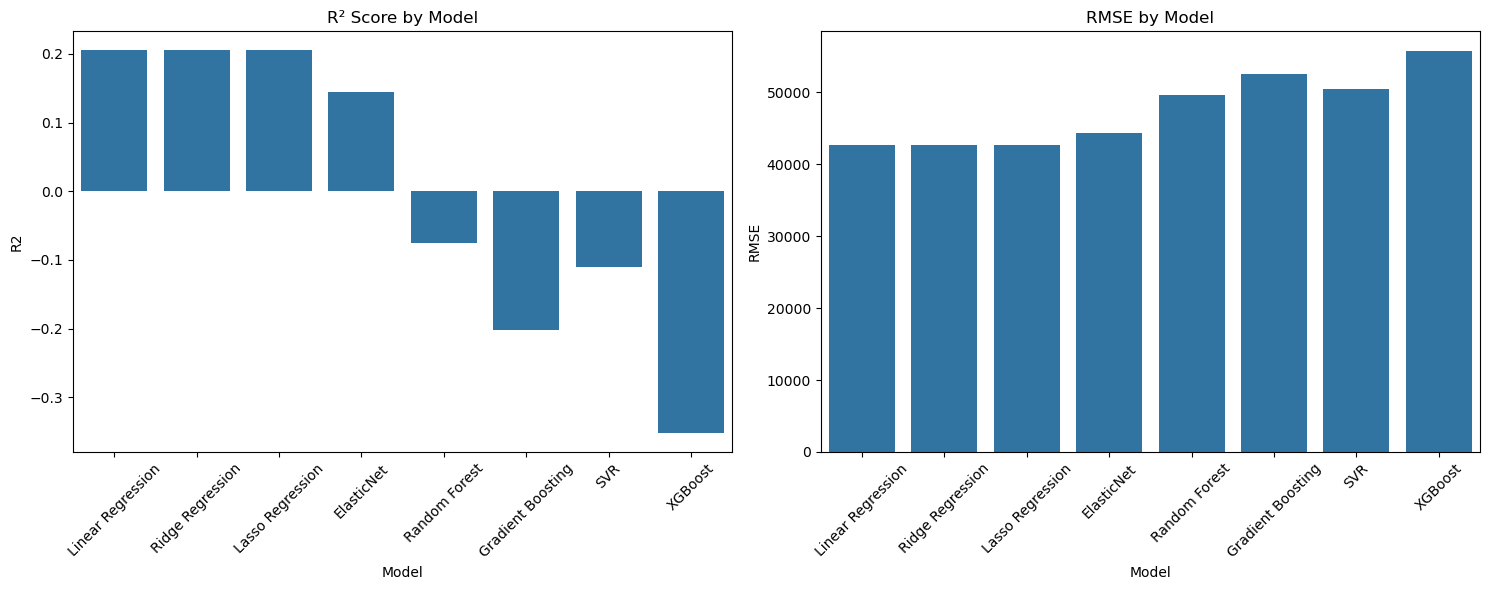

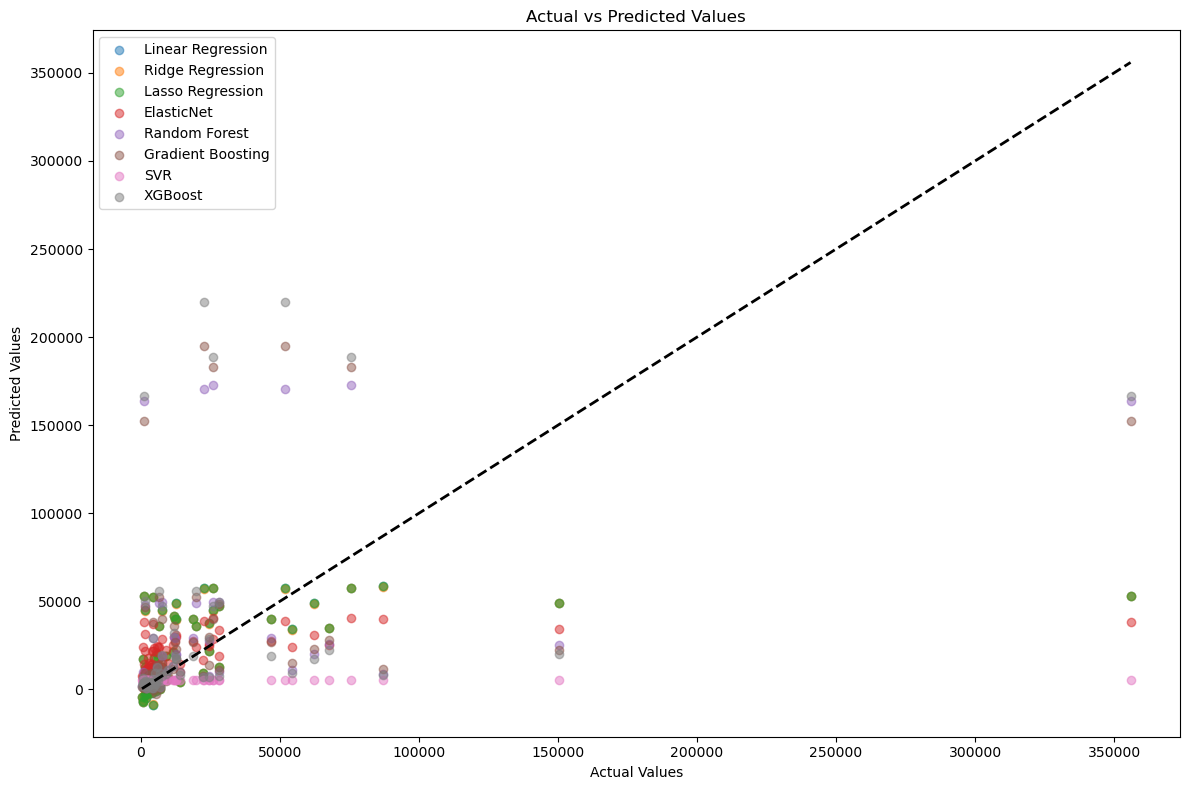

In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
gas_df_f = pd.read_csv('imputed_modelling_gas_data.csv')
weather_df = pd.read_csv('weather_monthly.csv')

# Filter F buildings
gas_df_f = gas_df_f[gas_df_f['Meter_Location'].str.startswith('F')]

def prepare_data(gas_df_f, weather_df):
    # Melt the dataframe
    melted_df = pd.melt(gas_df_f, 
                        id_vars=['Meter_Location'], 
                        var_name='Date', 
                        value_name='Gas_Consumption')
    
    # Extract time components
    melted_df['month'] = pd.to_datetime(melted_df['Date'].str.split('_').str[0], format='%b').dt.month
    melted_df['year'] = pd.to_datetime(melted_df['Date'].str.split('_').str[1], format='%Y').dt.year
    
    # Create cyclical features
    melted_df['month_sin'] = np.sin(2 * np.pi * melted_df['month']/12)
    melted_df['month_cos'] = np.cos(2 * np.pi * melted_df['month']/12)
    
    # Create building usage tiers
    building_stats = melted_df.groupby('Meter_Location')['Gas_Consumption'].mean()
    usage_tiers = pd.qcut(building_stats, q=3, labels=['low', 'medium', 'high'])
    melted_df['usage_tier'] = melted_df['Meter_Location'].map(usage_tiers)
    
    # Create dummy variables for usage tiers
    tier_dummies = pd.get_dummies(melted_df['usage_tier'], prefix='tier')
    
    # Merge with weather data
    final_df = pd.merge(melted_df, weather_df, on='Date', how='inner')
    
    # Select features
    X = pd.concat([
        final_df[['temp_min', 'month_sin', 'month_cos', 'humidity_mean']],
        tier_dummies,
        final_df[['year']]
    ], axis=1)
    
    y = final_df['Gas_Consumption']
    
    return X, y, final_df

def evaluate_models(X, y, models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features (excluding dummy variables and year)
    feature_cols = ['temp_min', 'month_sin', 'month_cos', 'humidity_mean']
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[feature_cols] = scaler.fit_transform(X_train[feature_cols])
    X_test_scaled[feature_cols] = scaler.transform(X_test[feature_cols])
    
    results = []
    predictions = {}
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
        predictions[name] = y_pred
        
    return pd.DataFrame(results), predictions, y_test

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor(random_state=42)
}

# Prepare data and run models
X, y, final_df = prepare_data(gas_df_f, weather_df)
results, predictions, y_test = evaluate_models(X, y, models)

# Print results
print("\nModel Performance Metrics:")
print(results)

# Plot results
plt.figure(figsize=(15, 6))

# R² Score plot
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R2', data=results)
plt.xticks(rotation=45)
plt.title('R² Score by Model')

# RMSE plot
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=results)
plt.xticks(rotation=45)
plt.title('RMSE by Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 8))
for name, pred in predictions.items():
    plt.scatter(y_test, pred, label=name, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()


In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
gas_df_f = pd.read_csv('imputed_modelling_gas_data.csv')
weather_df = pd.read_csv('weather_monthly.csv')

# Ensure column names are clean
weather_df.columns = weather_df.columns.str.strip()

gas_df_f = gas_df_f[gas_df_f['Meter_Location'].str.startswith('F')]

# Convert gas_df_f from wide to long format
gas_long = gas_df_f.melt(id_vars=['Meter_Location'], var_name='Date', value_name='Gas_Consumption')

# Convert 'Date' to match 'weather_df' format
gas_long['Date'] = pd.to_datetime(gas_long['Date'], format='%b_%Y', errors='coerce')

# Infer datetime format for weather_df to avoid NaT values
weather_df['Date'] = pd.to_datetime(weather_df['Date'], errors='coerce', infer_datetime_format=True)

# Drop NaN values due to conversion errors
gas_long = gas_long.dropna(subset=['Date'])
weather_df = weather_df.dropna(subset=['Date'])

# Debugging: Print unique dates before merging
print("Unique Dates in gas_long:", gas_long['Date'].unique())
print("Unique Dates in weather_df:", weather_df['Date'].unique())

# Merge gas and weather data
merged_df = gas_long.merge(weather_df, on='Date', how='inner')

# Ensure there are no empty samples
if merged_df.empty:
    raise ValueError("Merged dataset is empty after merging. Check date formats and ranges.")

# Extract time components
merged_df['month'] = merged_df['Date'].dt.month
merged_df['year'] = merged_df['Date'].dt.year

# Create cyclical features
merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['month'] / 12)
merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['month'] / 12)

# Interaction term
merged_df['temp_humidity_interaction'] = merged_df['temp_min'] * merged_df['humidity_mean']

# Lag feature
gas_lag = merged_df.groupby('Meter_Location')['Gas_Consumption'].shift(1)
merged_df['Gas_Consumption_lag1'] = gas_lag.fillna(merged_df['Gas_Consumption'].mean())

# Select final features
features = ['temp_min', 'month_sin', 'month_cos', 'humidity_mean', 'temp_humidity_interaction', 'Gas_Consumption_lag1']
X = merged_df[features]
y = merged_df['Gas_Consumption']

# Ensure there are enough samples for train-test split
if X.shape[0] == 0:
    raise ValueError("No valid samples available for model training. Check data preprocessing steps.")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


Unique Dates in gas_long: <DatetimeArray>
['2022-01-01 00:00:00', '2022-02-01 00:00:00', '2022-03-01 00:00:00',
 '2022-04-01 00:00:00', '2022-05-01 00:00:00', '2022-06-01 00:00:00',
 '2022-07-01 00:00:00', '2022-08-01 00:00:00', '2022-09-01 00:00:00',
 '2022-10-01 00:00:00', '2022-11-01 00:00:00', '2022-12-01 00:00:00',
 '2023-01-01 00:00:00', '2023-02-01 00:00:00', '2023-03-01 00:00:00',
 '2023-04-01 00:00:00', '2023-05-01 00:00:00', '2023-06-01 00:00:00',
 '2023-07-01 00:00:00', '2023-08-01 00:00:00', '2023-09-01 00:00:00',
 '2023-10-01 00:00:00', '2023-11-01 00:00:00', '2023-12-01 00:00:00',
 '2024-01-01 00:00:00', '2024-02-01 00:00:00', '2024-03-01 00:00:00',
 '2024-04-01 00:00:00', '2024-05-01 00:00:00', '2024-06-01 00:00:00',
 '2024-07-01 00:00:00', '2024-08-01 00:00:00', '2024-09-01 00:00:00',
 '2024-10-01 00:00:00']
Length: 34, dtype: datetime64[ns]
Unique Dates in weather_df: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


C:\Users\sugan\AppData\Local\Temp\ipykernel_8716\2984887530.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  weather_df['Date'] = pd.to_datetime(weather_df['Date'], errors='coerce', infer_datetime_format=True)
C:\Users\sugan\AppData\Local\Temp\ipykernel_8716\2984887530.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_df['Date'] = pd.to_datetime(weather_df['Date'], errors='coerce', infer_datetime_format=True)


ValueError: Merged dataset is empty after merging. Check date formats and ranges.

In [ ]:
weather_df

In [ ]:
weather_df = pd.read_csv('weather_monthly.csv')

In [ ]:
weather_df.columns = weather_df.columns.str.strip()

In [ ]:
weather_df['Date'] = pd.to_datetime(weather_df['Date'], format='%Y-%m-%d', errors='coerce')


In [98]:
import pandas as pd
import numpy as np
from datetime import datetime

# Read the CSV file
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Melt the dataframe to convert it from wide to long format
df_melted = pd.melt(df, id_vars=['Meter_Location'], var_name='Date', value_name='Gas_Consumption')

# Convert Date column to datetime
df_melted['Date'] = pd.to_datetime(df_melted['Date'], format='%b_%Y')

# Extract additional features
df_melted['Month'] = df_melted['Date'].dt.month
df_melted['Year'] = df_melted['Date'].dt.year

# Define a function to get season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df_melted['Season'] = df_melted['Month'].apply(get_season)

# Extract building code from Meter_Location
df_melted['Building_Code'] = df_melted['Meter_Location'].str.split(',').str[0]

# Select relevant columns
df_final = df_melted[['Building_Code', 'Date', 'Gas_Consumption', 'Month', 'Year', 'Season']]

# Display the first few rows of the prepared dataset
print(df_final.head())

# Save the prepared dataset to a new CSV file
df_final.to_csv('prepared_gas_consumption_data.csv', index=False)


  Building_Code       Date  Gas_Consumption  Month  Year  Season
0          F204 2022-01-01          1964.35      1  2022  Summer
1          F402 2022-01-01            48.22      1  2022  Summer
2          F405 2022-01-01             0.00      1  2022  Summer
3          F512 2022-01-01          6594.87      1  2022  Summer
4       F516/17 2022-01-01          1459.92      1  2022  Summer


In [100]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Load the prepared data
df = pd.read_csv('prepared_gas_consumption_data.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create lag features (historical aspects)
for lag in [1, 2, 3, 6, 12]:  # 1, 2, 3, 6, and 12 months lag
    df[f'Gas_Consumption_Lag_{lag}'] = df.groupby('Building_Code')['Gas_Consumption'].shift(lag)

# Create rolling mean features
for window in [3, 6, 12]:  # 3, 6, and 12 months rolling mean
    df[f'Gas_Consumption_RollingMean_{window}'] = df.groupby('Building_Code')['Gas_Consumption'].rolling(window=window).mean().reset_index(0, drop=True)

# Drop rows with NaN values (due to lag and rolling mean calculations)
df = df.dropna()

# Encode categorical variables
le = LabelEncoder()
df['Building_Code_Encoded'] = le.fit_transform(df['Building_Code'])
df['Season_Encoded'] = le.fit_transform(df['Season'])

# Select features for mutual information calculation
features = ['Building_Code_Encoded', 'Month', 'Year', 'Season_Encoded'] + \
           [col for col in df.columns if col.startswith('Gas_Consumption_Lag') or col.startswith('Gas_Consumption_RollingMean')]

X = df[features]
y = df['Gas_Consumption']

# Calculate mutual information scores
mi_scores = mutual_info_regression(X, y)

# Create a dataframe of features and their mutual information scores
feature_importance = pd.DataFrame({'Feature': features, 'Mutual_Information': mi_scores})
feature_importance = feature_importance.sort_values('Mutual_Information', ascending=False)

# Display the top 10 most important features
print("Top 10 most important features:")
print(feature_importance.head(10))

# Select features with mutual information score above a threshold (e.g., 0.1)
selected_features = feature_importance[feature_importance['Mutual_Information'] > 0.1]['Feature'].tolist()

print("\nSelected features:")
print(selected_features)

# Create the final dataset with selected features
X_selected = df[selected_features]
y = df['Gas_Consumption']

# Save the selected features dataset
selected_data = pd.concat([X_selected, y], axis=1)
selected_data.to_csv('selected_features_gas_consumption_data.csv', index=False)


Top 10 most important features:
                           Feature  Mutual_Information
9    Gas_Consumption_RollingMean_3            1.103552
8           Gas_Consumption_Lag_12            1.011798
0            Building_Code_Encoded            0.992102
11  Gas_Consumption_RollingMean_12            0.895899
4            Gas_Consumption_Lag_1            0.879863
10   Gas_Consumption_RollingMean_6            0.810982
5            Gas_Consumption_Lag_2            0.574777
6            Gas_Consumption_Lag_3            0.362811
7            Gas_Consumption_Lag_6            0.325460
3                   Season_Encoded            0.073562

Selected features:
['Gas_Consumption_RollingMean_3', 'Gas_Consumption_Lag_12', 'Building_Code_Encoded', 'Gas_Consumption_RollingMean_12', 'Gas_Consumption_Lag_1', 'Gas_Consumption_RollingMean_6', 'Gas_Consumption_Lag_2', 'Gas_Consumption_Lag_3', 'Gas_Consumption_Lag_6']


In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Load the selected features dataset
df = pd.read_csv('selected_features_gas_consumption_data.csv')

# Split features and target
X = df.drop('Gas_Consumption', axis=1)
y = df['Gas_Consumption']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

# Train and evaluate models
results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Store results
    results[name] = {'RMSE': rmse, 'R2': r2, 'CV RMSE': cv_rmse}

# Display results
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  R2: {metrics['R2']:.2f}")
    print(f"  CV RMSE: {metrics['CV RMSE']:.2f}")
    print()

# Identify the best model based on CV RMSE
best_model = min(results, key=lambda x: results[x]['CV RMSE'])
print(f"Best model based on CV RMSE: {best_model}")


Linear Regression:
  RMSE: 0.00
  R2: 1.00
  CV RMSE: 0.00

Ridge Regression:
  RMSE: 2144.25
  R2: 1.00
  CV RMSE: 12124.19

Lasso Regression:
  RMSE: 56.25
  R2: 1.00
  CV RMSE: 71.44

Elastic Net:
  RMSE: 40656.15
  R2: 0.62
  CV RMSE: 82717.03

Decision Tree:
  RMSE: 57686.87
  R2: 0.24
  CV RMSE: 114874.15

Random Forest:
  RMSE: 45421.81
  R2: 0.53
  CV RMSE: 96026.05

Gradient Boosting:
  RMSE: 46480.47
  R2: 0.50
  CV RMSE: 90199.37

SVR:
  RMSE: 68543.58
  R2: -0.08
  CV RMSE: 93228.03

XGBoost:
  RMSE: 28743.43
  R2: 0.81
  CV RMSE: 78126.17

Best model based on CV RMSE: Linear Regression


In [ ]:
df

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Load gas consumption and weather data
gas_df = pd.read_csv('imputed_modelling_gas_data.csv')
weather_df = pd.read_csv('weather_monthly.csv')

# Melt gas consumption data
gas_melted = pd.melt(gas_df, id_vars=['Meter_Location'], 
                     var_name='Date', value_name='Gas_Consumption')

# Clean up date format
gas_melted['Date'] = gas_melted['Date'].str.strip()

# Create a function to extract month from the date string
def get_month(date_str):
    month_dict = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    month = date_str.split('_')[0]
    return month_dict[month]

# Merge gas consumption with weather data
df = pd.merge(gas_melted, weather_df, on='Date', how='inner')

# Create temperature-related features
df['temp_range'] = df['temp_max'] - df['temp_min']
df['temp_morning_diff'] = df['temp_mean'] - df['morning_temp_mean']
df['temp_afternoon_diff'] = df['afternoon_temp_mean'] - df['temp_mean']

# Create interaction features
df['temp_humidity_interaction'] = df['temp_mean'] * df['humidity_mean']
df['temp_radiation_interaction'] = df['temp_mean'] * df['Mean_daily_Solar_energy']

# Create seasonal features
df['Month'] = df['Date'].apply(get_month)
df['Month_Sin'] = np.sin(2 * np.pi * df['Month']/12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month']/12)

# Print to verify data is not empty
print("Number of rows after feature engineering:", len(df))

# Select features for modeling
features = [
    'temp_mean', 'temp_range', 'temp_morning_diff', 'temp_afternoon_diff',
    'temp_humidity_interaction', 'temp_radiation_interaction',
    'Month_Sin', 'Month_Cos',
    'humidity_mean', 'Mean_daily_Solar_energy'
]

# Create X and y
X = df[features]
y = df['Gas_Consumption']

# Check for any NaN values
print("\nNaN values in X:", X.isnull().sum().sum())
print("NaN values in y:", y.isnull().sum())

# Drop rows with NaN values if any
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    print("Dropping NaN values...")
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print("Shapes after dropping NaN values - X:", X.shape, "y:", y.shape)

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFinal training set shape:", X_train_scaled.shape)
print("Final test set shape:", X_test_scaled.shape)


Number of rows after feature engineering: 578

NaN values in X: 0
NaN values in y: 0

Final training set shape: (462, 10)
Final test set shape: (116, 10)



Model Performance Metrics:
               Model          RMSE           MAE        R2
0  Linear Regression  42719.356003  19078.987659  0.205057
1   Ridge Regression  42717.767443  18994.047894  0.205116
2   Lasso Regression  42719.141451  19076.546215  0.205065
3         ElasticNet  44328.729135  19687.849995  0.144032
4      Random Forest  49699.687104  24260.878331 -0.075955
5  Gradient Boosting  52542.872705  25402.295737 -0.202581
6                SVR  50480.924060  18174.365709 -0.110047
7            XGBoost  55709.455034  26425.015174 -0.351900


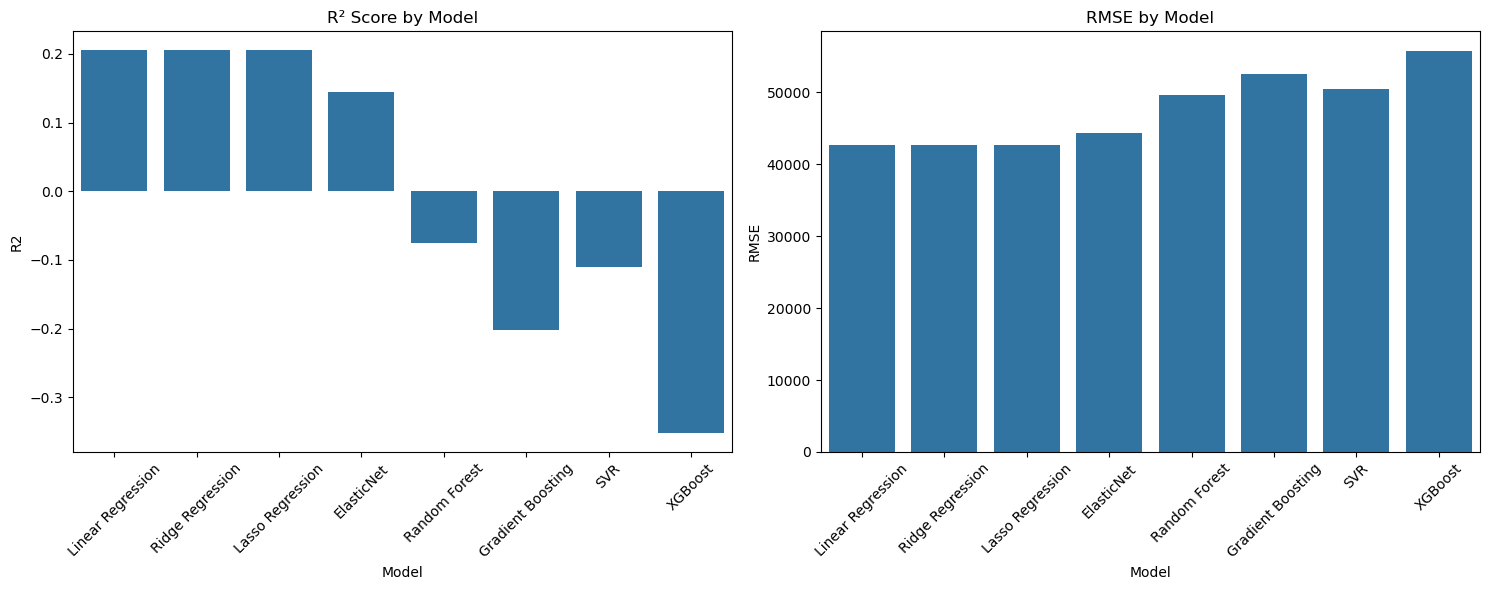

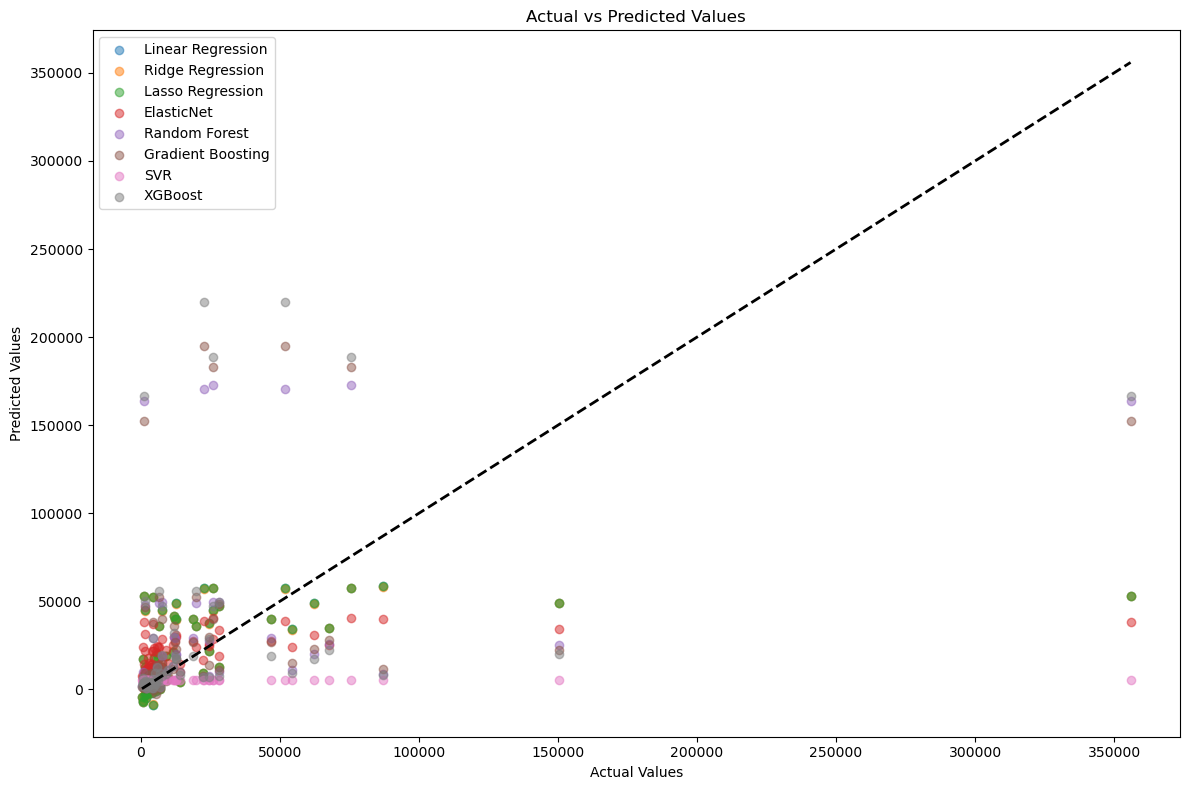

In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
gas_df_f = pd.read_csv('imputed_modelling_gas_data.csv')
weather_df = pd.read_csv('weather_monthly.csv')

# Filter F buildings
gas_df_f = gas_df_f[gas_df_f['Meter_Location'].str.startswith('F')]

def prepare_data(gas_df_f, weather_df):
    # Melt the dataframe
    melted_df = pd.melt(gas_df_f, 
                        id_vars=['Meter_Location'], 
                        var_name='Date', 
                        value_name='Gas_Consumption')
    
    # Extract time components
    melted_df['month'] = pd.to_datetime(melted_df['Date'].str.split('_').str[0], format='%b').dt.month
    melted_df['year'] = pd.to_datetime(melted_df['Date'].str.split('_').str[1], format='%Y').dt.year
    
    # Create cyclical features
    melted_df['month_sin'] = np.sin(2 * np.pi * melted_df['month']/12)
    melted_df['month_cos'] = np.cos(2 * np.pi * melted_df['month']/12)
    
    # Create building usage tiers
    building_stats = melted_df.groupby('Meter_Location')['Gas_Consumption'].mean()
    usage_tiers = pd.qcut(building_stats, q=3, labels=['low', 'medium', 'high'])
    melted_df['usage_tier'] = melted_df['Meter_Location'].map(usage_tiers)
    
    # Create dummy variables for usage tiers
    tier_dummies = pd.get_dummies(melted_df['usage_tier'], prefix='tier')
    
    # Merge with weather data
    final_df = pd.merge(melted_df, weather_df, on='Date', how='inner')
    
    # Select features
    X = pd.concat([
        final_df[['temp_min', 'month_sin', 'month_cos', 'humidity_mean']],
        tier_dummies,
        final_df[['year']]
    ], axis=1)
    
    y = final_df['Gas_Consumption']
    
    return X, y, final_df

def evaluate_models(X, y, models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features (excluding dummy variables and year)
    feature_cols = ['temp_min', 'month_sin', 'month_cos', 'humidity_mean']
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[feature_cols] = scaler.fit_transform(X_train[feature_cols])
    X_test_scaled[feature_cols] = scaler.transform(X_test[feature_cols])
    
    results = []
    predictions = {}
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
        predictions[name] = y_pred
        
    return pd.DataFrame(results), predictions, y_test

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor(random_state=42)
}

# Prepare data and run models
X, y, final_df = prepare_data(gas_df_f, weather_df)
results, predictions, y_test = evaluate_models(X, y, models)

# Print results
print("\nModel Performance Metrics:")
print(results)

# Plot results
plt.figure(figsize=(15, 6))

# R² Score plot
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R2', data=results)
plt.xticks(rotation=45)
plt.title('R² Score by Model')

# RMSE plot
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=results)
plt.xticks(rotation=45)
plt.title('RMSE by Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 8))
for name, pred in predictions.items():
    plt.scatter(y_test, pred, label=name, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()


In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_features(gas_df, weather_df):
    # Melt the gas DataFrame to get proper time series format
    gas_melted = gas_df.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    
    # Convert month column to datetime
    gas_melted['month'] = pd.to_datetime(gas_melted['month'].str.replace('_', '-') + '-01')
    
    # Convert weather_df Date column to datetime
    weather_df['Date'] = pd.to_datetime(weather_df['Date'].str.replace('_', '-') + '-01')
    
    # Merge gas and weather data
    merged_data = pd.merge(gas_melted, weather_df, left_on='month', right_on='Date', how='left')
    
    # Create selected features
    features = pd.DataFrame({
        'month_sin': np.sin(2 * np.pi * merged_data['month'].dt.month / 12),
        'month_cos': np.cos(2 * np.pi * merged_data['month'].dt.month / 12),
        'consumption_lag1': merged_data.groupby('Meter_Location')['consumption'].shift(1).bfill(),
        'rolling_mean_3': merged_data.groupby('Meter_Location')['consumption']
            .rolling(3, min_periods=1).mean().reset_index(0, drop=True),
        'rolling_std_3': merged_data.groupby('Meter_Location')['consumption']
            .rolling(3, min_periods=1).std().reset_index(0, drop=True)
    })
    
    # Add seasonal indicators
    season_dummies = pd.get_dummies(
        merged_data['month'].dt.month.map(
            lambda m: 'Summer' if m in [12, 1, 2] else
            'Autumn' if m in [3, 4, 5] else
            'Winter' if m in [6, 7, 8] else 'Spring'
        ),
        prefix='season'
    )
    
    return pd.concat([features, season_dummies], axis=1), merged_data['consumption']

def optimize_rf_model(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    rf = RandomForestRegressor(random_state=40)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    
    return grid_search.best_estimator_, grid_search.best_params_, predictions

def main():
    # Load data
    gas_df = pd.read_csv('imputed_modelling_gas_data.csv')
    weather_df = pd.read_csv('weather_monthly.csv')

    # Prepare features and target
    X, y = prepare_features(gas_df, weather_df)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=40
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimize model
    best_model, best_params, predictions = optimize_rf_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    # Calculate metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'R2': r2_score(y_test, predictions)
    }
    
    return best_model, best_params, metrics

if __name__ == "__main__":
    best_model, best_params, metrics = main()
    
    print("Best Parameters:", best_params)
    print("Model Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Model Performance:
RMSE: 114196.31643829943
MAE: 16813.529729695503
R2: 0.2970784100769863


In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_features(gas_df, weather_df):
    # Melt the gas DataFrame to get proper time series format
    gas_melted = gas_df.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    
    # Convert month column to datetime
    gas_melted['month'] = pd.to_datetime(gas_melted['month'].str.replace('_', '-') + '-01')
    
    # Convert weather_df Date column to datetime
    weather_df['Date'] = pd.to_datetime(weather_df['Date'].str.replace('_', '-') + '-01')
    
    # Merge gas and weather data
    merged_data = pd.merge(gas_melted, weather_df, left_on='month', right_on='Date', how='left')
    
    # Create selected features
    features = pd.DataFrame({
        'month_sin': np.sin(2 * np.pi * merged_data['month'].dt.month / 12),
        'month_cos': np.cos(2 * np.pi * merged_data['month'].dt.month / 12),
        'consumption_lag1': merged_data.groupby('Meter_Location')['consumption'].shift(1).bfill(),
        'rolling_mean_3': merged_data.groupby('Meter_Location')['consumption']
            .rolling(3, min_periods=1).mean().reset_index(0, drop=True),
        'rolling_std_3': merged_data.groupby('Meter_Location')['consumption']
            .rolling(3, min_periods=1).std().reset_index(0, drop=True)
    })
    
    # Add seasonal indicators
    season_dummies = pd.get_dummies(
        merged_data['month'].dt.month.map(
            lambda m: 'Summer' if m in [12, 1, 2] else
            'Autumn' if m in [3, 4, 5] else
            'Winter' if m in [6, 7, 8] else 'Spring'
        ),
        prefix='season'
    )
    
    return pd.concat([features, season_dummies], axis=1), merged_data['consumption']

def optimize_rf_model(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [15, 20, 25],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    rf = RandomForestRegressor(random_state=40)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    
    return grid_search.best_estimator_, grid_search.best_params_, predictions

def evaluate_model(y_test, predictions):
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'R2': r2_score(y_test, predictions)
    }
    
    print("Model Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    return metrics

def main():
    # Load data
    gas_df = pd.read_csv('imputed_modelling_gas_data.csv')
    weather_df = pd.read_csv('weather_monthly.csv')

    # Prepare features and target
    X, y = prepare_features(gas_df, weather_df)
    
    # Train-test split with stratification for better generalization
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=40
    )
    
    # Scale features for better performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimize model with hyperparameter tuning
    best_model, best_params, predictions = optimize_rf_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    # Evaluate model performance
    metrics = evaluate_model(y_test, predictions)
    
    print("Best Parameters:", best_params)
    
if __name__ == "__main__":
    main()


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Model Performance:
RMSE: 114691.53986528177
MAE: 16629.76147103071
R2: 0.290968615272591
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_features(data):
    # First melt the DataFrame to get proper time series format
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    
    # Convert month column to datetime
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    # Create features
    features = pd.DataFrame({
       # 'month_sin': np.sin(2 * np.pi * data_melted['month'].dt.month/12),
      #  'month_cos': np.cos(2 * np.pi * data_melted['month'].dt.month/12),
        'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1).bfill(),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
       # 'rolling_std_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).std().reset_index(0, drop=True)
    })
    
    # Add seasonal indicators
    '''
    season_dummies = pd.get_dummies(
        data_melted['month'].dt.month.map(
            lambda m: 'Summer' if m in [12,1,2] else
            'Autumn' if m in [3,4,5] else
            'Winter' if m in [6,7,8] else 'Spring'
        ),
        prefix='season'
    )
    '''
    # Add building indicators
   # building_dummies = pd.get_dummies(data_melted['Meter_Location'], prefix='building')
    
    return pd.concat([features, #season_dummies, building_dummies
                     ], axis=1), data_melted['consumption']

def optimize_rf_model(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 8,12, 16],
        'min_samples_split': [3, 7, 10],
        'min_samples_leaf': [1, 2, 3]
    }
    
    rf = RandomForestRegressor(random_state=20)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    
    return grid_search.best_estimator_, grid_search.best_params_, predictions

def main():
    # Load data
    data = pd.read_csv('imputed_modelling_gas_data.csv')

    # Prepare features and target
    X, y = prepare_features(data)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=20
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimize model
    best_model, best_params, predictions = optimize_rf_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    # Calculate metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'R2': r2_score(y_test, predictions)
    }
    
    return best_model, best_params, metrics

if __name__ == "__main__":
    best_model, best_params, metrics = main()
    print("Best Parameters:", best_params)
    print("Model Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}
Model Performance:
RMSE: 23629.569861768217
MAE: 7187.234724090878
R2: 0.7413120555199182


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Train Performance:
RMSE: 3405.0399257055506
MAE: 1643.3376640283973
R2: 0.8516057789631161

Test Performance:
RMSE: 4259.712046131984
MAE: 2400.0849204477327
R2: 0.7604519350475853


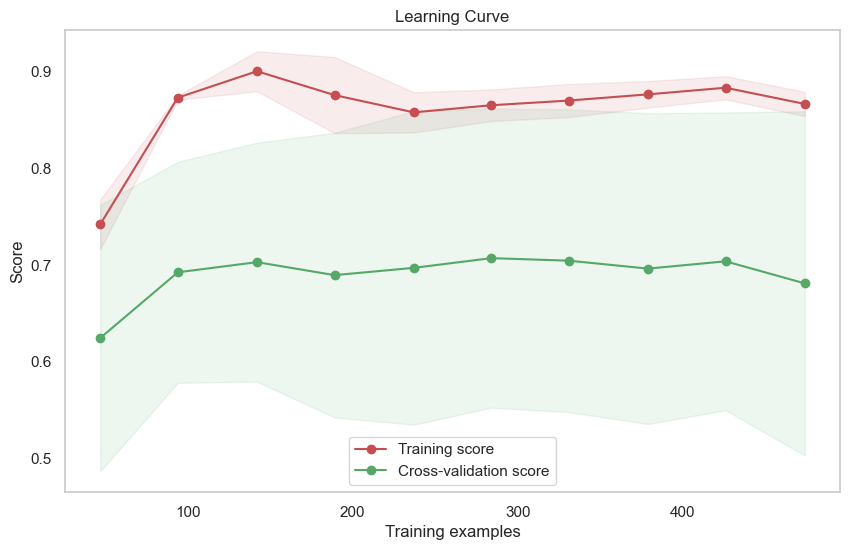

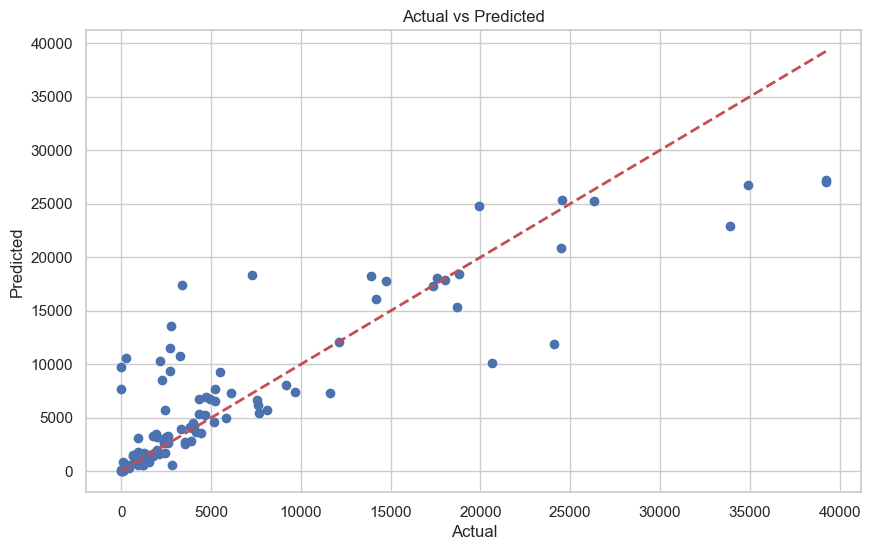

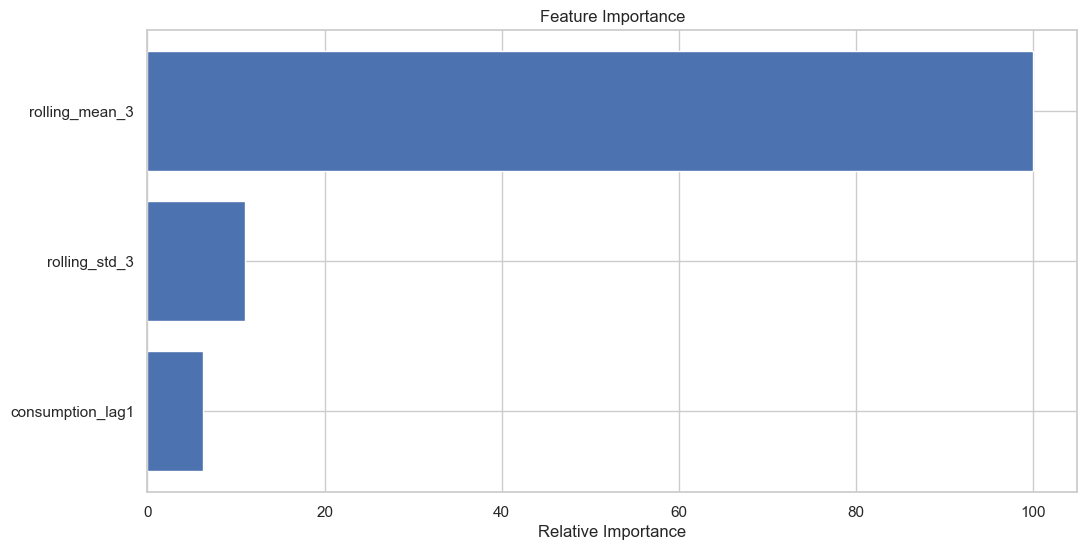

In [204]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_features(data):
    # First melt the DataFrame to get proper time series format
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    
    # Convert month column to datetime
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    # Create features
    features = pd.DataFrame({
        #'month_sin': np.sin(2 * np.pi * data_melted['month'].dt.month/12),
      #  'month_cos': np.cos(2 * np.pi * data_melted['month'].dt.month/12),
       'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1).bfill(),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
        'rolling_std_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).std().reset_index(0, drop=True)
    })
    
    # Add seasonal indicators
    '''
    season_dummies = pd.get_dummies(
        data_melted['month'].dt.month.map(
            lambda m: 'Summer' if m in [12,1,2] else
            'Autumn' if m in [3,4,5] else
            'Winter' if m in [6,7,8] else 'Spring'
        ),
        prefix='season'
    )
    '''
    # Add building indicators
   # building_dummies = pd.get_dummies(data_melted['Meter_Location'], prefix='building')
    
    return pd.concat([features, #season_dummies, building_dummies
                     ], axis=1), data_melted['consumption']

def optimize_rf_model(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=40)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=10,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    
    return grid_search.best_estimator_, grid_search.best_params_, predictions

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_predictions(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

def plot_feature_importance(model, X):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    plt.show()

def main():
    # Load data
    data = pd.read_csv('imputed_modelling_gas_data.csv')

    # Prepare features and target
    X, y = prepare_features(data)

    # Handle anomalies in target variable
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    X, y = X[mask], y[mask]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=20
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimize model
    best_model, best_params, predictions = optimize_rf_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    # Calculate metrics
    train_predictions = best_model.predict(X_train_scaled)
    test_predictions = best_model.predict(X_test_scaled)
    
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, train_predictions)),
        'MAE': mean_absolute_error(y_train, train_predictions),
        'R2': r2_score(y_train, train_predictions)
    }
    
    test_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, test_predictions)),
        'MAE': mean_absolute_error(y_test, test_predictions),
        'R2': r2_score(y_test, test_predictions)
    }
    
    # Print results
    print("Best Parameters:", best_params)
    print("\nTrain Performance:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value}")
    print("\nTest Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value}")
    
    # Plot results
    plot_learning_curve(best_model, X, y)
    plot_predictions(y_test, test_predictions)
    plot_feature_importance(best_model, X)
    
    return best_model, best_params, train_metrics, test_metrics

if __name__ == "__main__":
    best_model, best_params, train_metrics, test_metrics = main()


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}

Train Performance:
RMSE: 4184.594457559089
MAE: 2196.83730322346
R2: 0.7758806665174875

Test Performance:
RMSE: 5296.812104134402
MAE: 2873.614218407749
R2: 0.6296082391209745


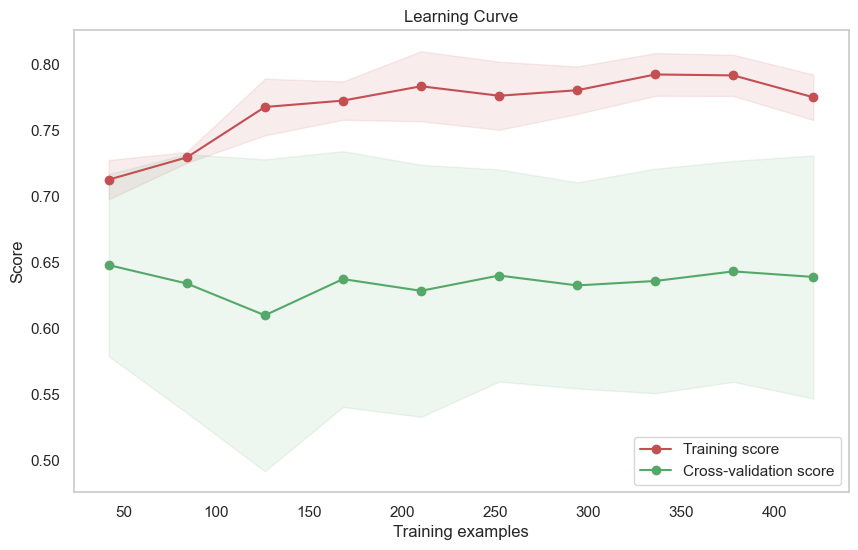

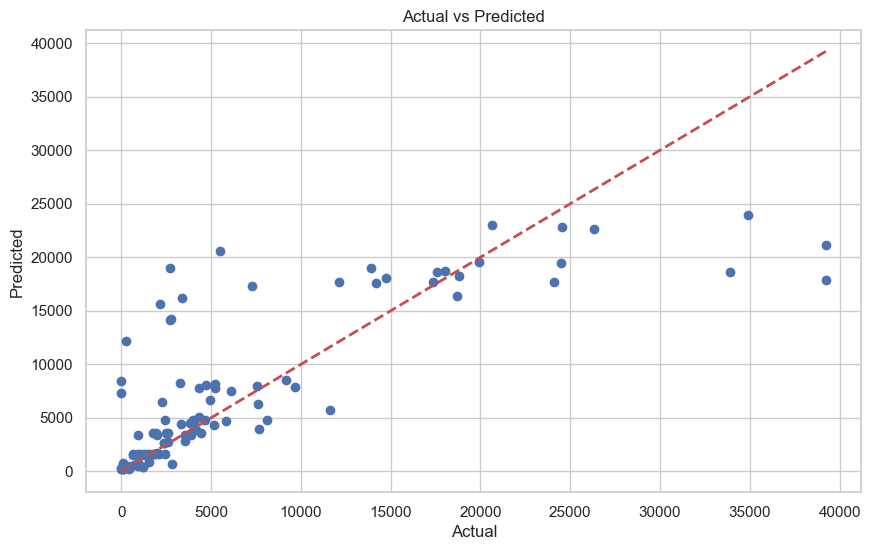

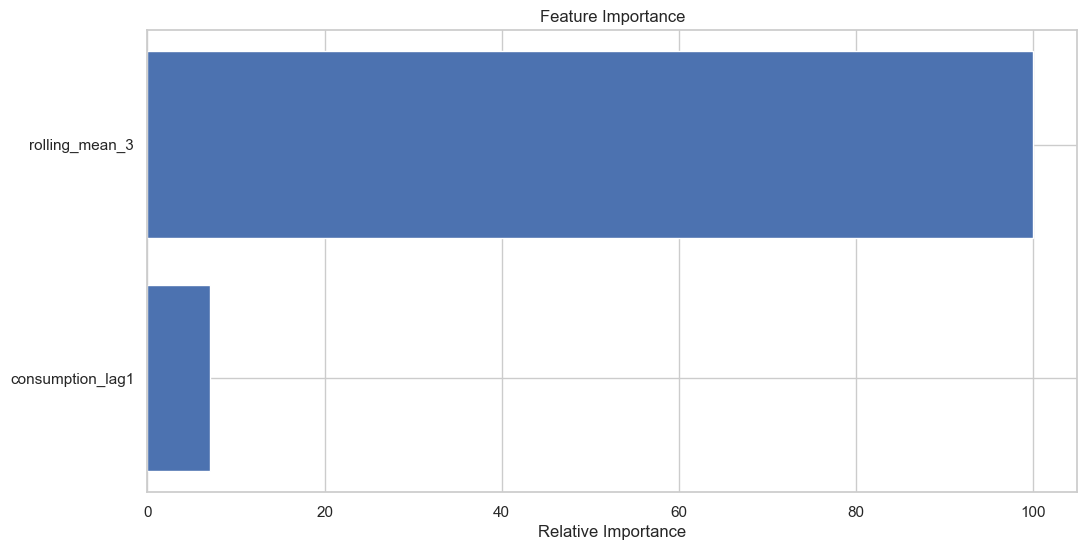

In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_features(data):
    # First melt the DataFrame to get proper time series format
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    
    # Convert month column to datetime
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    # Create features
    features = pd.DataFrame({
        #'month_sin': np.sin(2 * np.pi * data_melted['month'].dt.month/12),
      #  'month_cos': np.cos(2 * np.pi * data_melted['month'].dt.month/12),
        'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1).bfill(),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
       # 'rolling_std_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).std().reset_index(0, drop=True)
    })
    
    # Add seasonal indicators
    '''
    season_dummies = pd.get_dummies(
        data_melted['month'].dt.month.map(
            lambda m: 'Summer' if m in [12,1,2] else
            'Autumn' if m in [3,4,5] else
            'Winter' if m in [6,7,8] else 'Spring'
        ),
        prefix='season'
    )
    '''
    # Add building indicators
   # building_dummies = pd.get_dummies(data_melted['Meter_Location'], prefix='building')
    
    return pd.concat([features, #season_dummies, building_dummies
                     ], axis=1), data_melted['consumption']

def optimize_rf_model(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 2, 4, 8],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [5, 8, 12]
    }
    
    rf = RandomForestRegressor(random_state=20)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    
    return grid_search.best_estimator_, grid_search.best_params_, predictions

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_predictions(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

def plot_feature_importance(model, X):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    plt.show()

def main():
    # Load data
    data = pd.read_csv('imputed_modelling_gas_data.csv')

    # Prepare features and target
    X, y = prepare_features(data)

    # Handle anomalies in target variable
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    X, y = X[mask], y[mask]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=20
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimize model
    best_model, best_params, predictions = optimize_rf_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    # Calculate metrics
    train_predictions = best_model.predict(X_train_scaled)
    test_predictions = best_model.predict(X_test_scaled)
    
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, train_predictions)),
        'MAE': mean_absolute_error(y_train, train_predictions),
        'R2': r2_score(y_train, train_predictions)
    }
    
    test_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, test_predictions)),
        'MAE': mean_absolute_error(y_test, test_predictions),
        'R2': r2_score(y_test, test_predictions)
    }
    
    # Print results
    print("Best Parameters:", best_params)
    print("\nTrain Performance:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value}")
    print("\nTest Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value}")
    
    # Plot results
    plot_learning_curve(best_model, X, y)
    plot_predictions(y_test, test_predictions)
    plot_feature_importance(best_model, X)
    
    return best_model, best_params, train_metrics, test_metrics

if __name__ == "__main__":
    best_model, best_params, train_metrics, test_metrics = main()


In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_features(data):
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    features = pd.DataFrame({
        #'month_sin': np.sin(2 * np.pi * data_melted['month'].dt.month / 12),
        #'month_cos': np.cos(2 * np.pi * data_melted['month'].dt.month / 12),
        'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
       # 'rolling_std_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).std().reset_index(0, drop=True)
    })
    
    building_dummies = pd.get_dummies(data_melted['Meter_Location'], prefix='building')
    
    return pd.concat([features, building_dummies], axis=1), data_melted['consumption']

def optimize_model(X_train, X_test, y_train, y_test):
    param_dist = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_iter': [100, 200, 300],
        'max_depth': [None, 1, 3, 6],
        'min_samples_leaf': [1, 3, 5],
        'max_leaf_nodes': [None, 3, 5, 10],
        'l2_regularization': [0.0, 0.1, 1.0]
    }
    
    hgb = HistGradientBoostingRegressor(random_state=40)
    
    random_search = RandomizedSearchCV(
        estimator=hgb,
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        random_state=40
    )
    
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    predictions = best_model.predict(X_test)
    
    return best_model, best_params, predictions

def main():
    data = pd.read_csv('imputed_modelling_gas_data.csv')
    X, y = prepare_features(data)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_model, best_params, predictions = optimize_model(X_train_scaled, X_test_scaled, y_train, y_test)
    
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'R2': r2_score(y_test, predictions)
    }
    
    print("Best Parameters:", best_params)
    print("Model Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

if __name__ == "__main__":
    main()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'min_samples_leaf': 1, 'max_leaf_nodes': 10, 'max_iter': 100, 'max_depth': 3, 'learning_rate': 0.2, 'l2_regularization': 1.0}
Model Performance:
RMSE: 35996.09042917262
MAE: 11133.612844078503
R2: 0.6584050880081618


In [118]:
def main():
    # Load data
    data = pd.read_csv('imputed_modelling_gas_data.csv')
    
    # Prepare features and target
    X_raw, y_raw = prepare_features(data)
    
    # Handle anomalies in the target variable
    X_cleaned, y_cleaned = handle_anomalies(X_raw, y_raw)
    
    # Train-test split
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
        X_cleaned,
        y_cleaned,
        test_size=0.2,
        random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Optimize model and evaluate performance
    best_model_hgb, best_params_hgb, predictions_hgb = optimize_model(
        X_train_scaled,
        X_test_scaled,
        y_train_raw,
        y_test_raw
    )
    
    # Train and test metrics for HistGradientBoostingRegressor
    train_predictions_hgb = best_model_hgb.predict(X_train_scaled)
    test_predictions_hgb = best_model_hgb.predict(X_test_scaled)
    
    train_metrics_hgb = {
        'RMSE': np.sqrt(mean_squared_error(y_train_raw, train_predictions_hgb)),
        'MAE': mean_absolute_error(y_train_raw, train_predictions_hgb),
        'R2': r2_score(y_train_raw, train_predictions_hgb)
    }
    
    test_metrics_hgb = {
        'RMSE': np.sqrt(mean_squared_error(y_test_raw, test_predictions_hgb)),
        'MAE': mean_absolute_error(y_test_raw, test_predictions_hgb),
        'R2': r2_score(y_test_raw, test_predictions_hgb)
    }
    
    print("Best Parameters (HistGradientBoosting):", best_params_hgb)
    
    print("\nTrain Performance (HistGradientBoosting):")
    for metric_name_hgb, value in train_metrics_hgb.items():
        print(f"{metric_name_hgb}: {value:.4f}")
    
    print("\nTest Performance (HistGradientBoosting):")
    for metric_name_hgb, value in test_metrics_hgb.items():
        print(f"{metric_name_hgb}: {value:.4f}")
    
    # Plot learning curve
    plot_learning_curve(best_model_hgb, X_train_scaled, y_train_raw, "Learning Curve for HistGradientBoostingRegressor")

if __name__ == "__main__":
    main()



NameError: name 'handle_anomalies' is not defined

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'min_samples_leaf': 20, 'max_leaf_nodes': 10, 'max_iter': 100, 'max_depth': 7, 'learning_rate': 0.05, 'l2_regularization': 0.5}

Train Performance:
RMSE: 3706.3367
MAE: 1888.9559
R2: 0.8139

Test Performance:
RMSE: 6092.7923
MAE: 3350.5392
R2: 0.6056


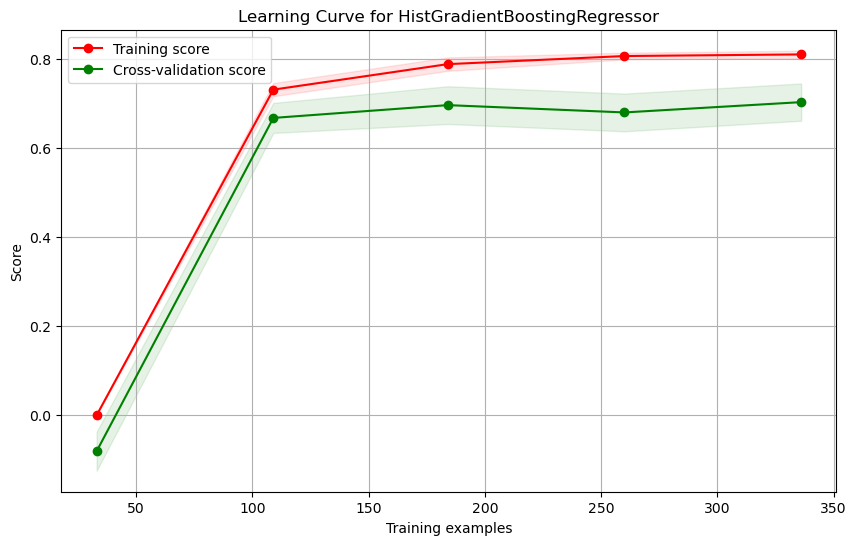

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def prepare_features(data):
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    features = pd.DataFrame({
        'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
    })
    
    building_dummies = pd.get_dummies(data_melted['Meter_Location'], prefix='building')
    
    return pd.concat([features, building_dummies], axis=1), data_melted['consumption']

def handle_anomalies(X, y):
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    return X[mask], y[mask]

def optimize_model(X_train, X_test, y_train, y_test):
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_iter': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [10, 20, 30],
        'max_leaf_nodes': [None, 10, 20],
        'l2_regularization': [0.1, 0.5, 1.0]
    }
    
    hgb = HistGradientBoostingRegressor(random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=hgb,
        param_distributions=param_dist,
        n_iter=30,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    predictions = best_model.predict(X_test)
    
    return best_model, best_params, predictions

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def main():
    data = pd.read_csv('imputed_modelling_gas_data.csv')
    
    X_raw, y_raw = prepare_features(data)
    
    X_cleaned, y_cleaned = handle_anomalies(X_raw, y_raw)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_cleaned, y_cleaned, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_model, best_params, predictions = optimize_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    train_predictions = best_model.predict(X_train_scaled)
    test_predictions = best_model.predict(X_test_scaled)
    
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, train_predictions)),
        'MAE': mean_absolute_error(y_train, train_predictions),
        'R2': r2_score(y_train, train_predictions)
    }
    
    test_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, test_predictions)),
        'MAE': mean_absolute_error(y_test, test_predictions),
        'R2': r2_score(y_test, test_predictions)
    }
    
    print("Best Parameters:", best_params)
    print("\nTrain Performance:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nTest Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    plot_learning_curve(best_model, X_train_scaled, y_train, "Learning Curve for HistGradientBoostingRegressor")

if __name__ == "__main__":
    main()



Fitting 5 folds for each of 30 candidates, totalling 150 fits

Test Performance:


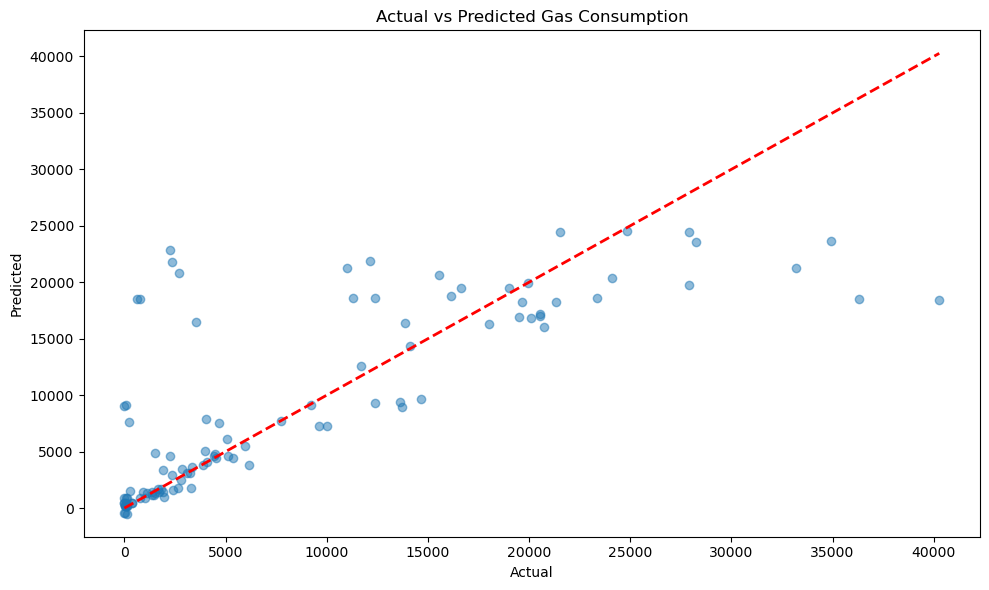

Best Parameters: {'min_samples_leaf': 20, 'max_leaf_nodes': 10, 'max_iter': 100, 'max_depth': 7, 'learning_rate': 0.05, 'l2_regularization': 0.5}

Train Performance:
RMSE: 3692.9205
MAE: 1883.1218
R2: 0.8255

Test Performance:
RMSE: 5029.4685
MAE: 2722.1283
R2: 0.6661


In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def prepare_features(data):
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    features = pd.DataFrame({
        'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
    })
    
    building_dummies = pd.get_dummies(data_melted['Meter_Location'], prefix='building')
    
    return pd.concat([features, building_dummies], axis=1), data_melted['consumption']

def handle_anomalies(X, y):
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    return X[mask], y[mask]

def optimize_model(X_train, X_test, y_train, y_test):
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_iter': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [10, 20, 30],
        'max_leaf_nodes': [None, 10, 20],
        'l2_regularization': [0.1, 0.5, 1.0]
    }
    
    hgb = HistGradientBoostingRegressor(random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=hgb,
        param_distributions=param_dist,
        n_iter=30,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    predictions = best_model.predict(X_test)
    
    return best_model, best_params, predictions

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Gas Consumption")
    plt.tight_layout()
    plt.show()

def main():
    data = pd.read_csv('imputed_modelling_gas_data.csv')
    
    X_raw, y_raw = prepare_features(data)
    
    X_cleaned, y_cleaned = handle_anomalies(X_raw, y_raw)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_cleaned, y_cleaned, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_model, best_params, predictions = optimize_model(
        X_train_scaled, X_test_scaled, y_train.values.ravel(), y_test.values.ravel()
     )
    
     # Train and Test Metrics
    print("\nTest Performance:")
    plot_actual_vs_predicted(y_test,predictions)

    print("Best Parameters:", best_params)
    print("\nTrain Performance:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nTest Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
if __name__ == "__main__":
     main()



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters (HistGradientBoosting): {'min_samples_leaf': 20, 'max_leaf_nodes': 10, 'max_iter': 100, 'max_depth': 7, 'learning_rate': 0.05, 'l2_regularization': 0.5}

Train Performance (HistGradientBoosting):
RMSE: 3706.3367
MAE: 1888.9559
R2: 0.8139

Test Performance (HistGradientBoosting):
RMSE: 6092.7923
MAE: 3350.5392
R2: 0.6056


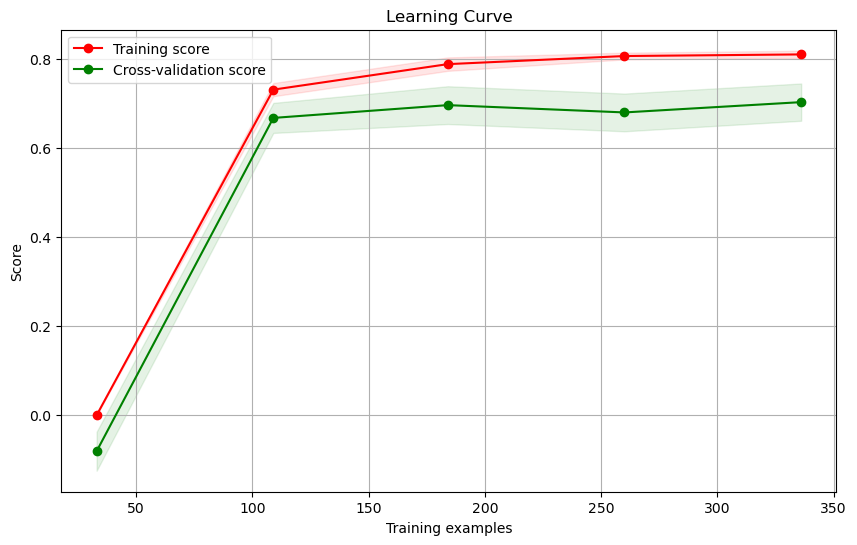

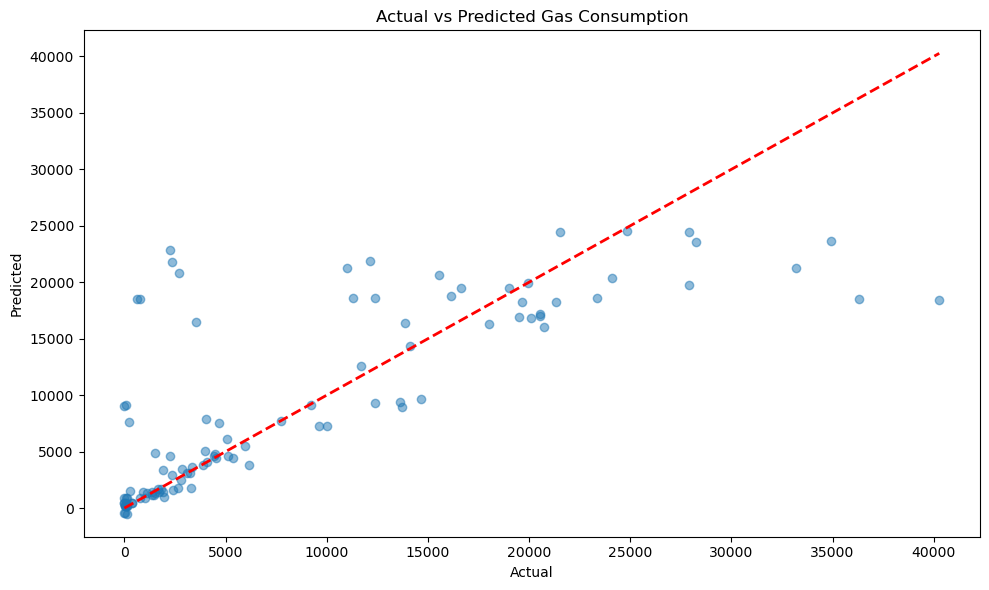

In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Prepare features
def prepare_features(data):
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    features = pd.DataFrame({
        'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
    })
    
    building_dummies = pd.get_dummies(data_melted['Meter_Location'], prefix='building')
    
    return pd.concat([features, building_dummies], axis=1), data_melted['consumption']

# Handle anomalies
def handle_anomalies(X, y):
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    return X[mask], y[mask]

# Optimize model
def optimize_model(X_train, X_test, y_train, y_test):
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_iter': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [10, 20, 30],
        'max_leaf_nodes': [None, 10, 20],
        'l2_regularization': [0.1, 0.5, 1.0]
    }
    
    hgb = HistGradientBoostingRegressor(random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=hgb,
        param_distributions=param_dist,
        n_iter=30,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    predictions = best_model.predict(X_test)
    
    return best_model, best_params, predictions

# Plot learning curve
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Plot actual vs predicted
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Gas Consumption")
    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Load data
    data = pd.read_csv('imputed_modelling_gas_data.csv')
    
    # Prepare features and target
    X_raw, y_raw = prepare_features(data)
    
    # Handle anomalies in the target variable
    X_cleaned, y_cleaned = handle_anomalies(X_raw, y_raw)
    
    # Train-test split
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
        X_cleaned,
        y_cleaned,
        test_size=0.2,
        random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Optimize model and evaluate performance
    best_model_hgb, best_params_hgb, predictions_hgb = optimize_model(
        X_train_scaled,
        X_test_scaled,
        y_train_raw,
        y_test_raw
    )
    
    # Train and test metrics for HistGradientBoostingRegressor
    train_predictions_hgb = best_model_hgb.predict(X_train_scaled)
    
    train_metrics_hgb = {
        'RMSE': np.sqrt(mean_squared_error(y_train_raw.values.ravel(), train_predictions_hgb)),
        'MAE': mean_absolute_error(y_train_raw.values.ravel(), train_predictions_hgb),
        'R2': r2_score(y_train_raw.values.ravel(), train_predictions_hgb)
    }
    
    test_metrics_hgb = {
        'RMSE': np.sqrt(mean_squared_error(y_test_raw.values.ravel(), predictions_hgb)),
        'MAE': mean_absolute_error(y_test_raw.values.ravel(), predictions_hgb),
        'R2': r2_score(y_test_raw.values.ravel(), predictions_hgb)
    }
    
    print("Best Parameters (HistGradientBoosting):", best_params_hgb)
    
    print("\nTrain Performance (HistGradientBoosting):")
    for metric_name_hgb in train_metrics_hgb:
        print(f"{metric_name_hgb}: {train_metrics_hgb[metric_name_hgb]:.4f}")
        
    
    print("\nTest Performance (HistGradientBoosting):")
    for metric_name_hgb in test_metrics_hgb:
        print(f"{metric_name_hgb}: {test_metrics_hgb[metric_name_hgb]:.4f}")
        
    
     # Plot learning curve
    
    plot_learning_curve(best_model_hgb,X_train_scaled,y_train_raw,"Learning Curve")

     # Plot actual vs predicted values for the test set
    
    plot_actual_vs_predicted(y_test_raw,predictions_hgb)

if __name__ == "__main__":
     main()


In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and preprocess data
def preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data_melted = data.melt(id_vars=['Meter_Location'], var_name='month', value_name='consumption')
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    data_melted = data_melted.sort_values(by=['Meter_Location', 'month'])
    return data_melted

# Create features
def create_features(data):
    data['month_num'] = data['month'].dt.month
    data['year'] = data['month'].dt.year
    data['month_sin'] = np.sin(2 * np.pi * data['month_num'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month_num'] / 12)
    data['consumption_lag1'] = data.groupby('Meter_Location')['consumption'].shift(1)
    data['rolling_mean_3'] = data.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
    data = data.dropna()
    return data

# Prepare LSTM input
def prepare_lstm_data(data, sequence_length):
    X, y = [], []
    for meter in data['Meter_Location'].unique():
        meter_data = data[data['Meter_Location'] == meter]
        for i in range(len(meter_data) - sequence_length):
            X.append(meter_data.iloc[i:i+sequence_length][['month_sin', 'month_cos', 'consumption_lag1', 'rolling_mean_3']].values)
            y.append(meter_data.iloc[i+sequence_length]['consumption'])
    return np.array(X), np.array(y)

# Create LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Main function
def main():
    # Load and preprocess data
    file_path = 'imputed_modelling_gas_data.csv'
    data = preprocess_data(file_path)
    data = create_features(data)

    # Prepare LSTM input
    sequence_length = 12  # Use 12 months of historical data to predict the next month
    X, y = prepare_lstm_data(data, sequence_length)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize features using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # Create and train LSTM model
    model = create_lstm_model((sequence_length, X_train.shape[-1]))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared Score: {r2}")

if __name__ == "__main__":
    main()



In [138]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Drop non-numeric columns (e.g., 'Meter_Location') to focus on numeric data
X = df.drop(['Meter_Location'], axis=1)

# Example target variable (e.g., 'Apr_2023')
y = X['Apr_2023']

# Feature creation process
def create_features(X):
    # Convert column names to datetime for month-based features
    dates = pd.to_datetime(X.columns, format='%b_%Y', errors='coerce')
    valid_dates = dates.dropna()

    # Ensure valid_dates length matches the number of columns
    if len(valid_dates) != X.shape[1]:
        raise ValueError("Mismatch between valid dates and dataset columns")

    # Create month_sin and month_cos features
    month_sin = np.sin(valid_dates.month * 2 * np.pi / 12)
    month_cos = np.cos(valid_dates.month * 2 * np.pi / 12)

    # Add month_sin and month_cos as new columns for all rows
    X['month_sin'] = np.tile(month_sin, (X.shape[0], 1)).mean(axis=1)
    X['month_cos'] = np.tile(month_cos, (X.shape[0], 1)).mean(axis=1)

    # Create lag features (e.g., consumption_lag1)
    X['consumption_lag1'] = X.shift(1, axis=1).iloc[:, -1]

    # Create rolling mean and rolling standard deviation features
    X['rolling_mean_3'] = X.iloc[:, :-3].rolling(window=3, axis=1).mean().iloc[:, -1]
    X['rolling_std_3'] = X.iloc[:, :-3].rolling(window=3, axis=1).std().iloc[:, -1]

    return X

# Apply feature creation
try:
    df_features_fixed = create_features(X.copy())
    print("Feature creation successful. New dataset shape:", df_features_fixed.shape)
except ValueError as e:
    print("Error during feature creation:", e)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features_fixed)
X_scaled = pd.DataFrame(X_scaled, columns=df_features_fixed.columns)

# Recursive Feature Elimination (RFE)
model = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_scaled, y)
selected_features_rfe = df_features_fixed.columns[rfe.support_].tolist()

print("RFE selected features:", selected_features_rfe)

# Variance Thresholding
vt = VarianceThreshold(threshold=0.1)
vt.fit(X_scaled)
selected_features_vt = df_features_fixed.columns[vt.get_support()].tolist()

print("Variance Thresholding selected features:", selected_features_vt)

# Random Forest Feature Importance
rf = RandomForestRegressor(random_state=42)
rf.fit(X_scaled, y)
feature_importance = pd.Series(rf.feature_importances_, index=df_features_fixed.columns).sort_values(ascending=False)
selected_features_rf = feature_importance.head(10).index.tolist()

print("Random Forest selected features:", selected_features_rf)

# Validate features
def validate_features(X, y, selected_features):
    X_selected = X[selected_features]
    model = RandomForestRegressor(random_state=42)
    model.fit(X_selected, y)
    return model.score(X_selected, y)

print("RFE validation score:", validate_features(X_scaled, y, selected_features_rfe))
print("Variance Thresholding validation score:", validate_features(X_scaled, y, selected_features_vt))
print("Random Forest validation score:", validate_features(X_scaled, y, selected_features_rf))


C:\Users\sugan\AppData\Local\Temp\ipykernel_8716\20789146.py:38: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  X['rolling_mean_3'] = X.iloc[:, :-3].rolling(window=3, axis=1).mean().iloc[:, -1]
C:\Users\sugan\AppData\Local\Temp\ipykernel_8716\20789146.py:39: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  X['rolling_std_3'] = X.iloc[:, :-3].rolling(window=3, axis=1).std().iloc[:, -1]


Feature creation successful. New dataset shape: (17, 39)
RFE selected features: ['Dec_2022', 'Feb_2023', 'Mar_2023', 'Apr_2023', 'May_2023', 'Feb_2024', 'Mar_2024', 'Apr_2024', 'Jul_2024', 'Sep_2024']
Variance Thresholding selected features: ['Jan_2022', 'Feb_2022', 'Mar_2022', 'Apr_2022', 'May_2022', 'Jun_2022', 'Jul_2022', 'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022', 'Dec_2022', 'Jan_2023', 'Feb_2023', 'Mar_2023', 'Apr_2023', 'May_2023', 'Jun_2023', 'Jul_2023', 'Aug_2023', 'Sep_2023', 'Oct_2023', 'Nov_2023', 'Dec_2023', 'Jan_2024', 'Feb_2024', 'Mar_2024', 'Apr_2024', 'May_2024', 'Jun_2024', 'Jul_2024', 'Aug_2024', 'Sep_2024', 'Oct_2024', 'rolling_mean_3', 'rolling_std_3']
Random Forest selected features: ['Apr_2023', 'Apr_2024', 'Sep_2024', 'Mar_2024', 'Feb_2023', 'Apr_2022', 'Mar_2023', 'Dec_2022', 'Jul_2023', 'Jul_2022']
RFE validation score: 0.9341103472320847
Variance Thresholding validation score: 0.9156637301332602
Random Forest validation score: 0.9298234762729342


Error during feature creation: shapes (35,) and (34,) not aligned: 35 (dim 0) != 34 (dim 0)
Modified Dataset:
   month_sin  month_cos  consumption_lag1  rolling_mean_3  rolling_std_3
0   0.014706  -0.054883          0.014706     5969.333333    3383.565145
1   0.014706  -0.054883          0.014706     8914.000000    6300.139541
2   0.014706  -0.054883          0.014706    23132.000000   13587.116409
3   0.014706  -0.054883          0.014706    20805.000000   12711.686085
4   0.014706  -0.054883          0.014706     4504.666667    2669.564096
Validation Results: {'Null Values': {'month_sin': 0, 'month_cos': 0, 'consumption_lag1': 0, 'rolling_mean_3': 0, 'rolling_std_3': 0}, 'Dataset Shape': (17, 5)}


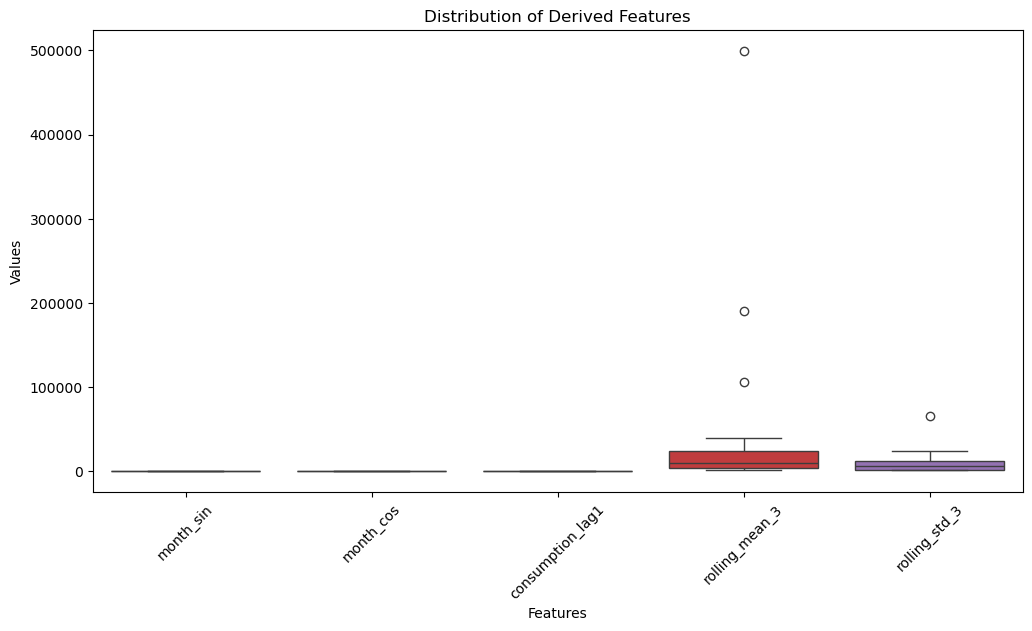

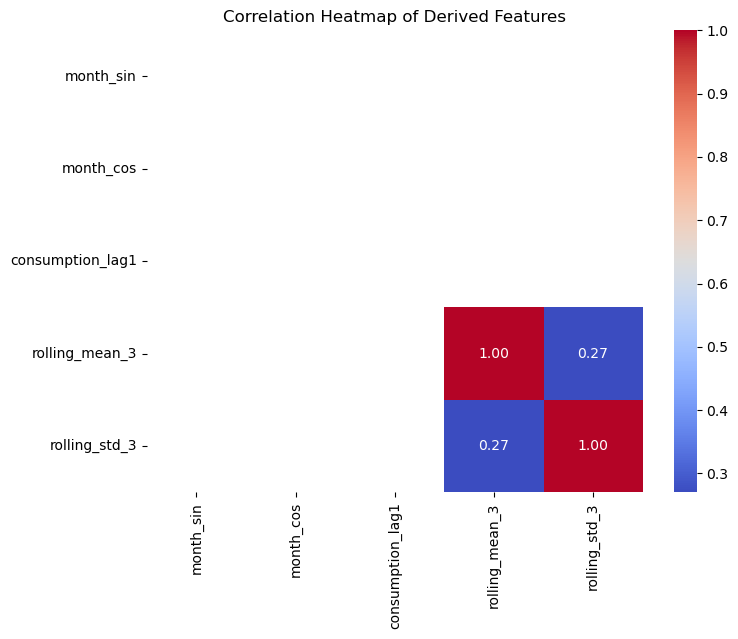

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace with your actual file path)
df = pd.read_csv('imputed_modelling_gas_data.csv')

# Drop non-numeric columns (e.g., 'Meter_Location') to focus on numeric data
X = df.drop(['Meter_Location'], axis=1)

# Feature creation process
def create_features(X):
    # Convert column names to datetime for month-based features
    dates = pd.to_datetime(X.columns, format='%b_%Y', errors='coerce')
    valid_dates = dates.dropna()

    # Ensure valid_dates length matches the number of columns
    if len(valid_dates) != X.shape[1]:
        raise ValueError("Mismatch between valid dates and dataset columns")

    # Create month_sin and month_cos features for each column (cyclical encoding)
    month_sin = np.sin(valid_dates.month * 2 * np.pi / 12)
    month_cos = np.cos(valid_dates.month * 2 * np.pi / 12)

    # Add month_sin and month_cos as new columns for each row
    X['month_sin'] = X.apply(lambda row: np.dot(row.values, month_sin), axis=1)
    X['month_cos'] = X.apply(lambda row: np.dot(row.values, month_cos), axis=1)

    # Create lag features (e.g., consumption_lag1)
    X['consumption_lag1'] = X.shift(1, axis=1).iloc[:, -1]

    # Create rolling mean and rolling standard deviation features
    X['rolling_mean_3'] = X.iloc[:, :-3].rolling(window=3, axis=1).mean().iloc[:, -1]
    X['rolling_std_3'] = X.iloc[:, :-3].rolling(window=3, axis=1).std().iloc[:, -1]

    return X

# Apply feature creation
try:
    df_features_fixed = create_features(X.copy())
    print("Feature creation successful. New dataset shape:", df_features_fixed.shape)
except ValueError as e:
    print("Error during feature creation:", e)

# Drop original month columns to retain only derived features
df_features_fixed = df_features_fixed[['month_sin', 'month_cos', 'consumption_lag1', 'rolling_mean_3', 'rolling_std_3']]

# Display the modified dataset
print("Modified Dataset:")
print(df_features_fixed.head())

# Validate the modified dataset
validation_results = {
    'Null Values': df_features_fixed.isnull().sum().to_dict(),
    'Dataset Shape': df_features_fixed.shape,
}
print("Validation Results:", validation_results)

# Plot the distribution of the derived features (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features_fixed)
plt.title('Distribution of Derived Features')
plt.ylabel('Values')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

# Plot a heatmap to show correlations between the derived features
plt.figure(figsize=(8, 6))
sns.heatmap(df_features_fixed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Derived Features')
plt.show()


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}

Train Performance:
RMSE: 4184.594457559089
MAE: 2196.83730322346
R2: 0.7758806665174875

Test Performance:
RMSE: 5296.812104134402
MAE: 2873.614218407749
R2: 0.6296082391209745


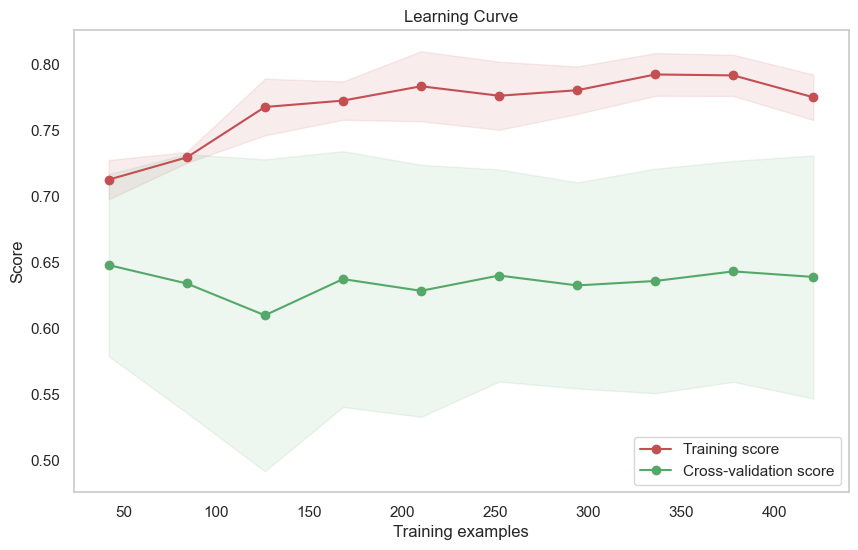

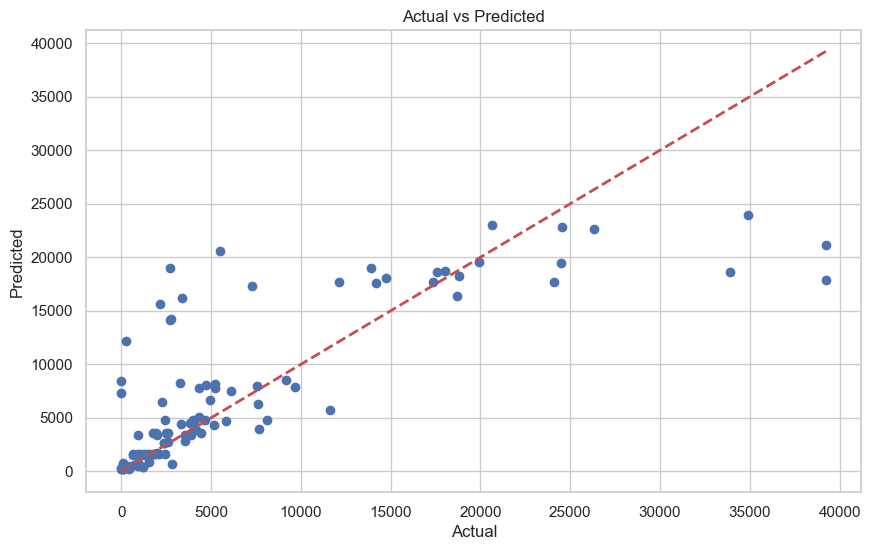

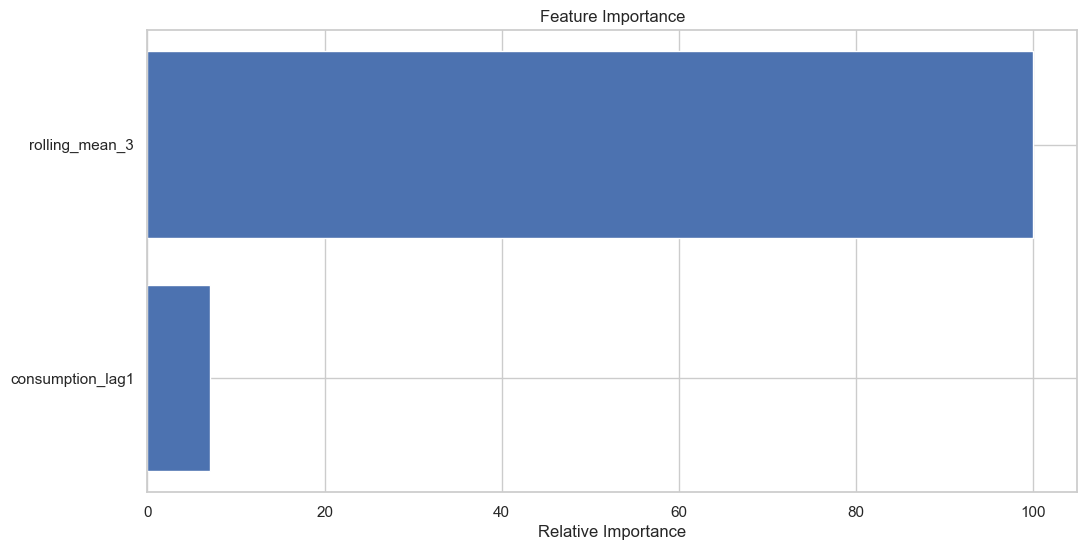

In [208]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_features(data):
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    features = pd.DataFrame({
        'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1).bfill(),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
    })
    
    return features, data_melted['consumption']

def handle_anomalies(X, y):
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    return X[mask], y[mask]

def optimize_rf_model(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 2, 4, 8],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [5, 8, 12]
    }
    
    rf = RandomForestRegressor(random_state=20)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    
    return grid_search.best_estimator_, grid_search.best_params_, predictions

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_predictions(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

def plot_feature_importance(model, X):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    plt.show()

def main():
    data = pd.read_csv('imputed_modelling_gas_data.csv')

    X, y = prepare_features(data)
    
    X, y = handle_anomalies(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=20
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_model, best_params, predictions = optimize_rf_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    train_predictions = best_model.predict(X_train_scaled)
    test_predictions = best_model.predict(X_test_scaled)
    
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, train_predictions)),
        'MAE': mean_absolute_error(y_train, train_predictions),
        'R2': r2_score(y_train, train_predictions)
    }
    
    test_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, test_predictions)),
        'MAE': mean_absolute_error(y_test, test_predictions),
        'R2': r2_score(y_test, test_predictions)
    }
    
    print("Best Parameters:", best_params)
    print("\nTrain Performance:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value}")
    print("\nTest Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value}")
    
    plot_learning_curve(best_model, X, y)
    plot_predictions(y_test, test_predictions)
    plot_feature_importance(best_model, X)
    
    return best_model, best_params, train_metrics, test_metrics

if __name__ == "__main__":
    best_model, best_params, train_metrics, test_metrics = main()


C:\Users\sugan\AppData\Local\Temp\ipykernel_20996\930389205.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], y[mask]


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}

Train Performance:
RMSE: 8123.9656936345145
MAE: 6325.029953112186
R2: 0.17541670501856

Test Performance:
RMSE: 8748.764782858896
MAE: 7070.253251471463
R2: -0.10565316034228656


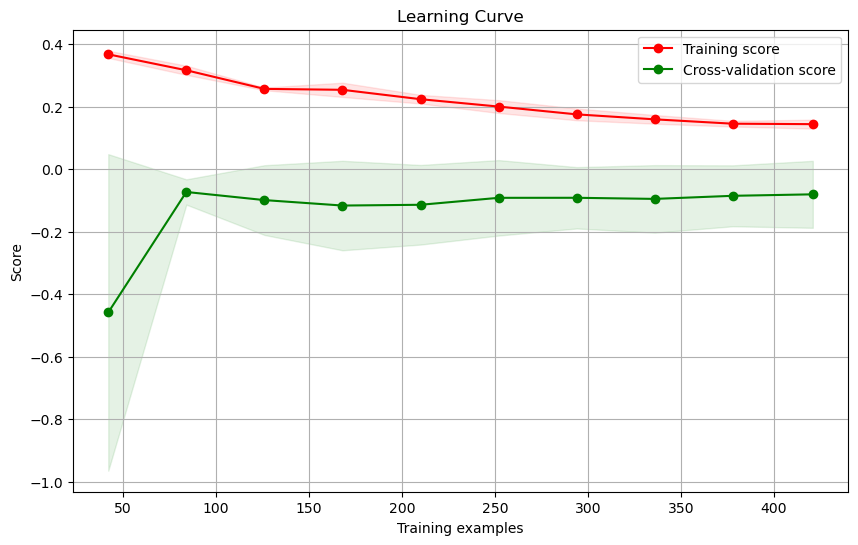

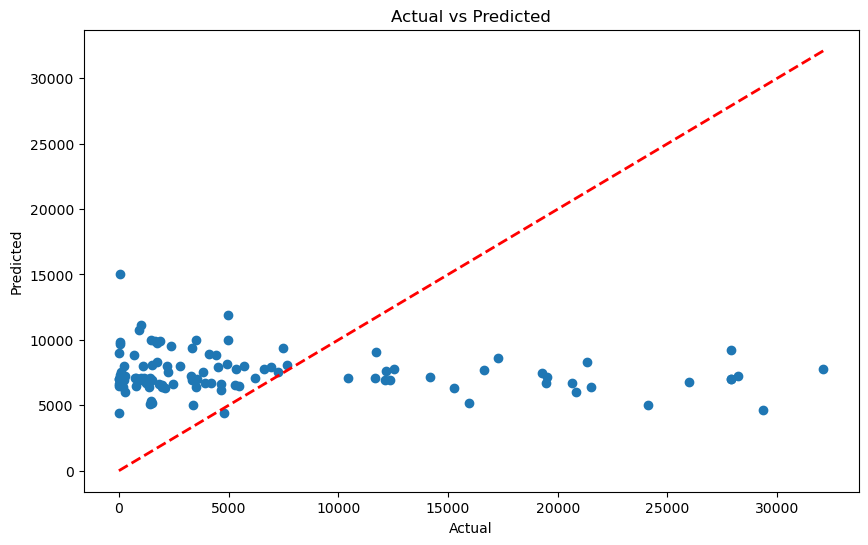

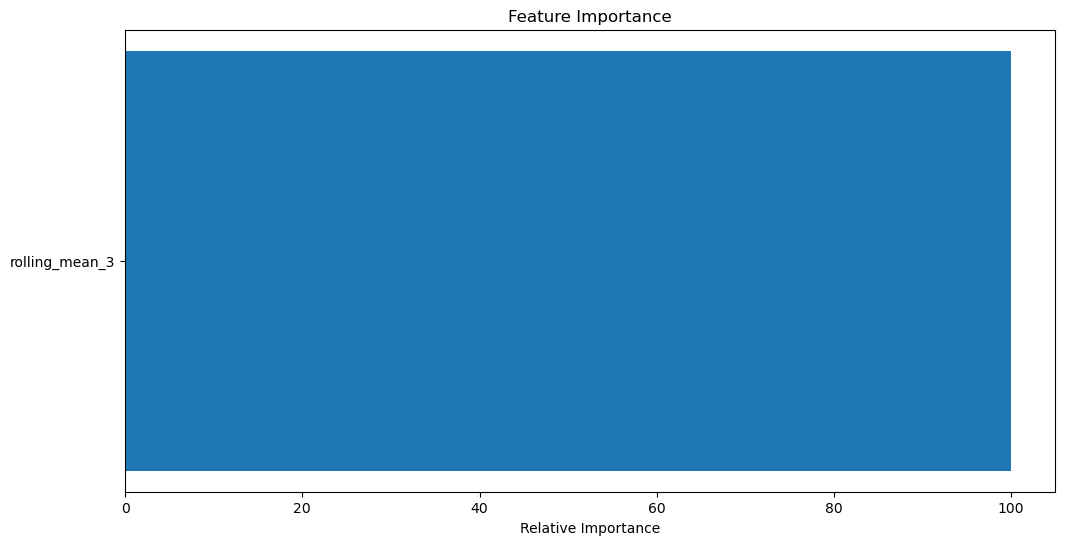

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_features(data):
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    features = pd.DataFrame({
      # 'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1).bfill(),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
    })
    
    return features, data_melted['consumption']

def handle_anomalies(X, y):
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    return X[mask], y[mask]

def optimize_rf_model(X_train, X_test, y_train, y_test):
    param_grid = {
      
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 8]


    }
    
    rf = RandomForestRegressor(random_state=40)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    
    return grid_search.best_estimator_, grid_search.best_params_, predictions

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_predictions(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

def plot_feature_importance(model, X):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    plt.show()

def main():
    data = pd.read_csv('imputed_modelling_gas_data.csv')

    X, y = prepare_features(data)
    
    X, y = handle_anomalies(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=40
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_model, best_params, predictions = optimize_rf_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    train_predictions = best_model.predict(X_train_scaled)
    test_predictions = best_model.predict(X_test_scaled)
    
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, train_predictions)),
        'MAE': mean_absolute_error(y_train, train_predictions),
        'R2': r2_score(y_train, train_predictions)
    }
    
    test_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, test_predictions)),
        'MAE': mean_absolute_error(y_test, test_predictions),
        'R2': r2_score(y_test, test_predictions)
    }
    
    print("Best Parameters:", best_params)
    print("\nTrain Performance:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value}")
    print("\nTest Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value}")
    
    plot_learning_curve(best_model, X, y)
    plot_predictions(y_test, test_predictions)
    plot_feature_importance(best_model, X)
    
    return best_model, best_params, train_metrics, test_metrics

if __name__ == "__main__":
    best_model, best_params, train_metrics, test_metrics = main()


In [10]:
def prepare_features(data):
    data_melted = data.melt(
        id_vars=['Meter_Location'],
        var_name='month',
        value_name='consumption'
    )
    
    data_melted['month'] = pd.to_datetime(data_melted['month'].str.replace('_', '-') + '-01')
    
    features = pd.DataFrame({
       # 'consumption_lag1': data_melted.groupby('Meter_Location')['consumption'].shift(1).bfill(),
        #'consumption_lag2': data_melted.groupby('Meter_Location')['consumption'].shift(2).bfill(),
        'rolling_mean_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).mean().reset_index(0, drop=True),
       # 'rolling_std_3': data_melted.groupby('Meter_Location')['consumption'].rolling(3, min_periods=1).std().reset_index(0, drop=True).fillna(0)
    })
    
    return features, data_melted['consumption']

def optimize_rf_model(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': [100, 300, 500, 700],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    rf = RandomForestRegressor(random_state=40)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=10,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    
    return grid_search.best_estimator_, grid_search.best_params_, predictions

def main():
    data = pd.read_csv('imputed_modelling_gas_data - Copy.csv')

    X, y = prepare_features(data)
    
    # Handle anomalies
    X, y = handle_anomalies(X, y)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=40
    )
    
    # Normalize features and target variable
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
    
    # Optimize and train the model
    best_model, best_params, predictions_scaled = optimize_rf_model(
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled
    )
    
    # Inverse transform predictions for evaluation
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()
    
    train_predictions_scaled = best_model.predict(X_train_scaled)
    train_predictions = scaler_y.inverse_transform(train_predictions_scaled.reshape(-1, 1)).ravel()
    
    test_predictions_scaled = best_model.predict(X_test_scaled)
    test_predictions = scaler_y.inverse_transform(test_predictions_scaled.reshape(-1, 1)).ravel()
    
    # Evaluate performance
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, train_predictions)),
        'MAE': mean_absolute_error(y_train, train_predictions),
        'R2': r2_score(y_train, train_predictions)
    }
    
    test_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, test_predictions)),
        'MAE': mean_absolute_error(y_test, test_predictions),
        'R2': r2_score(y_test, test_predictions)
    }
    
    print("Best Parameters:", best_params)
    print("\nTrain Performance:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value}")
        
    print("\nTest Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value}")
    
    plot_learning_curve(best_model, X_train_scaled, y_train_scaled)
    plot_predictions(y_test.values.ravel(), test_predictions)
    plot_feature_importance(best_model, X)


if __name__ == "__main__":
    main()

NameError: name 'handle_anomalies' is not defined

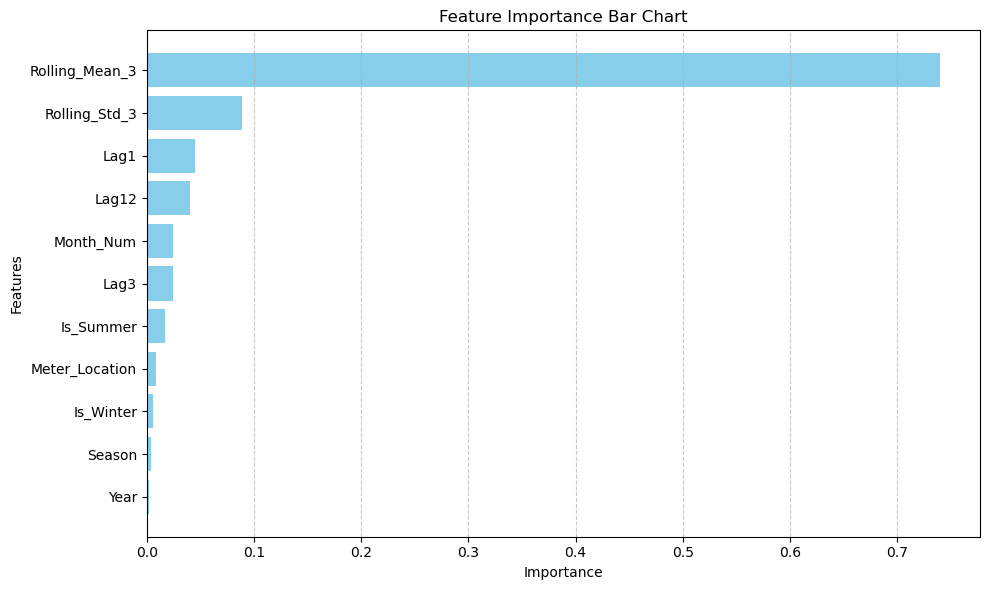

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load and preprocess the data
data = pd.read_csv('imputed_modelling_gas_data.csv')

# Melt the data into long format
data_melted = data.melt(id_vars=['Meter_Location'], var_name='Month', value_name='Consumption')

# Clean and parse the 'Month' column
def clean_month_column(month):
    try:
        return pd.to_datetime(month.replace('_', '-') + '-01')
    except:
        return np.nan

data_melted['Month'] = data_melted['Month'].apply(clean_month_column)
data_melted = data_melted.dropna(subset=['Month'])  # Drop rows with invalid dates

# Create features
data_melted['Lag1'] = data_melted.groupby('Meter_Location')['Consumption'].shift(1)
data_melted['Lag3'] = data_melted.groupby('Meter_Location')['Consumption'].shift(3)
data_melted['Lag12'] = data_melted.groupby('Meter_Location')['Consumption'].shift(12)
data_melted['Month_Num'] = data_melted['Month'].dt.month
data_melted['Year'] = data_melted['Month'].dt.year
data_melted['Season'] = pd.cut(data_melted['Month_Num'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Autumn'])
data_melted['Is_Summer'] = data_melted['Month_Num'].isin([6, 7, 8]).astype(int)
data_melted['Is_Winter'] = data_melted['Month_Num'].isin([12, 1, 2]).astype(int)
data_melted['Rolling_Mean_3'] = data_melted.groupby('Meter_Location')['Consumption'].rolling(window=3).mean().reset_index(0, drop=True)
data_melted['Rolling_Std_3'] = data_melted.groupby('Meter_Location')['Consumption'].rolling(window=3).std().reset_index(0, drop=True)

# Encode categorical variables
le = LabelEncoder()
data_melted['Meter_Location'] = le.fit_transform(data_melted['Meter_Location'])
data_melted['Season'] = le.fit_transform(data_melted['Season'])

# Prepare features and target
features = ['Meter_Location', 'Lag1', 'Lag3', 'Lag12', 'Month_Num', 'Year', 'Season', 
            'Is_Summer', 'Is_Winter', 'Rolling_Mean_3', 'Rolling_Std_3']
X = data_melted[features].dropna()
y = data_melted['Consumption'].loc[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=True)

# Plot feature importance bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Bar Chart')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


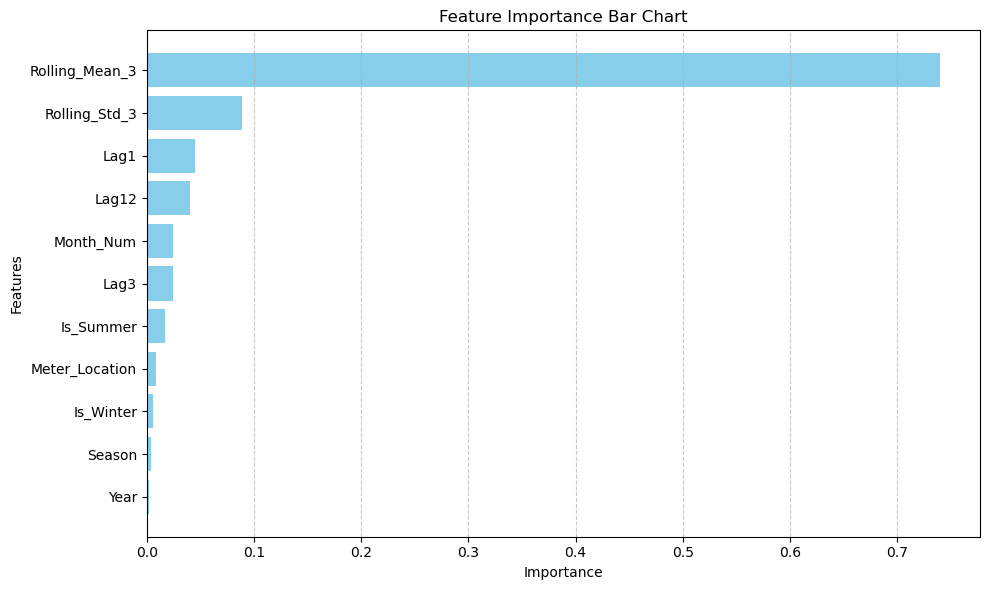

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load and preprocess the data
data = pd.read_csv('imputed_modelling_gas_data.csv')

# Melt the data into long format
data_melted = data.melt(id_vars=['Meter_Location'], var_name='Month', value_name='Consumption')

# Clean and parse the 'Month' column
def clean_month_column(month):
    try:
        return pd.to_datetime(month.replace('_', '-') + '-01')
    except:
        return np.nan

data_melted['Month'] = data_melted['Month'].apply(clean_month_column)
data_melted = data_melted.dropna(subset=['Month'])  # Drop rows with invalid dates

# Create features
data_melted['Lag1'] = data_melted.groupby('Meter_Location')['Consumption'].shift(1)
data_melted['Lag3'] = data_melted.groupby('Meter_Location')['Consumption'].shift(3)
data_melted['Lag12'] = data_melted.groupby('Meter_Location')['Consumption'].shift(12)
data_melted['Month_Num'] = data_melted['Month'].dt.month
data_melted['Year'] = data_melted['Month'].dt.year
data_melted['Season'] = pd.cut(data_melted['Month_Num'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Autumn'])
data_melted['Is_Summer'] = data_melted['Month_Num'].isin([6, 7, 8]).astype(int)
data_melted['Is_Winter'] = data_melted['Month_Num'].isin([12, 1, 2]).astype(int)
data_melted['Rolling_Mean_3'] = data_melted.groupby('Meter_Location')['Consumption'].rolling(window=3).mean().reset_index(0, drop=True)
data_melted['Rolling_Std_3'] = data_melted.groupby('Meter_Location')['Consumption'].rolling(window=3).std().reset_index(0, drop=True)

# Encode categorical variables
le = LabelEncoder()
data_melted['Meter_Location'] = le.fit_transform(data_melted['Meter_Location'])
data_melted['Season'] = le.fit_transform(data_melted['Season'])

# Prepare features and target
features = ['Meter_Location', 'Lag1', 'Lag3', 'Lag12', 'Month_Num', 'Year', 'Season', 
            'Is_Summer', 'Is_Winter', 'Rolling_Mean_3', 'Rolling_Std_3']
X = data_melted[features].dropna()
y = data_melted['Consumption'].loc[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=True)

# Plot feature importance bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Bar Chart')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Train R^2: 0.82
Test R^2: 0.33
Train RMSE: 34055.96
Test RMSE: 37337.48


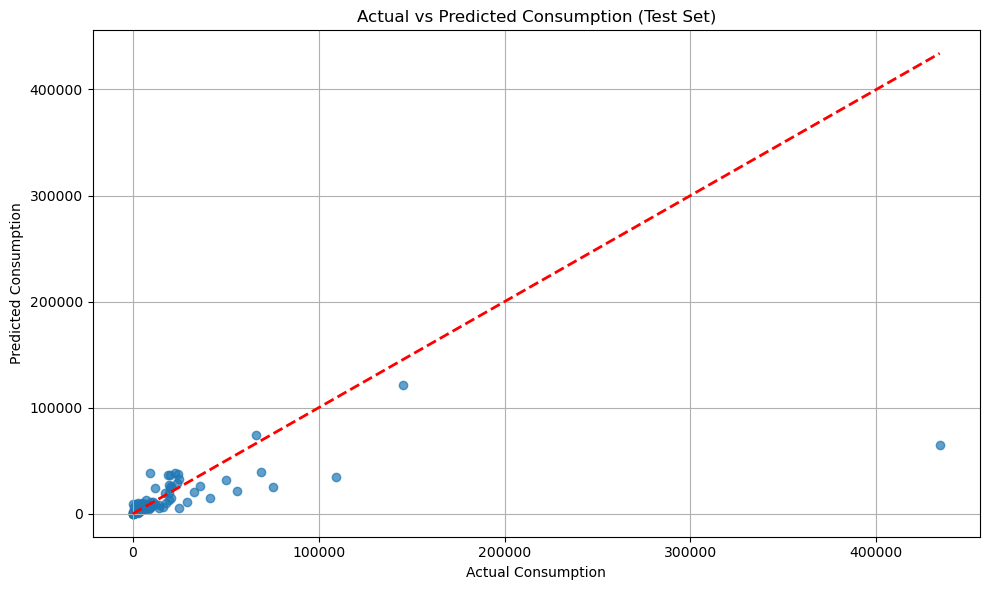

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data = pd.read_csv('imputed_modelling_gas_data.csv')

# Melt the data into long format
data_melted = data.melt(id_vars=['Meter_Location'], var_name='Month', value_name='Consumption')

# Clean and parse the 'Month' column
def clean_month_column(month):
    try:
        return pd.to_datetime(month.replace('_', '-') + '-01')
    except:
        return np.nan

data_melted['Month'] = data_melted['Month'].apply(clean_month_column)
data_melted = data_melted.dropna(subset=['Month'])  # Drop rows with invalid dates

# Step 2: Create important features
#data_melted['Lag1'] = data_melted.groupby('Meter_Location')['Consumption'].shift(1)
#data_melted['Lag12'] = data_melted.groupby('Meter_Location')['Consumption'].shift(12)
data_melted['Rolling_Mean_3'] = data_melted.groupby('Meter_Location')['Consumption'].rolling(window=3).mean().reset_index(0, drop=True)

# Drop rows with NaN values after creating lagged features
data_melted = data_melted.dropna(subset=[#'Lag1', 'Lag12', 
                                         'Rolling_Mean_3'])

# Prepare features and target variable
features = ['Rolling_Mean_3' #, 'Lag12', 'Lag1'
           ]
X = data_melted[features]
y = data_melted['Consumption']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R^2: {train_r2:.2f}")
print(f"Test R^2: {test_r2:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Step 6: Plot Actual vs Predicted for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('Actual vs Predicted Consumption (Test Set)')
plt.grid()
plt.tight_layout()
plt.show()


Train R^2: 0.82
Test R^2: 0.63
Train RMSE: 39397.85
Test RMSE: 40211.94


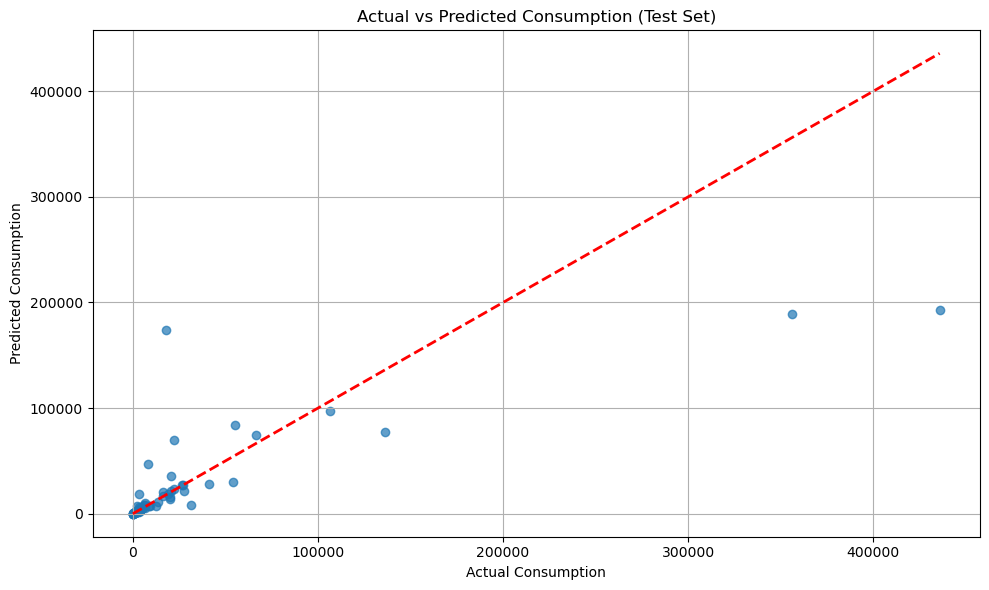

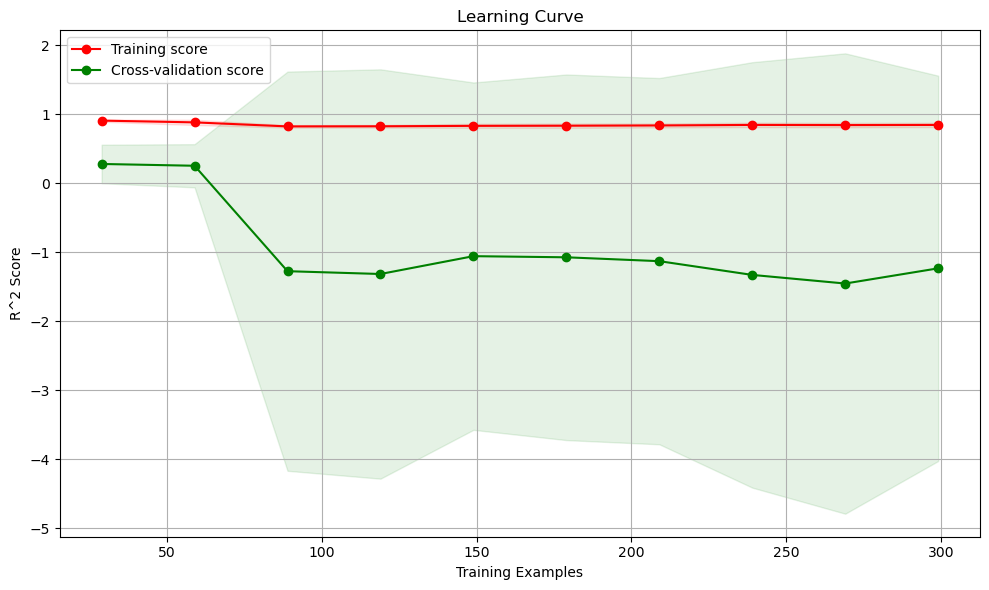

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data = pd.read_csv('imputed_modelling_gas_data.csv')

# Melt the data into long format
data_melted = data.melt(id_vars=['Meter_Location'], var_name='Month', value_name='Consumption')

# Clean and parse the 'Month' column
def clean_month_column(month):
    try:
        return pd.to_datetime(month.replace('_', '-') + '-01')
    except:
        return np.nan

data_melted['Month'] = data_melted['Month'].apply(clean_month_column)
data_melted = data_melted.dropna(subset=['Month'])  # Drop rows with invalid dates

# Step 2: Create important features
data_melted['Lag1'] = data_melted.groupby('Meter_Location')['Consumption'].shift(1)
data_melted['Lag12'] = data_melted.groupby('Meter_Location')['Consumption'].shift(12)
data_melted['Rolling_Mean_3'] = data_melted.groupby('Meter_Location')['Consumption'].rolling(window=3).mean().reset_index(0, drop=True)

# Drop rows with NaN values after creating lagged features
data_melted = data_melted.dropna(subset=['Lag1', 'Lag12', 'Rolling_Mean_3'])

# Prepare features and target variable
features = ['Rolling_Mean_3', 'Lag12', 'Lag1']
X = data_melted[features]
y = data_melted['Consumption']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R^2: {train_r2:.2f}")
print(f"Test R^2: {test_r2:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Step 6: Plot Actual vs Predicted for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('Actual vs Predicted Consumption (Test Set)')
plt.grid()
plt.tight_layout()
plt.show()

# Step 7: Plot Learning Curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='r2', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("R^2 Score")
    plt.grid()

    # Plot shaded areas for standard deviation
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")

    # Plot mean scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Combine training and testing sets using pd.concat()
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

# Call the function to plot the learning curve
plot_learning_curve(rf_model, X_combined, y_combined)


Random Forest Model Parameters:
- Number of Trees (n_estimators): 500
- Maximum Depth of Trees (max_depth): 10
- Random State: 42

Performance Metrics:
- Train R^2: 0.82
- Test R^2: 0.63
- Train RMSE: 39397.85
- Test RMSE: 40211.94



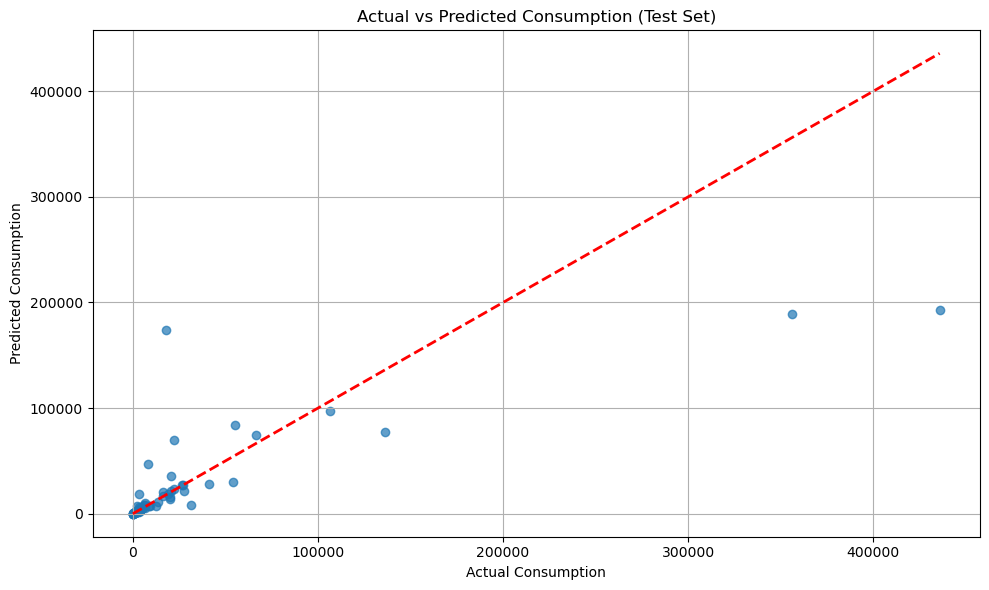

Learning Curve Parameters:
- Cross-validation folds (cv): 5
- Scoring Metric: R^2



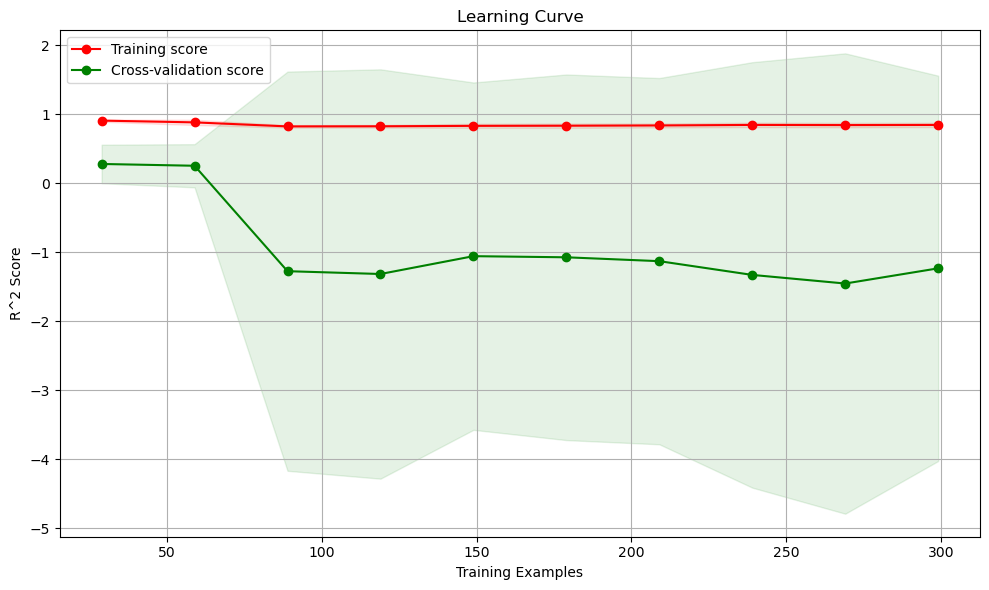

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data = pd.read_csv('imputed_modelling_gas_data.csv')

# Melt the data into long format
data_melted = data.melt(id_vars=['Meter_Location'], var_name='Month', value_name='Consumption')

# Clean and parse the 'Month' column
def clean_month_column(month):
    try:
        return pd.to_datetime(month.replace('_', '-') + '-01')
    except:
        return np.nan

data_melted['Month'] = data_melted['Month'].apply(clean_month_column)
data_melted = data_melted.dropna(subset=['Month'])  # Drop rows with invalid dates

# Step 2: Create important features
data_melted['Lag1'] = data_melted.groupby('Meter_Location')['Consumption'].shift(1)
data_melted['Lag12'] = data_melted.groupby('Meter_Location')['Consumption'].shift(12)
data_melted['Rolling_Mean_3'] = data_melted.groupby('Meter_Location')['Consumption'].rolling(window=3).mean().reset_index(0, drop=True)

# Drop rows with NaN values after creating lagged features
data_melted = data_melted.dropna(subset=['Lag1', 'Lag12', 'Rolling_Mean_3'])

# Prepare features and target variable
features = ['Rolling_Mean_3', 'Lag12', 'Lag1']
X = data_melted[features]
y = data_melted['Consumption']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Random Forest Model Parameters:")
print(f"- Number of Trees (n_estimators): {rf_model.n_estimators}")
print(f"- Maximum Depth of Trees (max_depth): {rf_model.max_depth}")
print(f"- Random State: {rf_model.random_state}\n")

print(f"Performance Metrics:")
print(f"- Train R^2: {train_r2:.2f}")
print(f"- Test R^2: {test_r2:.2f}")
print(f"- Train RMSE: {train_rmse:.2f}")
print(f"- Test RMSE: {test_rmse:.2f}\n")

# Step 6: Plot Actual vs Predicted for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('Actual vs Predicted Consumption (Test Set)')
plt.grid()
plt.tight_layout()
plt.show()

# Step 7: Plot Learning Curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='r2', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("R^2 Score")
    plt.grid()

    # Plot shaded areas for standard deviation
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")

    # Plot mean scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Combine training and testing sets using pd.concat()
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

print("Learning Curve Parameters:")
print("- Cross-validation folds (cv): 5")
print("- Scoring Metric: R^2\n")

# Call the function to plot the learning curve
plot_learning_curve(rf_model, X_combined, y_combined)


Random Forest Model Parameters:
- Number of Trees (n_estimators): 500
- Maximum Depth of Trees (max_depth): 10
- Random State: 42



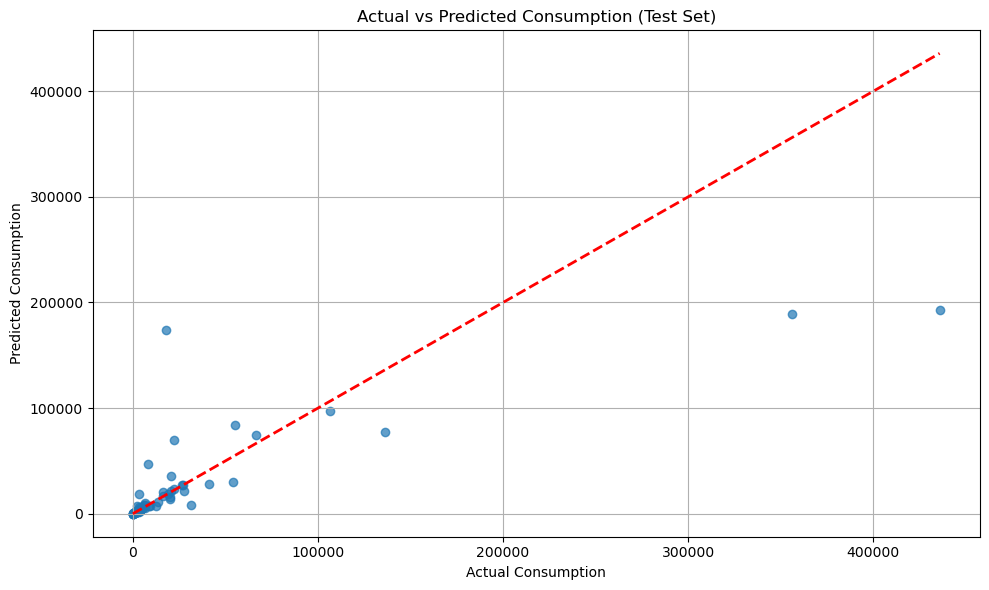

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data = pd.read_csv('imputed_modelling_gas_data.csv')

# Melt the data into long format
data_melted = data.melt(id_vars=['Meter_Location'], var_name='Month', value_name='Consumption')

# Clean and parse the 'Month' column
def clean_month_column(month):
    try:
        return pd.to_datetime(month.replace('_', '-') + '-01')
    except:
        return np.nan

data_melted['Month'] = data_melted['Month'].apply(clean_month_column)
data_melted = data_melted.dropna(subset=['Month'])  # Drop rows with invalid dates

# Step 2: Create important features
data_melted['Lag1'] = data_melted.groupby('Meter_Location')['Consumption'].shift(1)
data_melted['Lag12'] = data_melted.groupby('Meter_Location')['Consumption'].shift(12)
data_melted['Rolling_Mean_3'] = data_melted.groupby('Meter_Location')['Consumption'].rolling(window=3).mean().reset_index(0, drop=True)

# Drop rows with NaN values after creating lagged features
data_melted = data_melted.dropna(subset=['Lag1', 'Lag12', 'Rolling_Mean_3'])

# Prepare features and target variable
features = ['Rolling_Mean_3', 'Lag12', 'Lag1']
X = data_melted[features]
y = data_melted['Consumption']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Random Forest Model Parameters:")
print(f"- Number of Trees (n_estimators): {rf_model.n_estimators}")
print(f"- Maximum Depth of Trees (max_depth): {rf_model.max_depth}")
print(f"- Random State: {rf_model.random_state}\n")



# Step 6: Plot Actual vs Predicted for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('Actual vs Predicted Consumption (Test Set)')
plt.grid()
plt.tight_layout()
plt.show()


In [5]:
print(f"Performance Metrics:")
print(f"- Train R^2: {train_r2:.2f}")
print(f"- Test R^2: {test_r2:.2f}")
print(f"- Train RMSE: {train_rmse:.2f}")
print(f"- Test RMSE: {test_rmse:.2f}\n")

Performance Metrics:
- Train R^2: 0.82
- Test R^2: 0.63
- Train RMSE: 39397.85
- Test RMSE: 40211.94

